<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

#### 1. Dropping non residential villages unto a new dataframe

In [3]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [4]:
df = house[house['MSZoning'] != 'C (all)']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1191 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   Street         1450 non-null   object 
 6   Alley          89 non-null     object 
 7   LotShape       1450 non-null   object 
 8   LandContour    1450 non-null   object 
 9   Utilities      1450 non-null   object 
 10  LotConfig      1450 non-null   object 
 11  LandSlope      1450 non-null   object 
 12  Neighborhood   1450 non-null   object 
 13  Condition1     1450 non-null   object 
 14  Condition2     1450 non-null   object 
 15  BldgType       1450 non-null   object 
 16  HouseStyle     1450 non-null   object 
 17  OverallQual    1450 non-null   int64  
 18  OverallC

In [6]:
df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1450.000000  1450.000000  1191.000000    1450.000000  1450.000000   
mean    731.364138    56.903448    70.052897   10523.831724     6.114483   
std     421.554345    42.265033    24.301013   10012.185355     1.372860   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     366.250000    20.000000    59.000000    7544.500000     5.000000   
50%     731.500000    50.000000    70.000000    9496.000000     6.000000   
75%    1096.750000    70.000000    80.000000   11613.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1450.000000  1450.000000   1450.000000  1442.000000  1450.000000  ...   
mean      5.582069  1971.593103   1985.049655   104.404300   445.162759  ...   
std       1.107330    30.022696     20.552319   181.486539   456.353871  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   384.000000  ...   
75%       6.000000  2001.000000   2004.000000   166.750000   713.750000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1450.000000  1450.000000    1450.000000  1450.000000  1450.000000   
mean     94.826897    46.537931      21.536552     3.433103    15.096552   
std     125.560863    65.222761      60.838826    29.416948    55.893399   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1450.000000   1450.000000  1450.000000  1450.000000    1450.000000  
mean      2.777931     43.365517     6.312414  2007.812414  181654.942069  
std      40.315051    497.636495     2.698244     1.326321   79176.485241  
min       0.000000      0.000000     1.000000  2006.000000   37900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  130000.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163945.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

#### Checking price against categorical values:

In [7]:
categorical_columns = [f for f in df.columns if df.dtypes[f] == 'object']

numerical_columns = [f for f in df.columns if df.dtypes[f] != 'object']
numerical_columns.remove('SalePrice')
numerical_columns.remove('Id')

In [8]:
def plot_categorical(categorical_column_names, y, df):
    for i in range(len(categorical_column_names)):
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.boxplot(x = df[categorical_column_names[i]], y=y, data=df)
        plt.show()

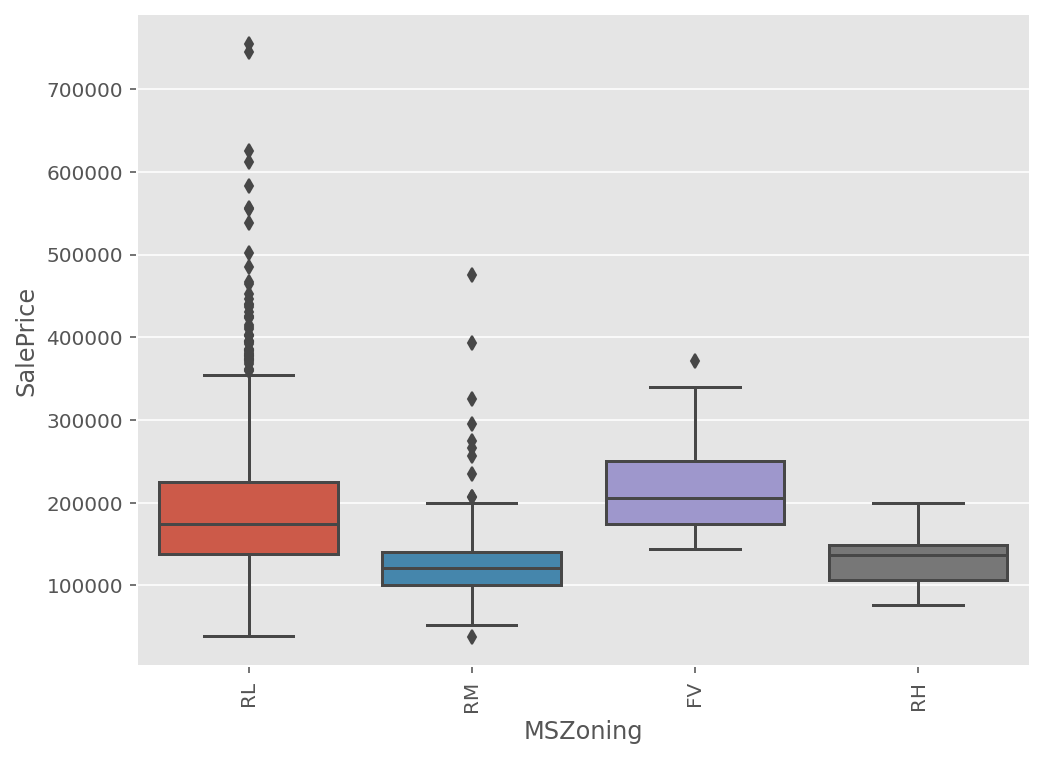

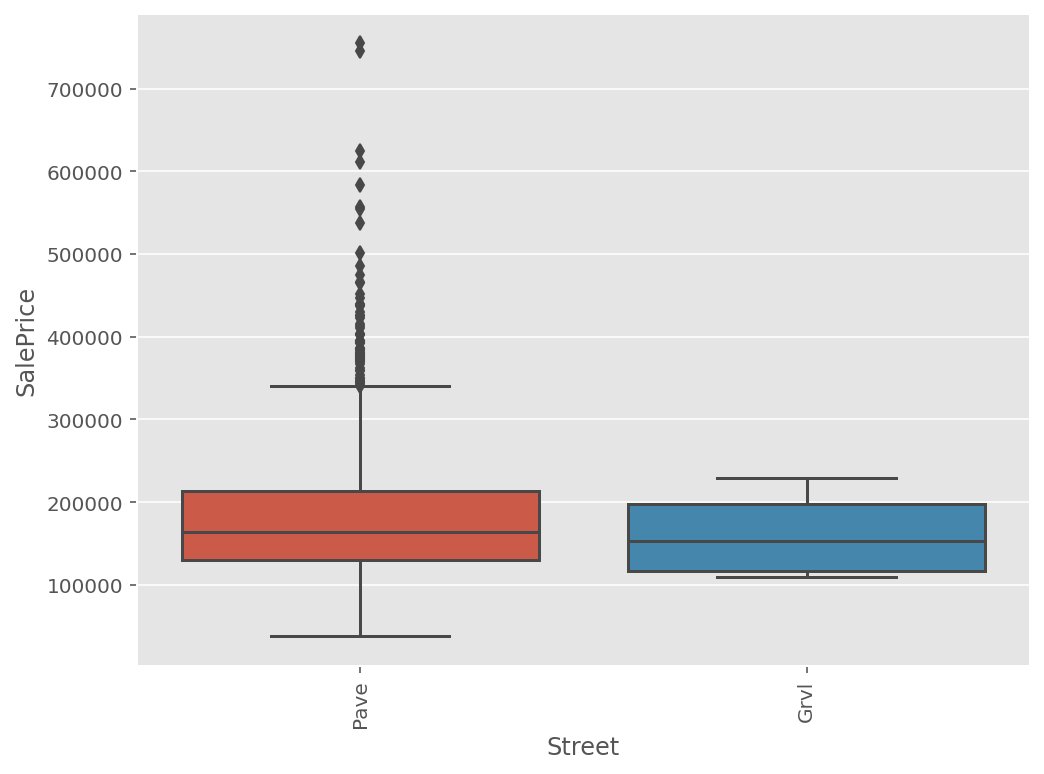

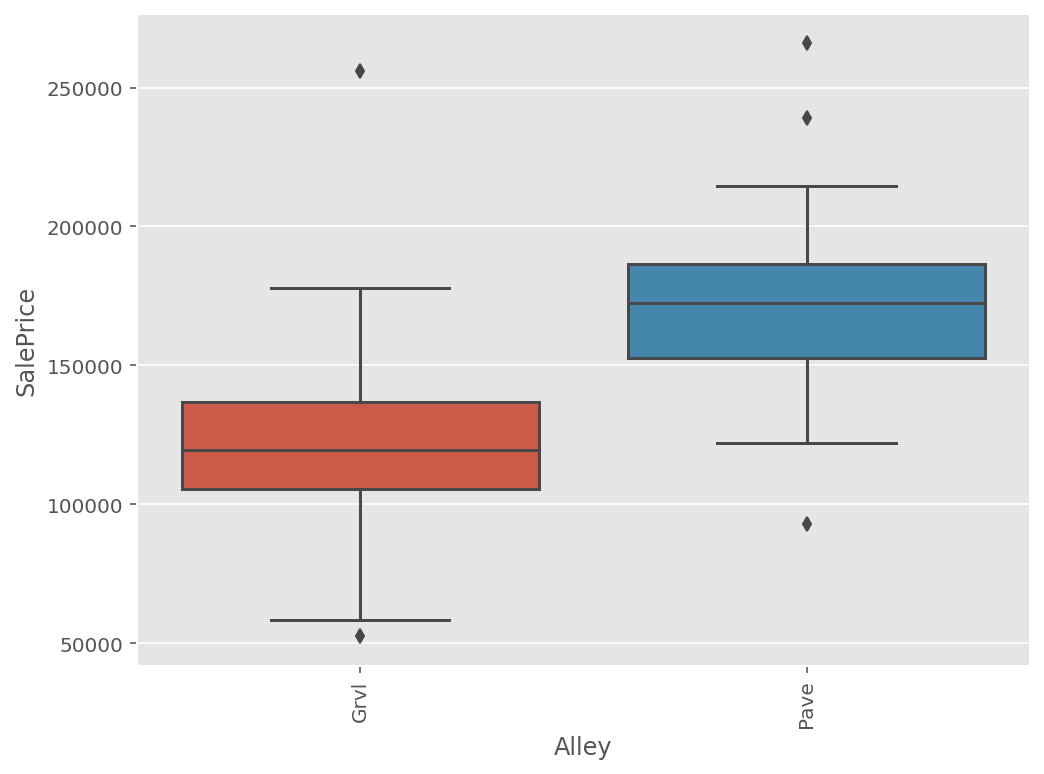

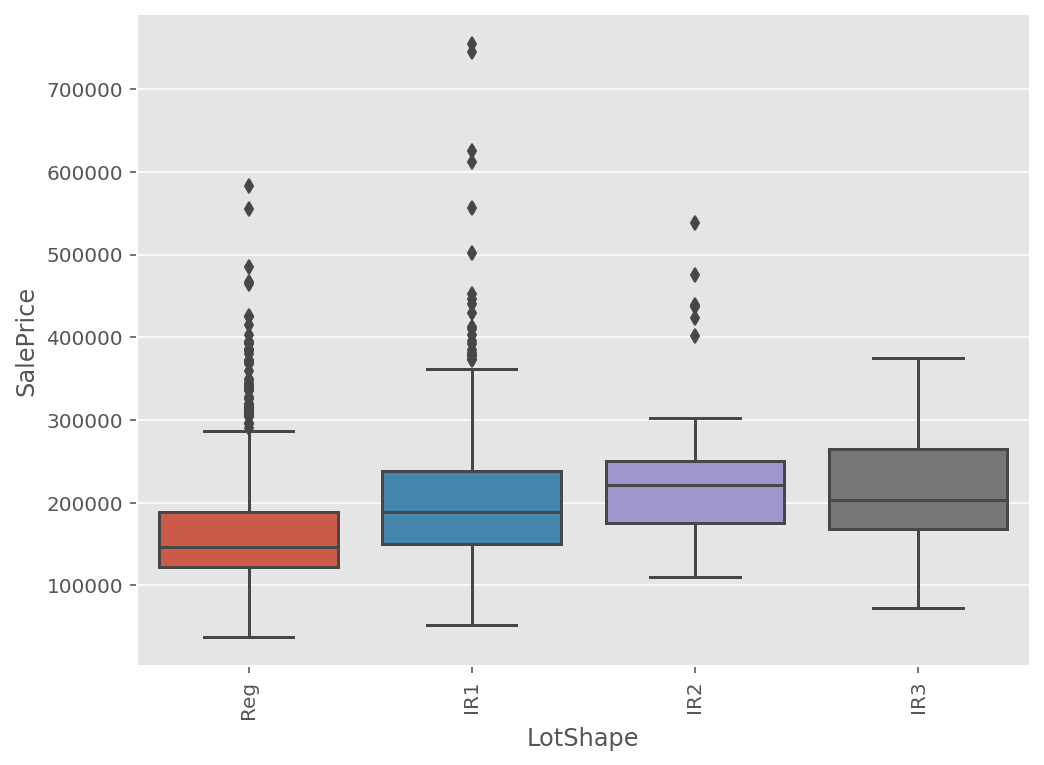

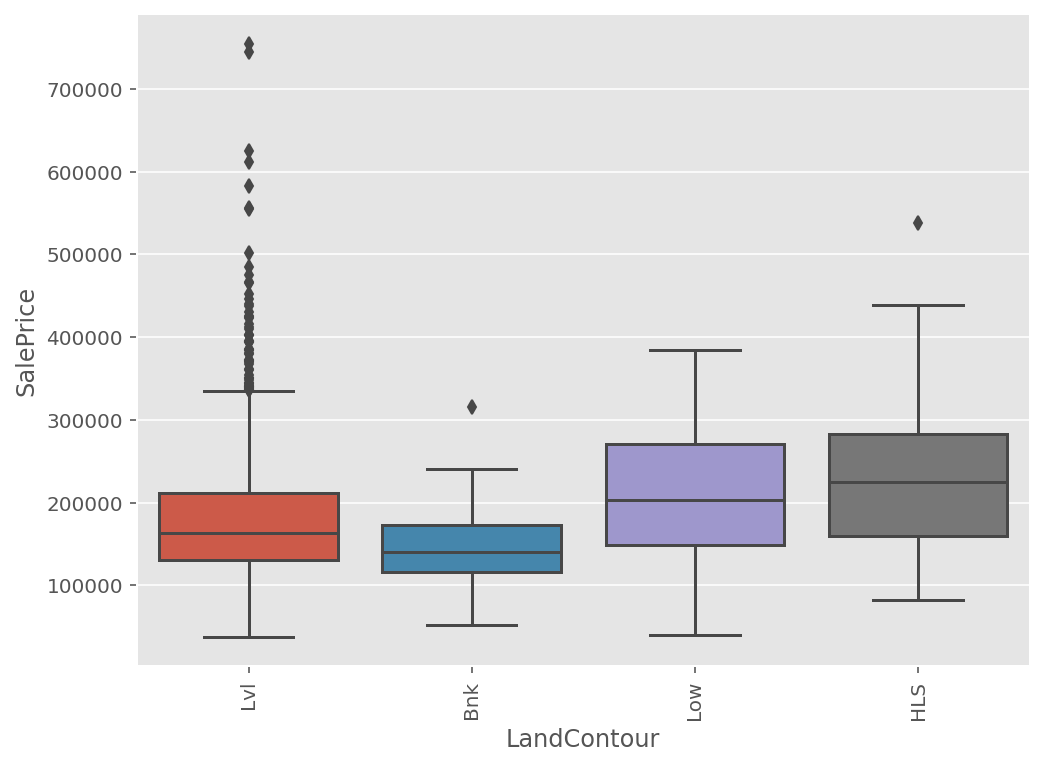

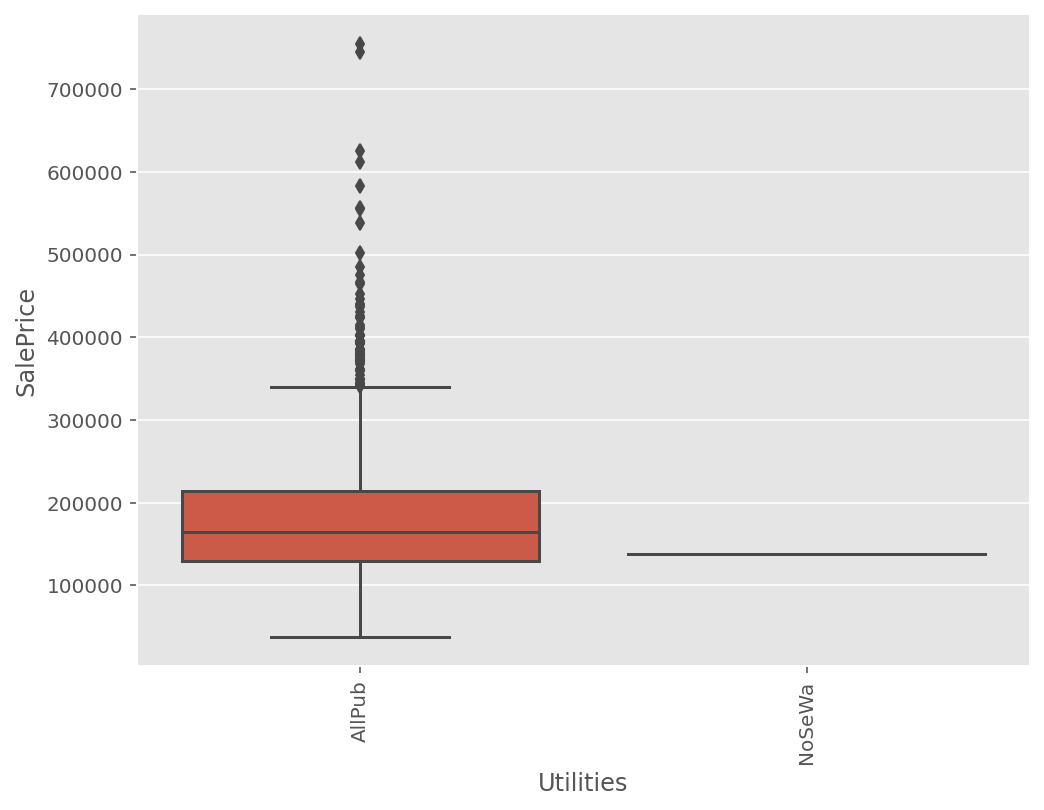

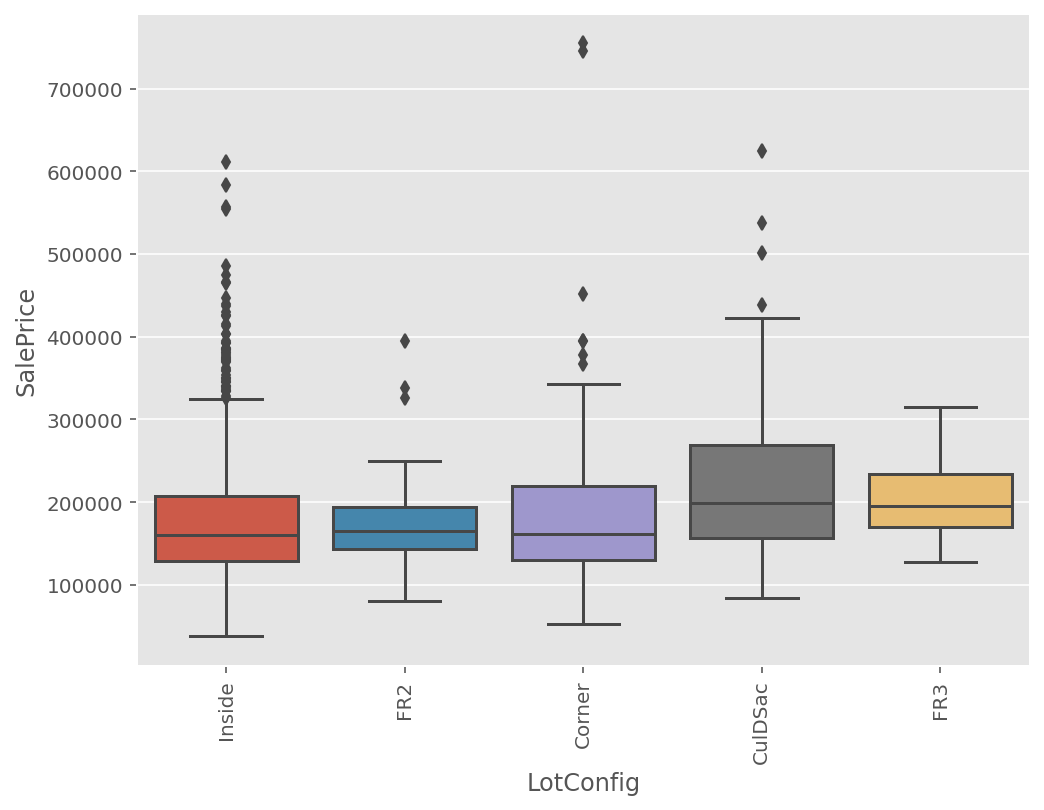

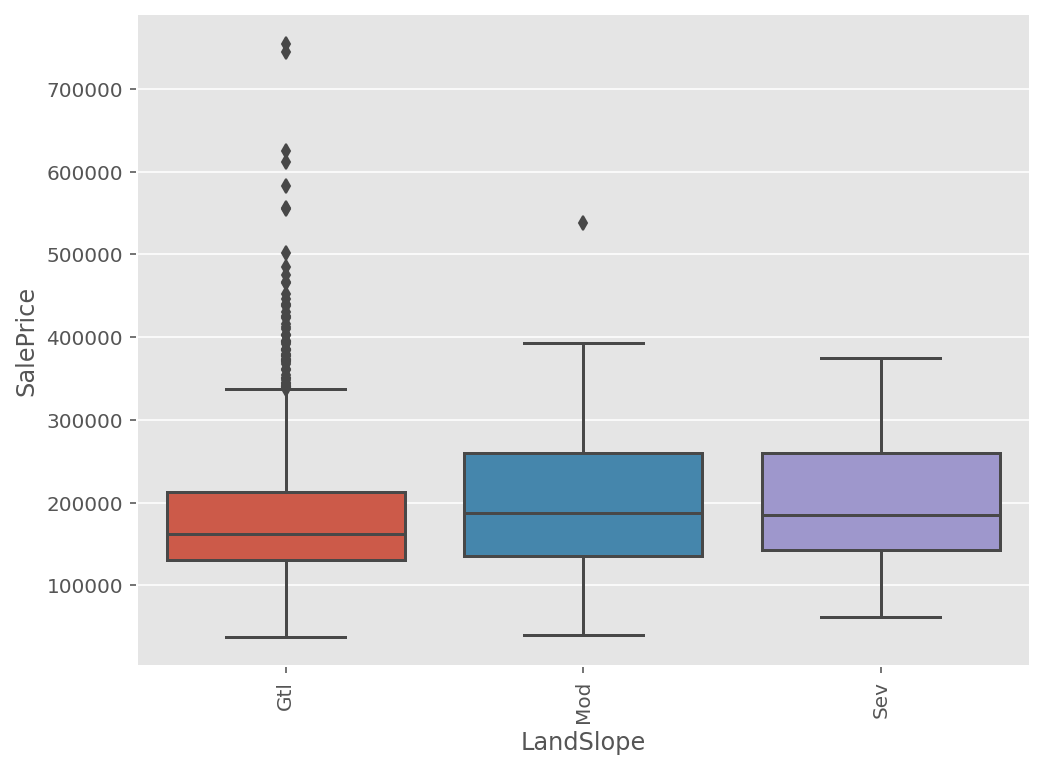

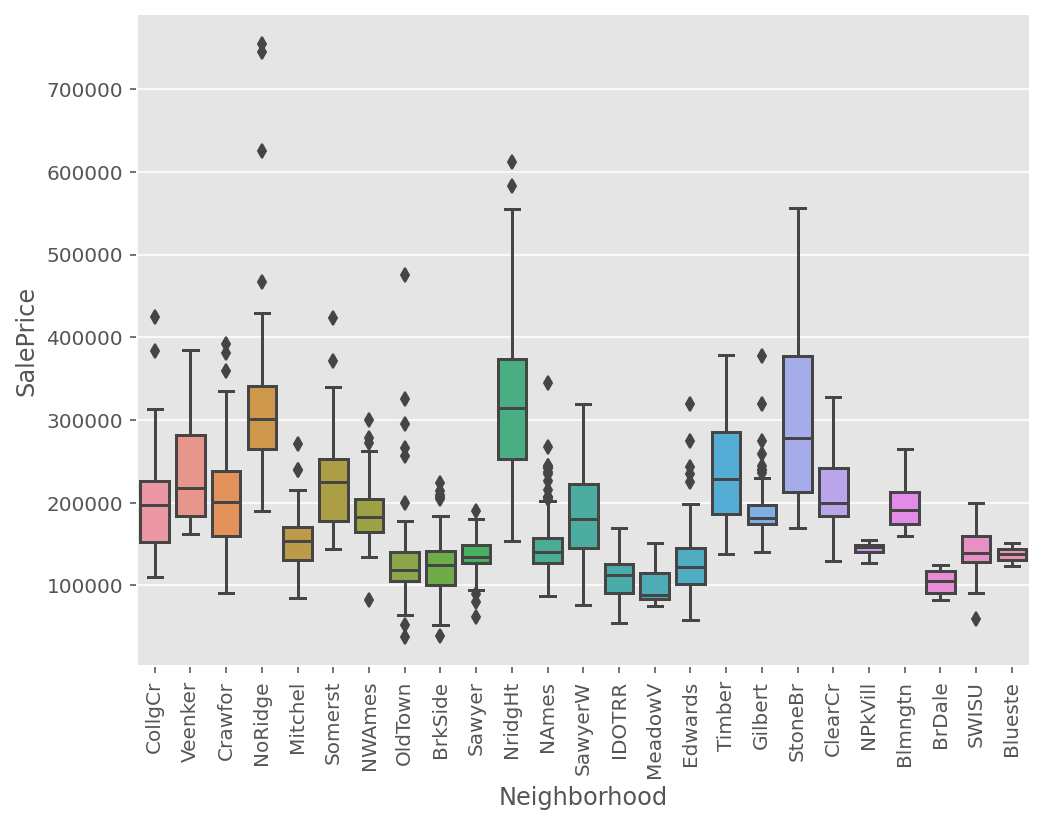

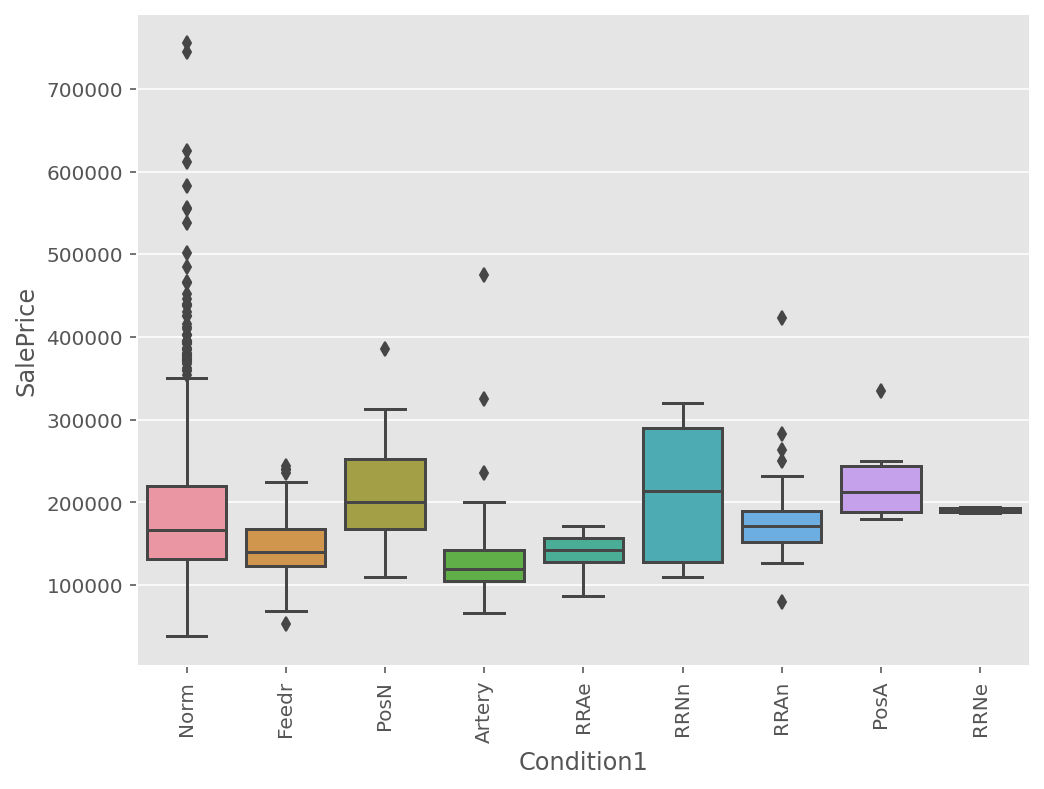

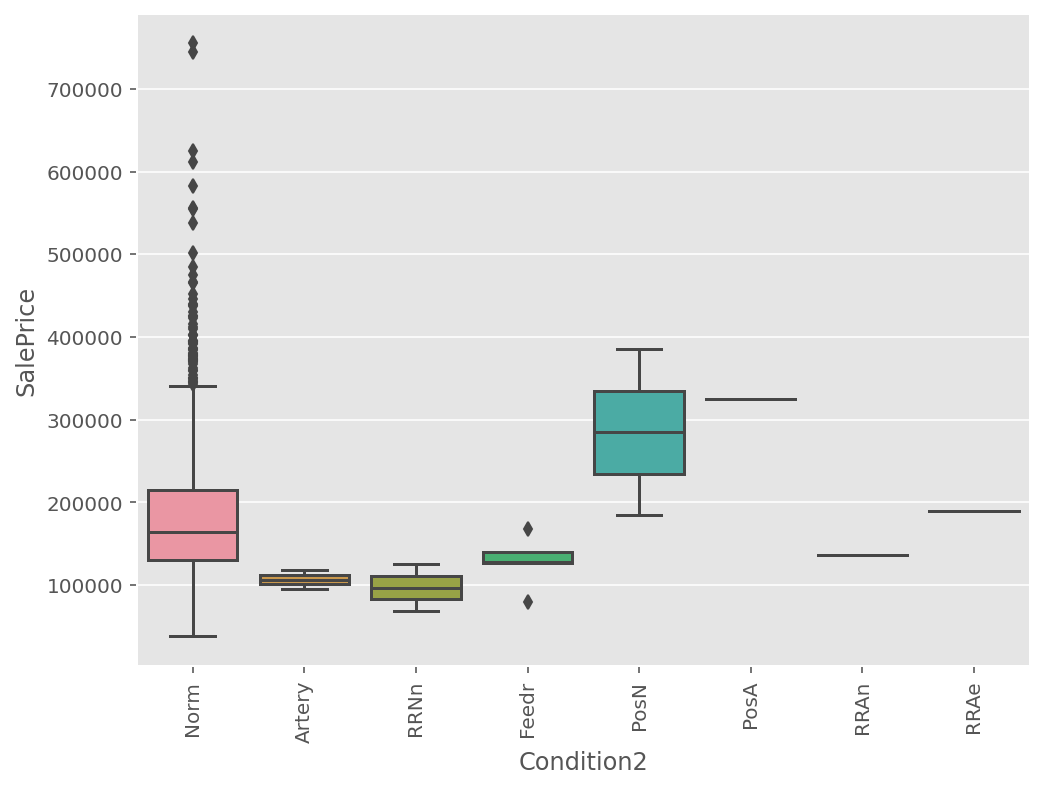

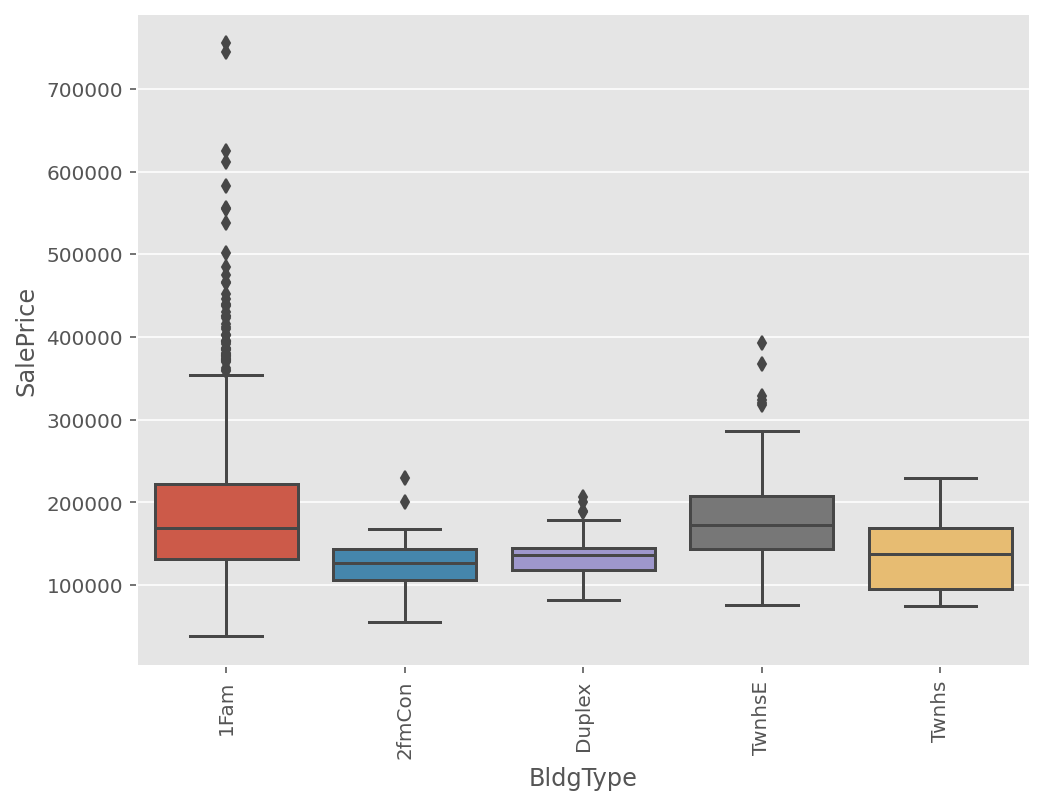

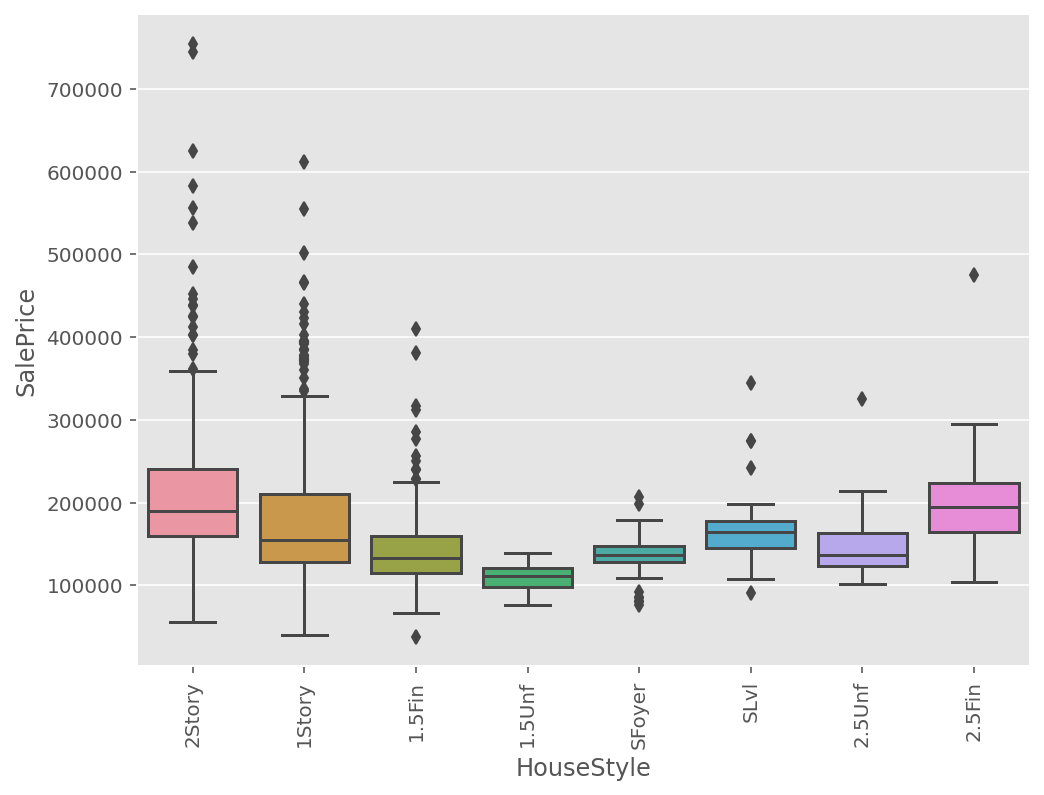

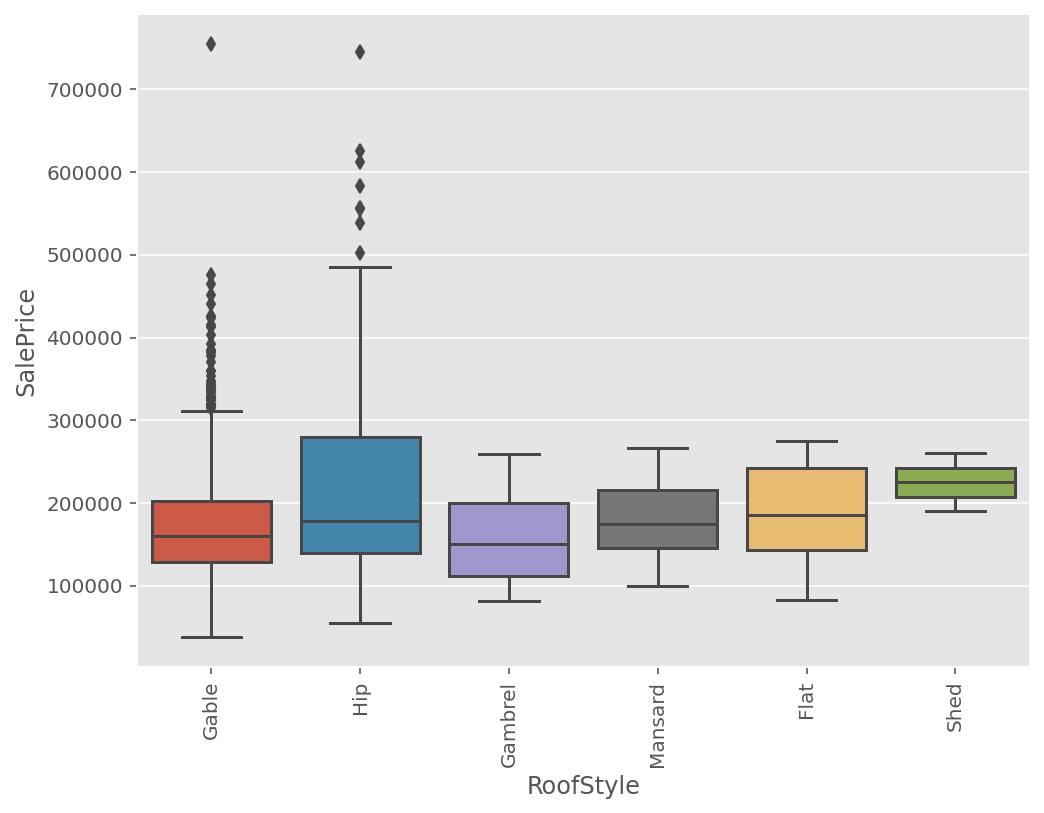

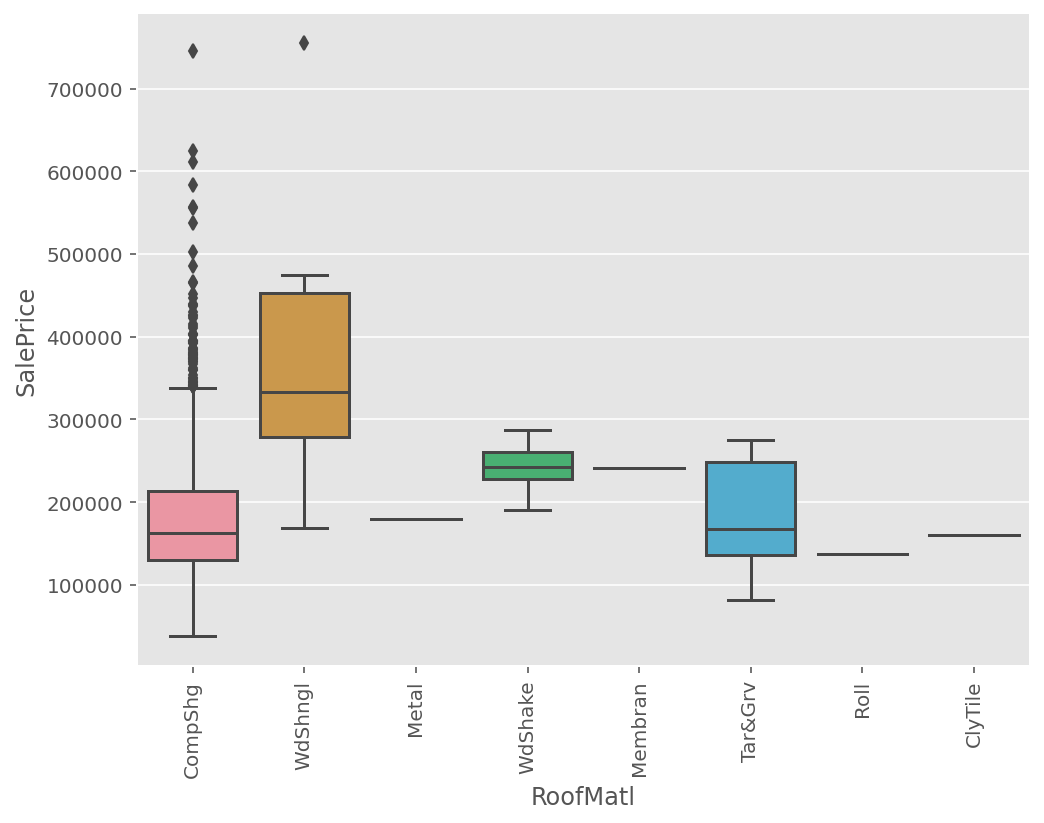

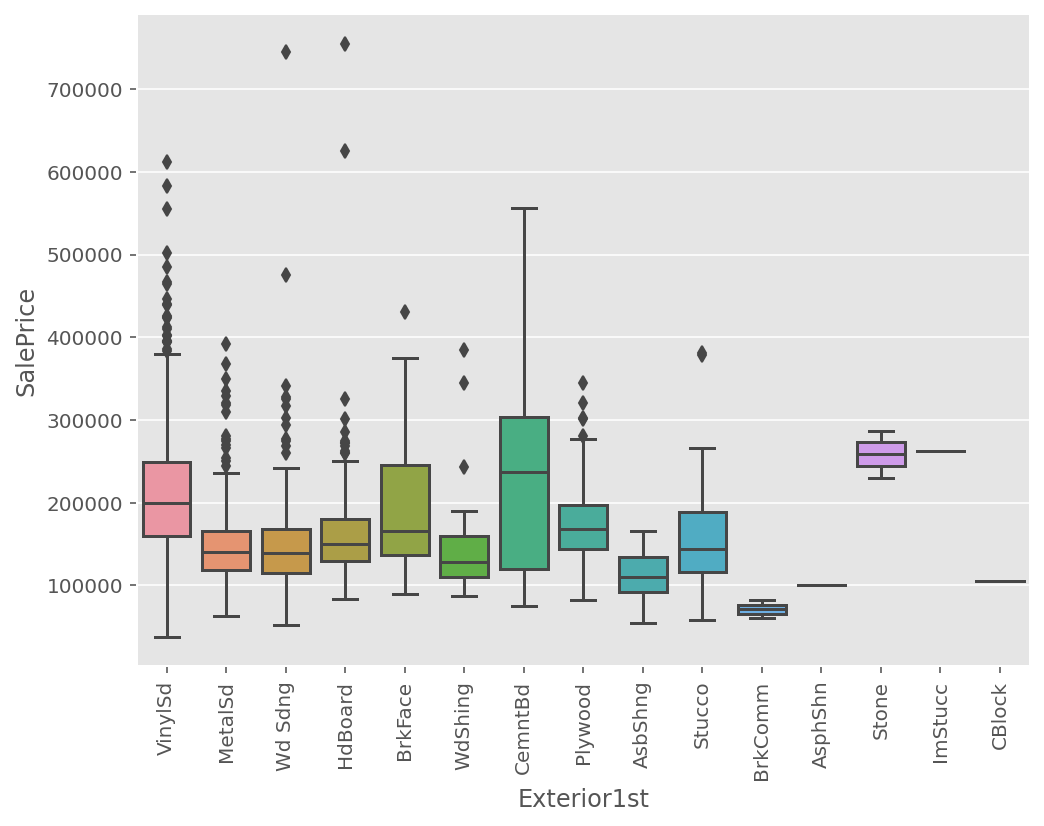

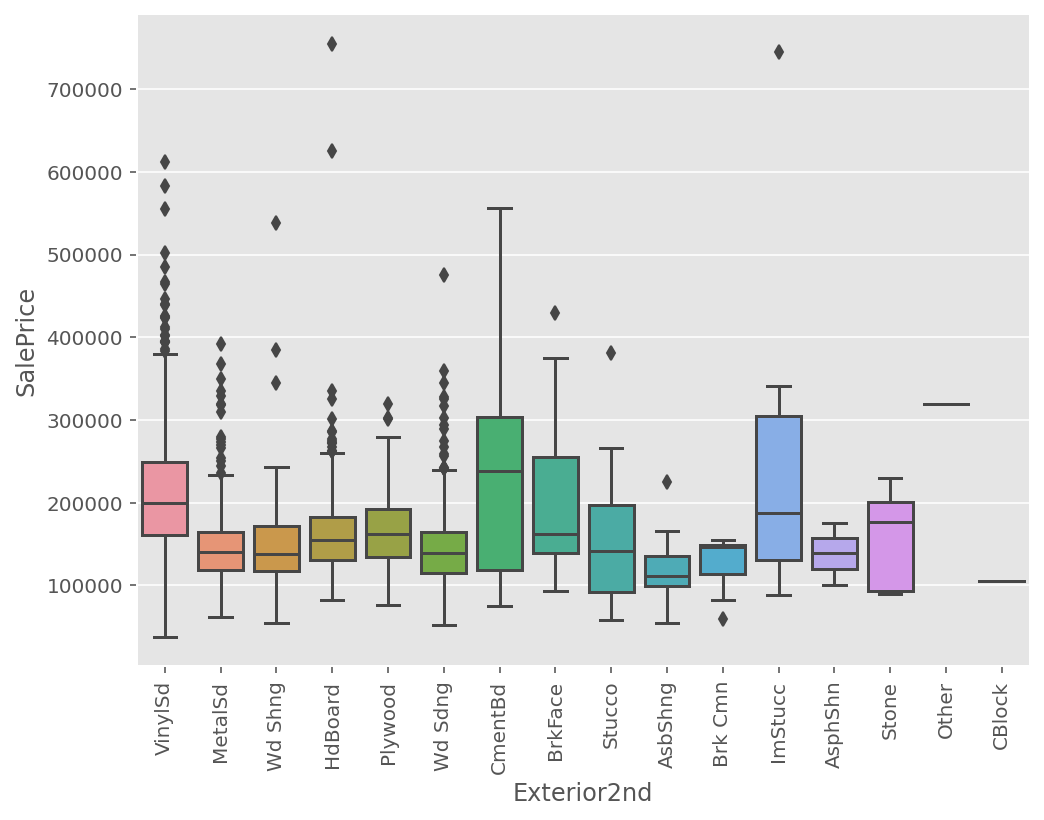

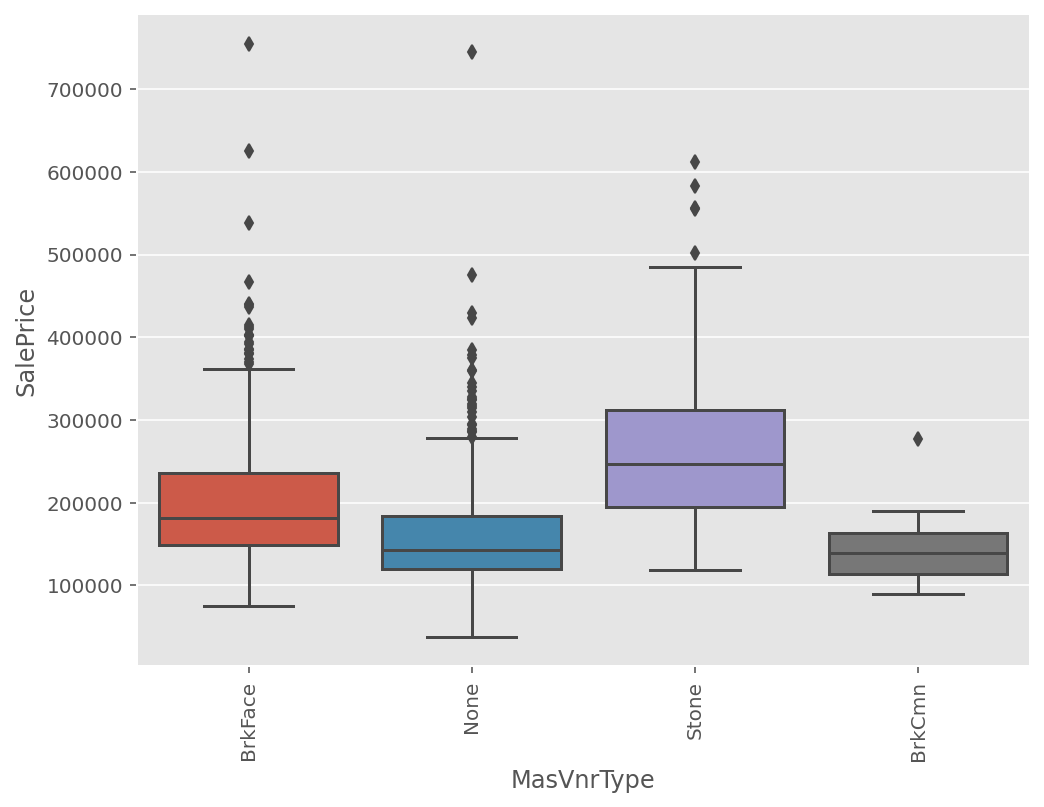

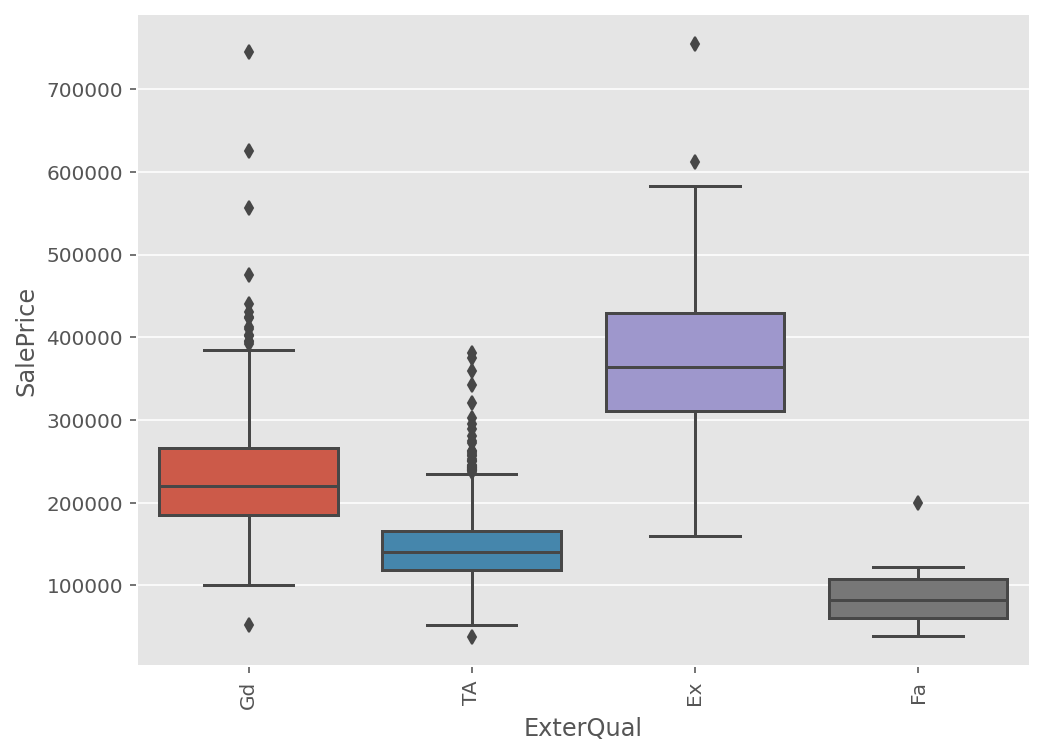

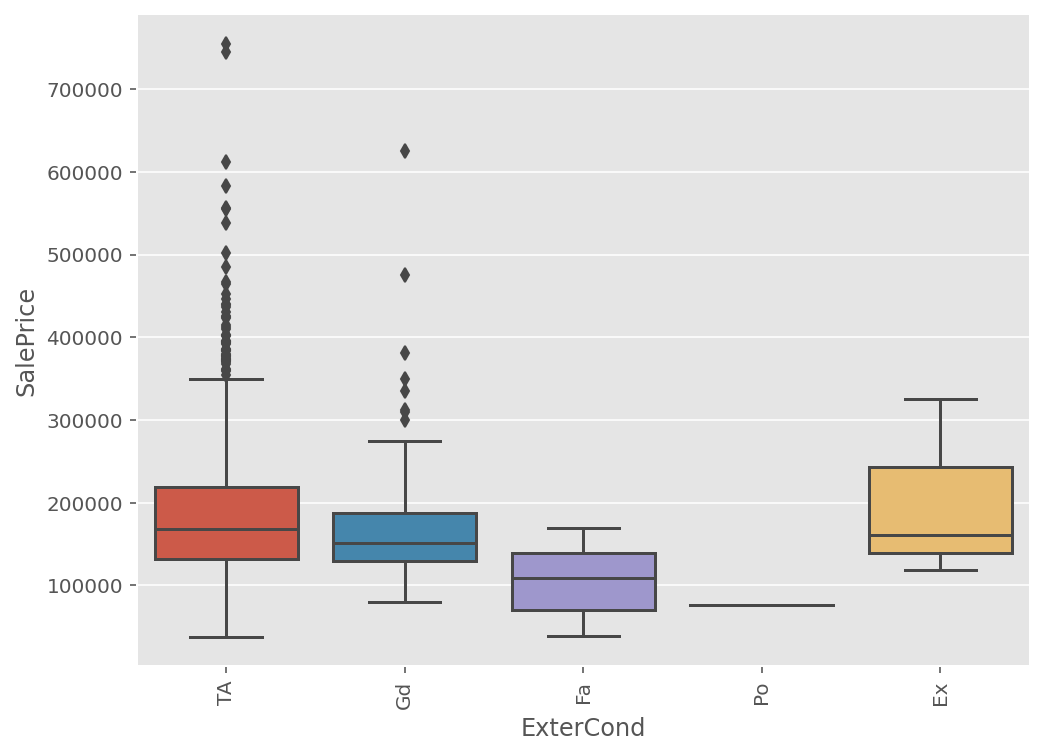

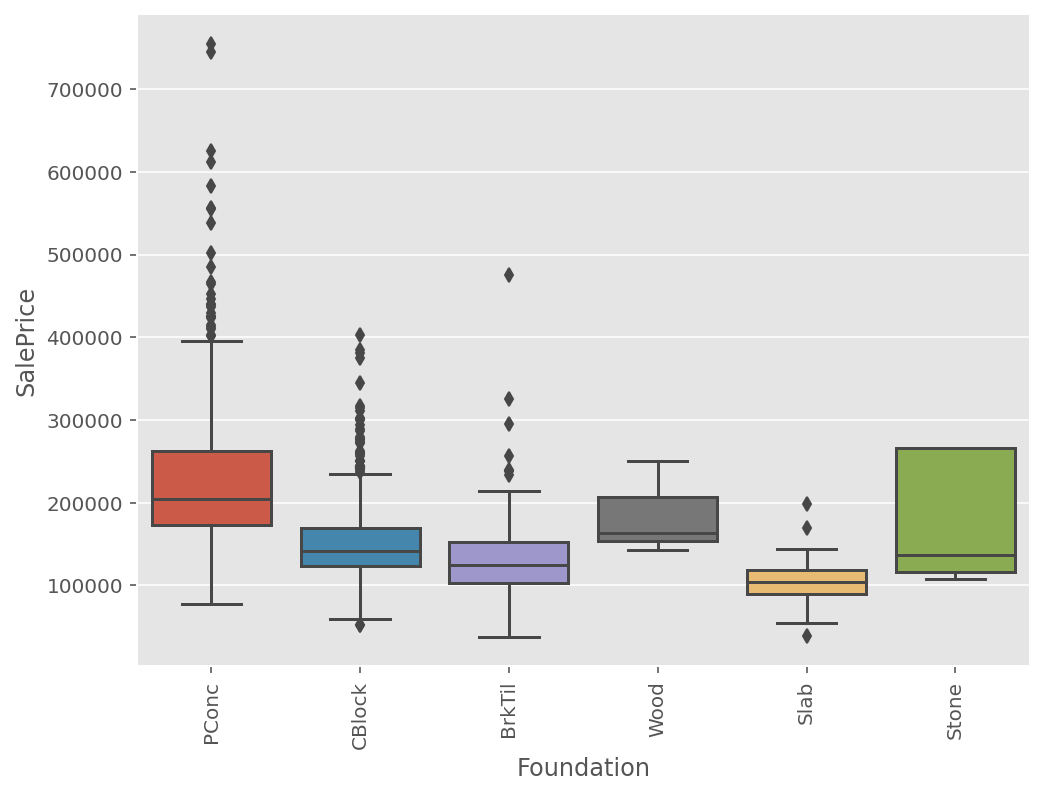

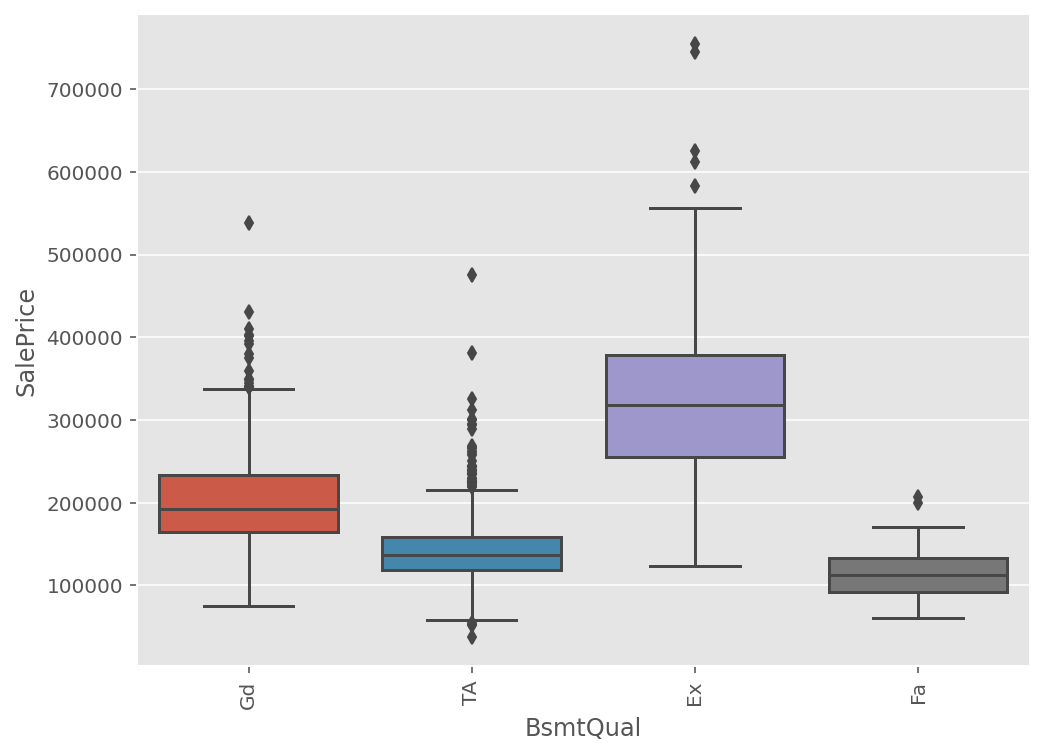

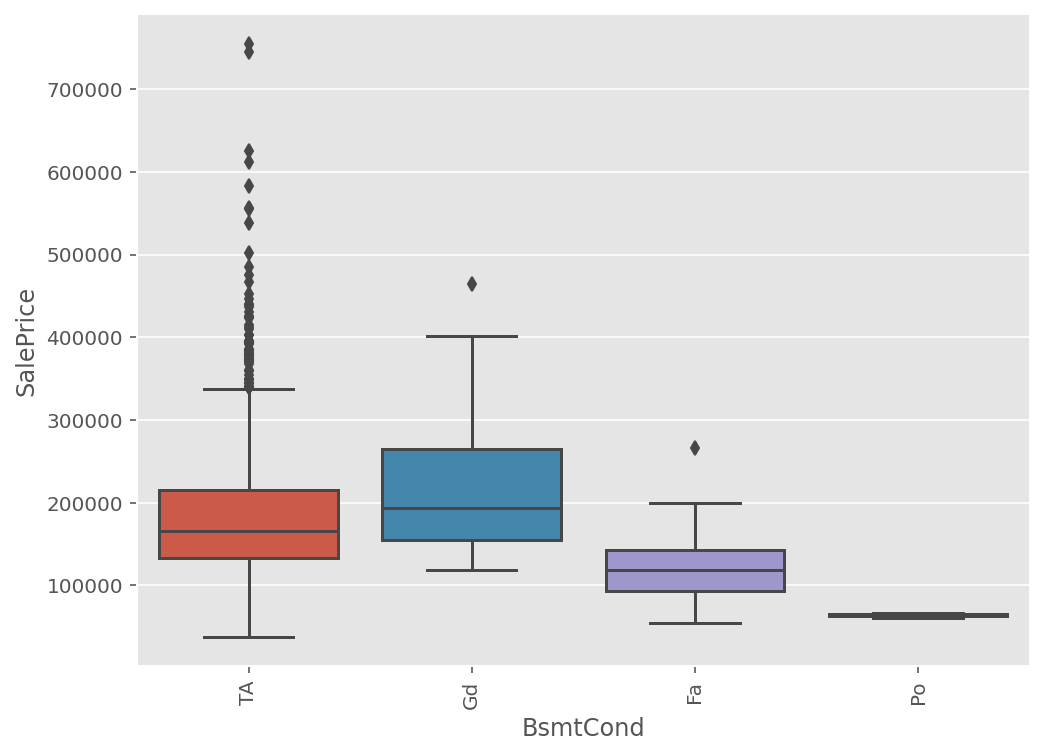

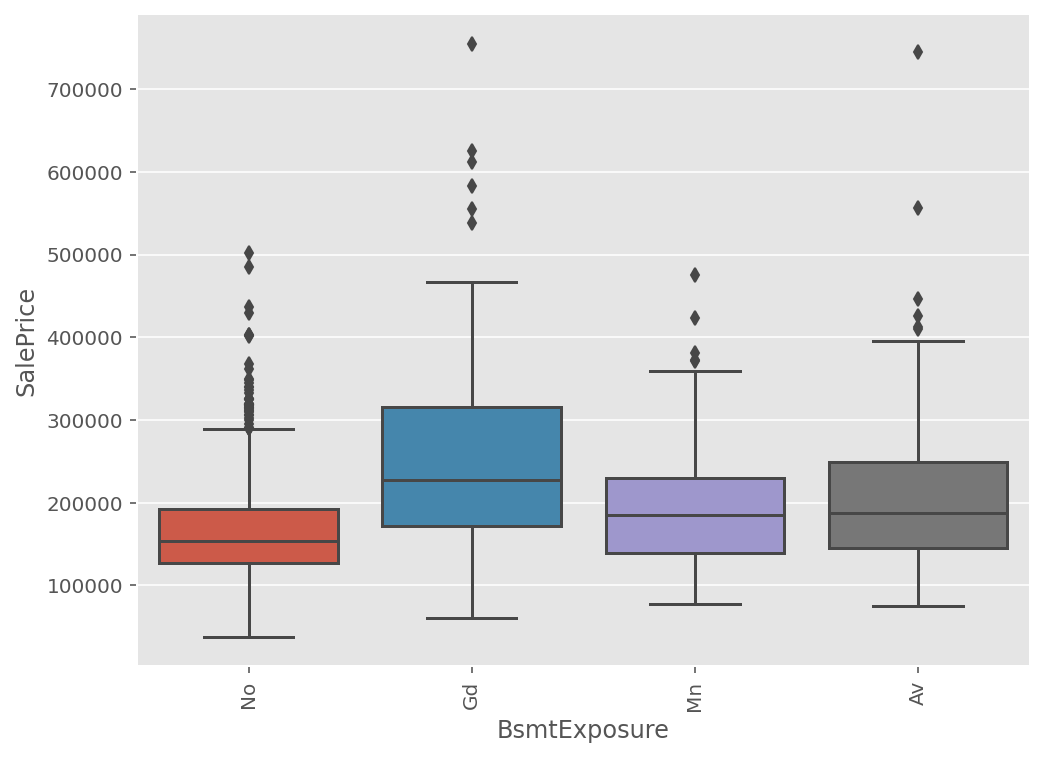

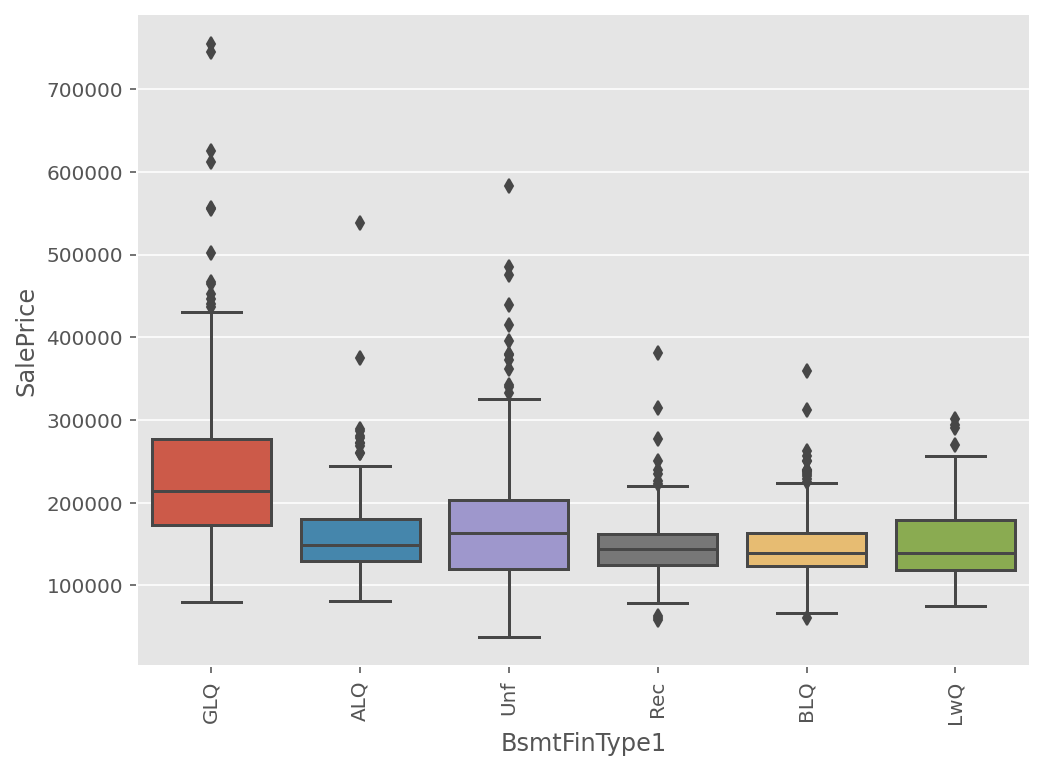

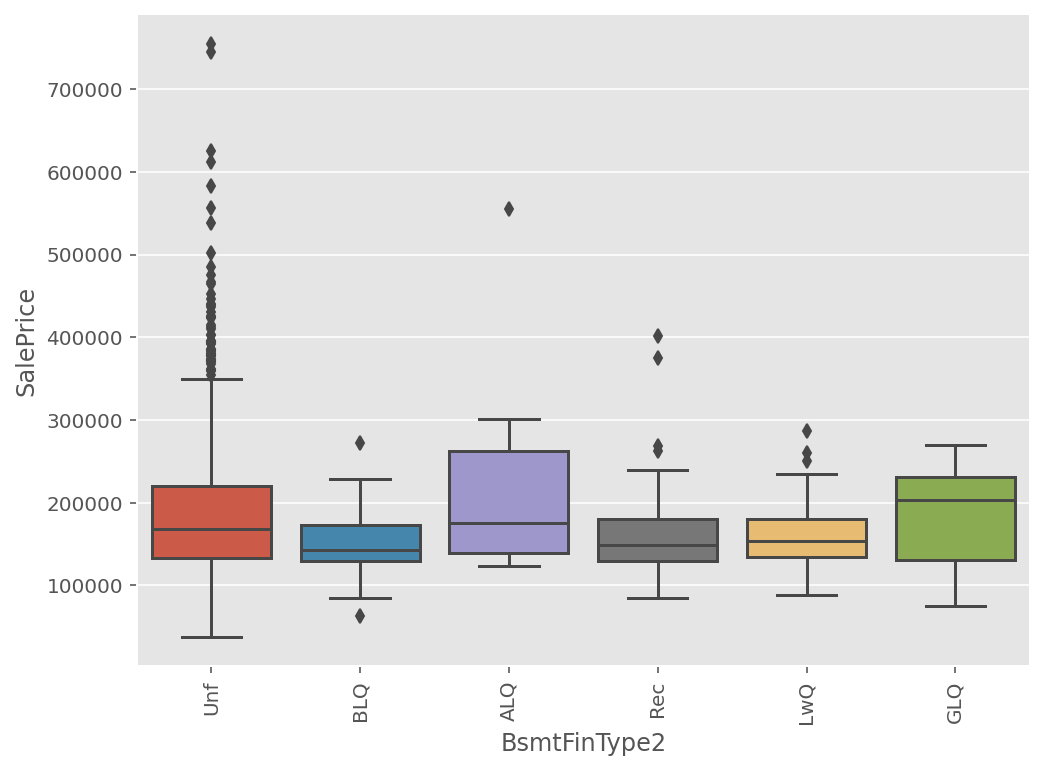

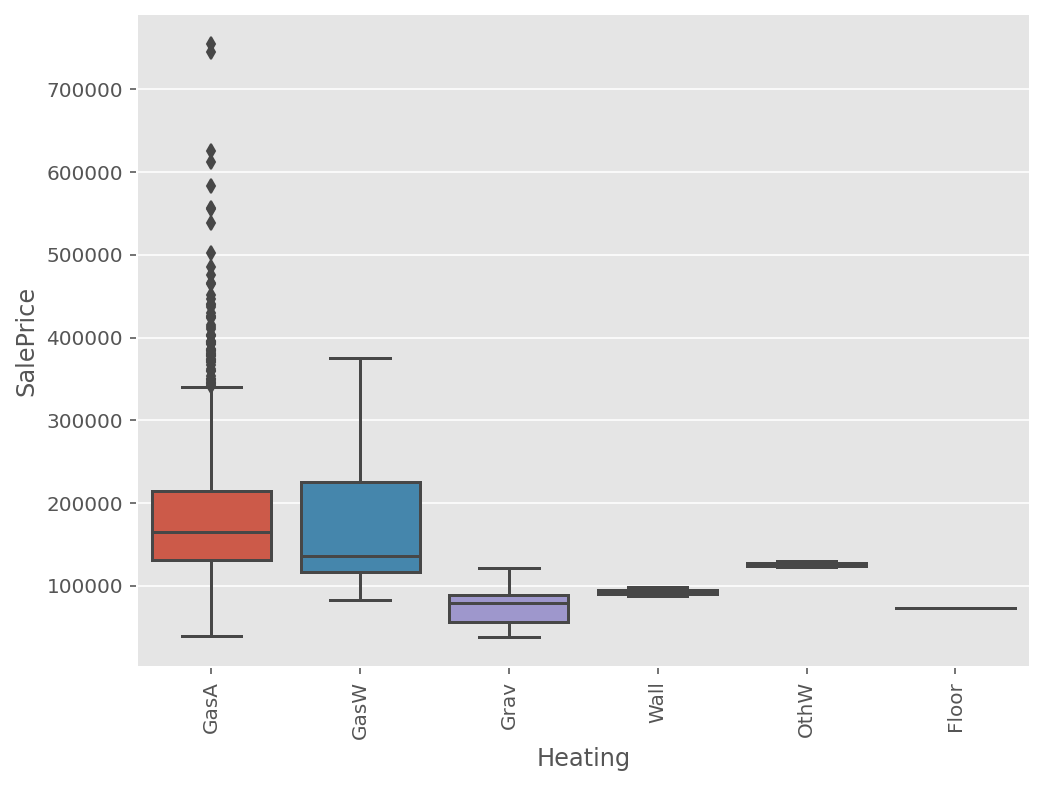

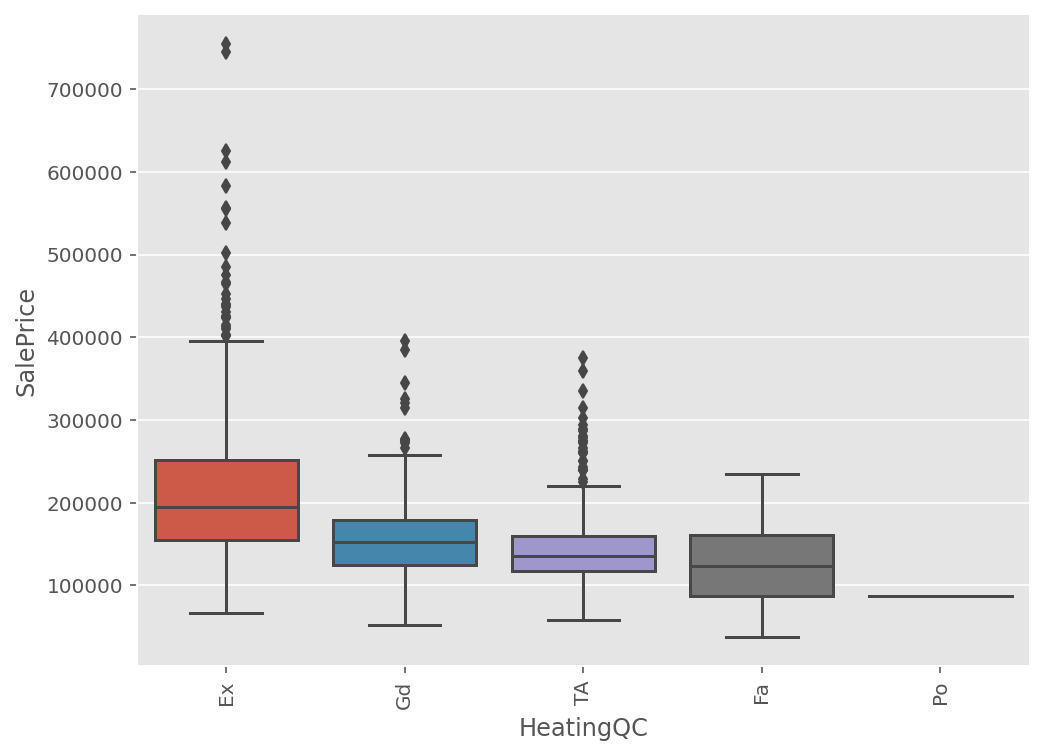

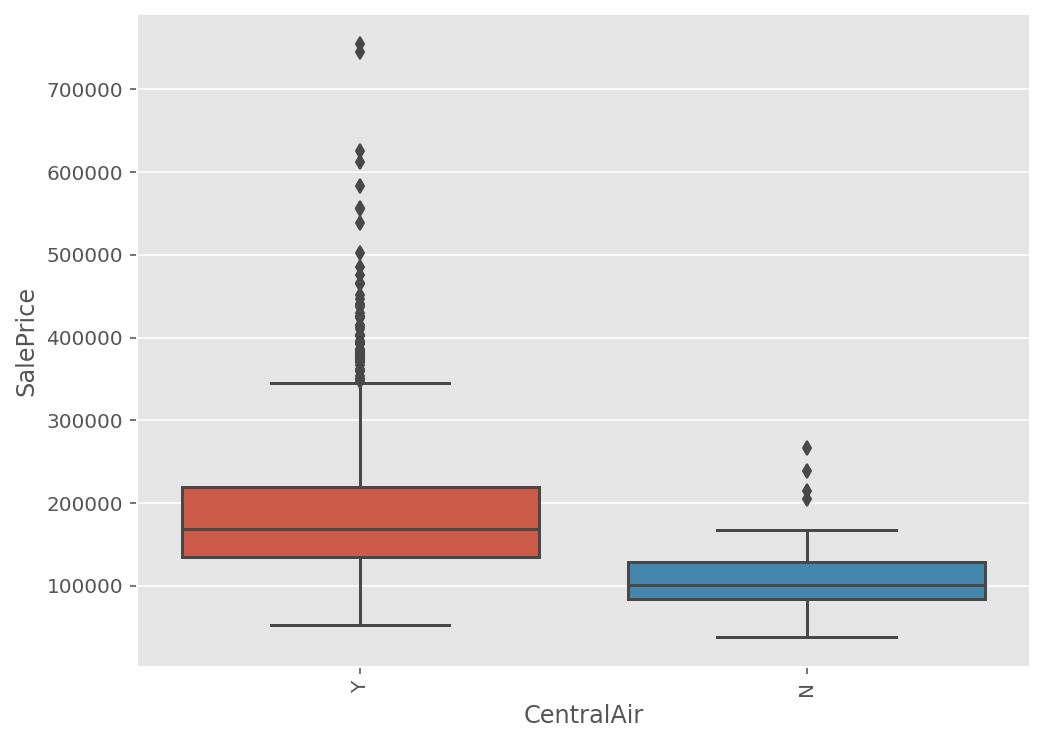

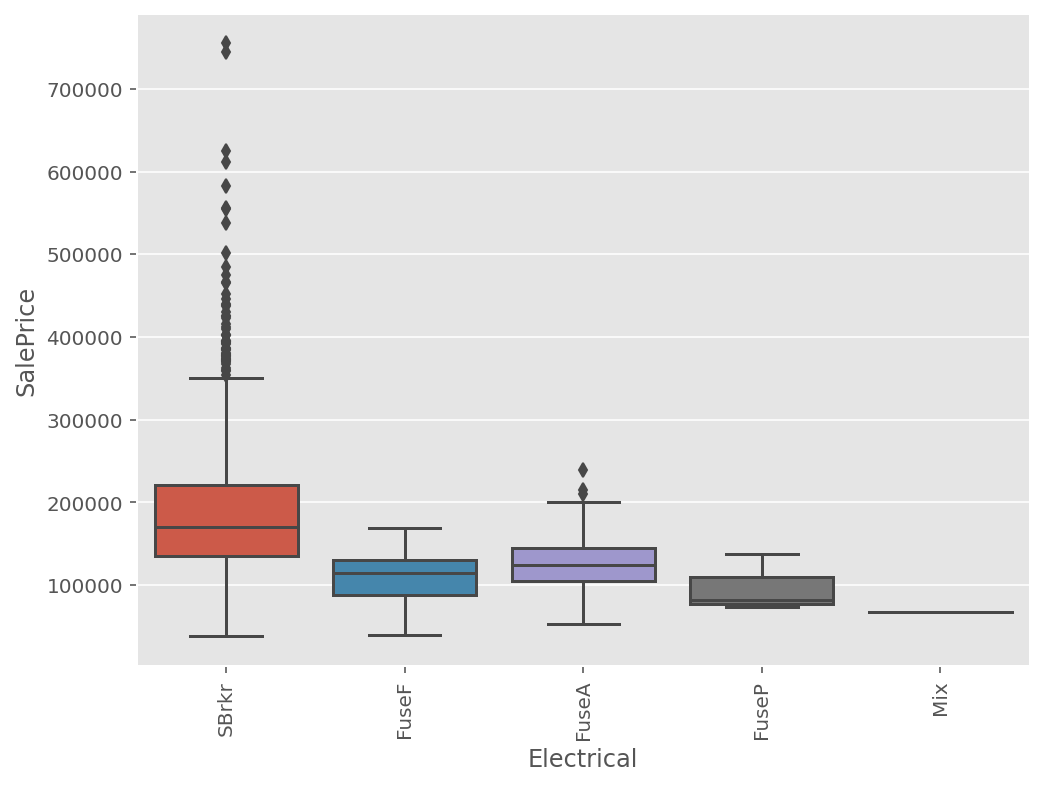

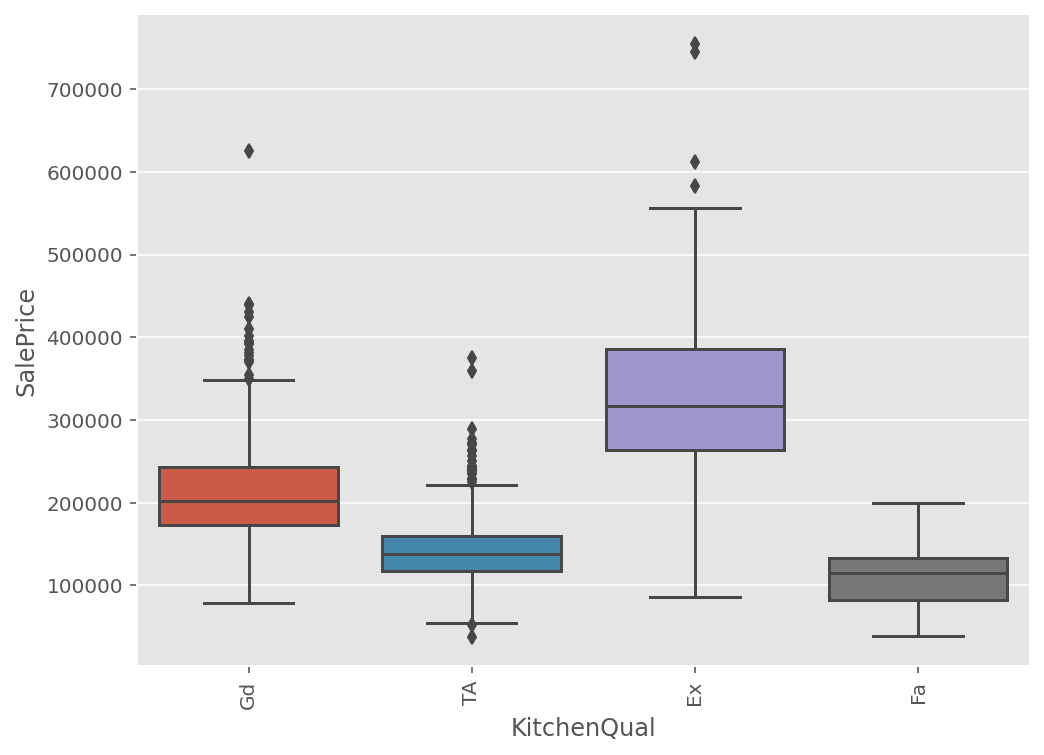

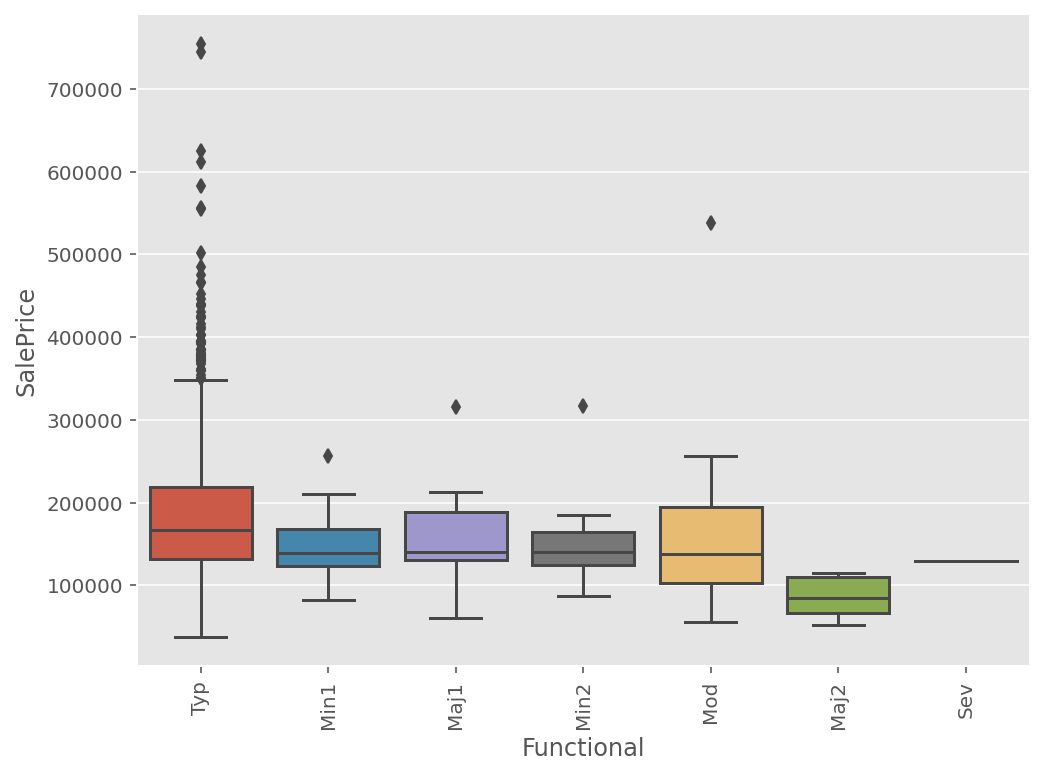

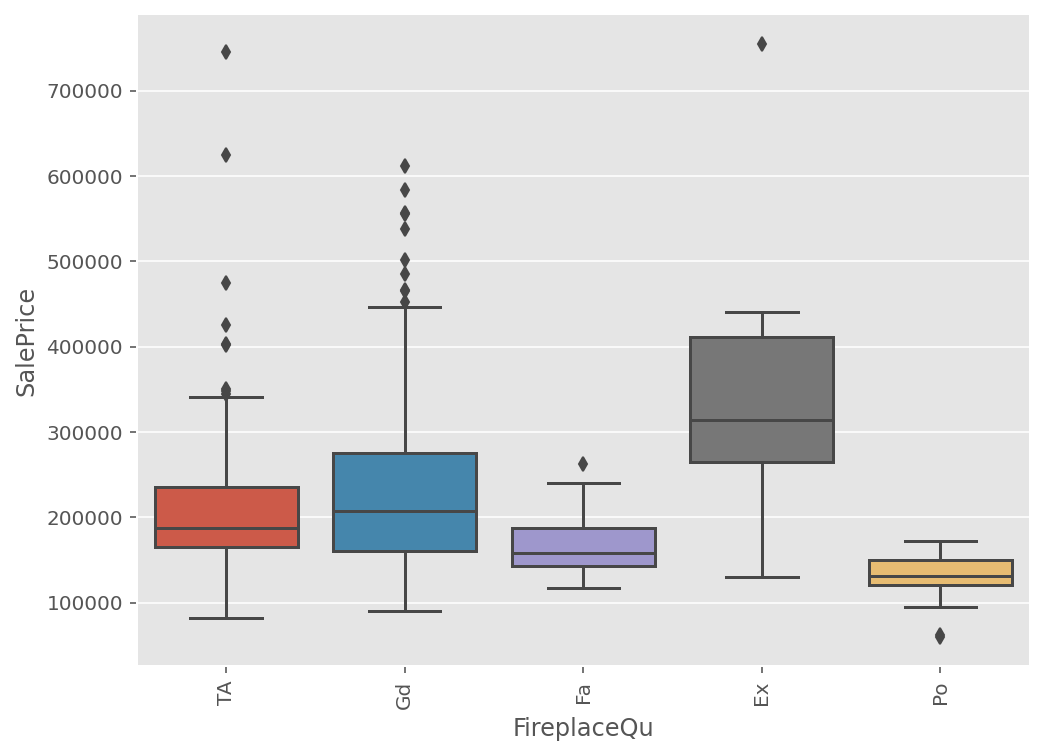

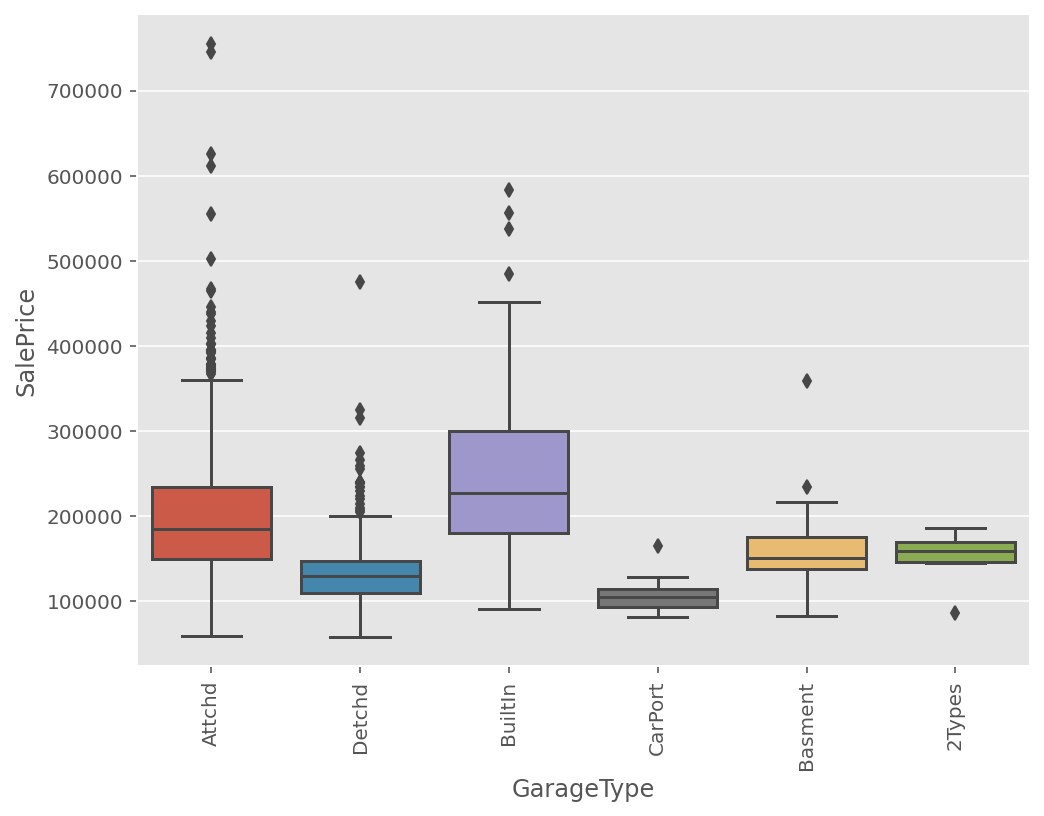

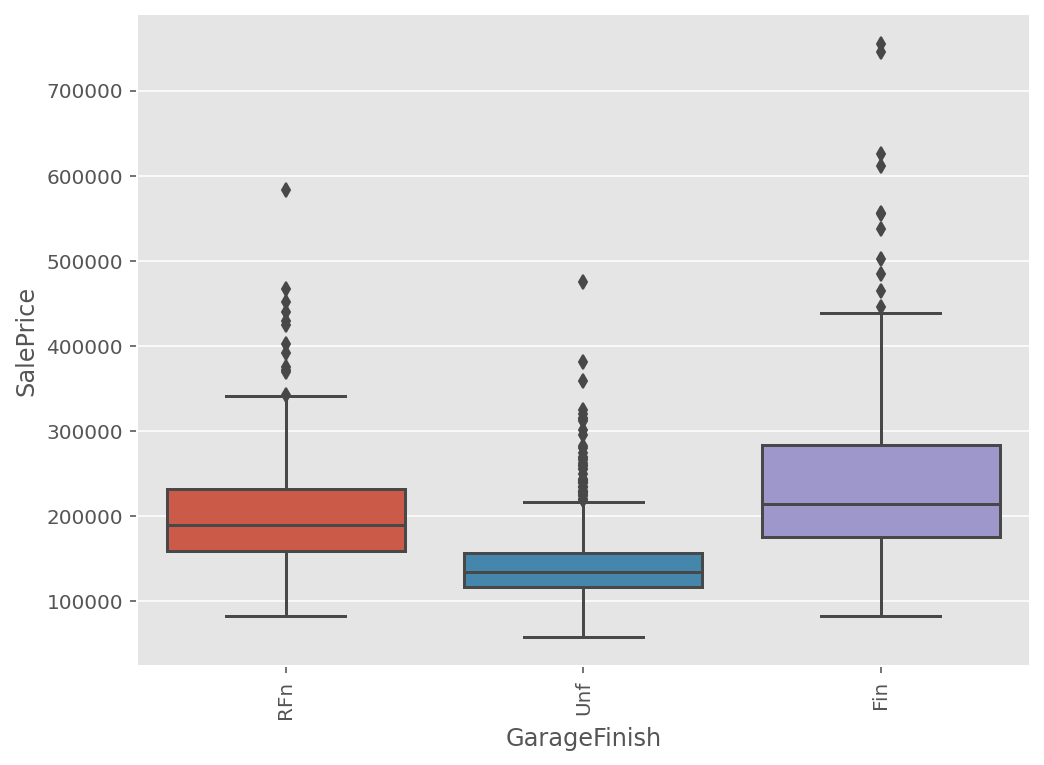

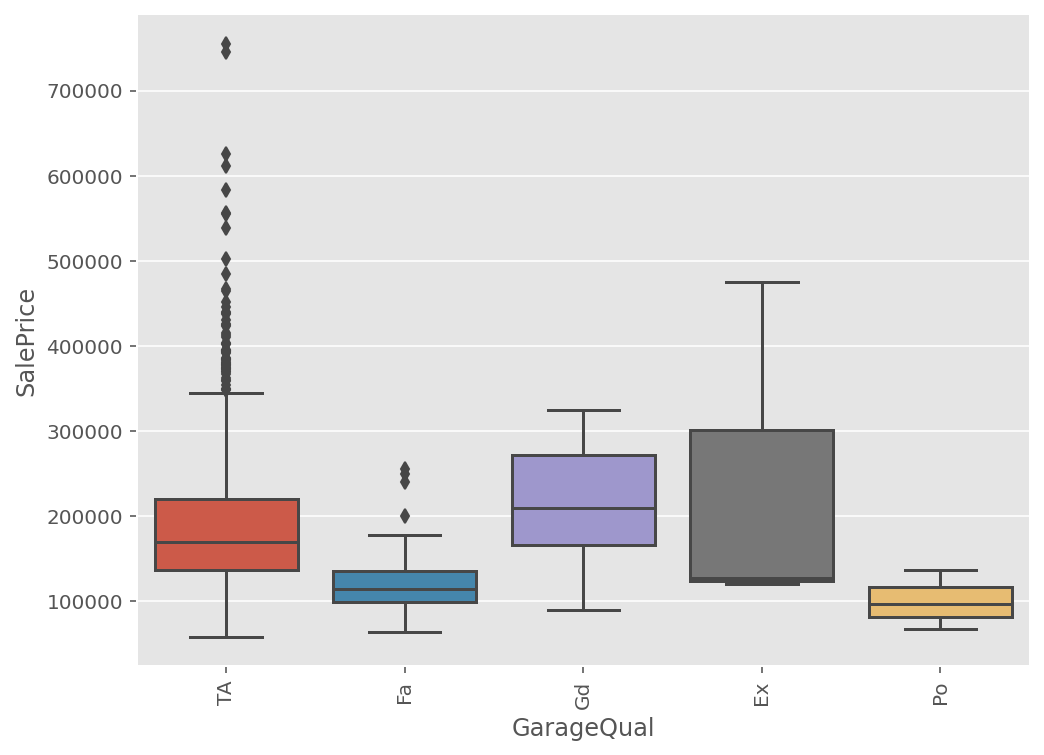

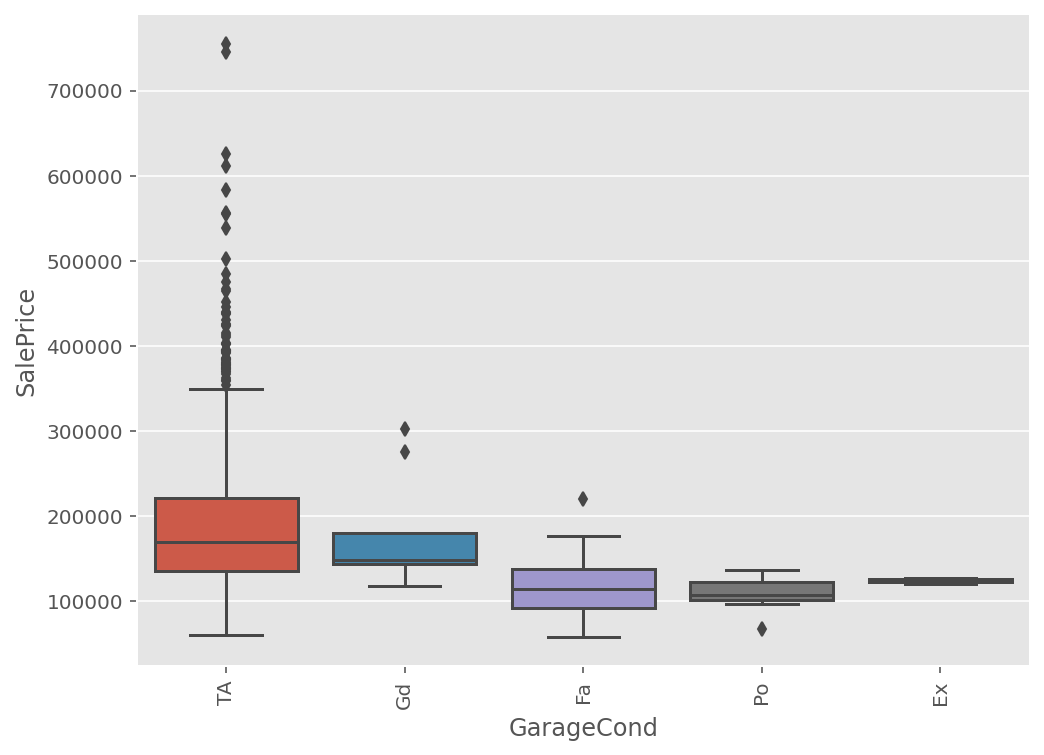

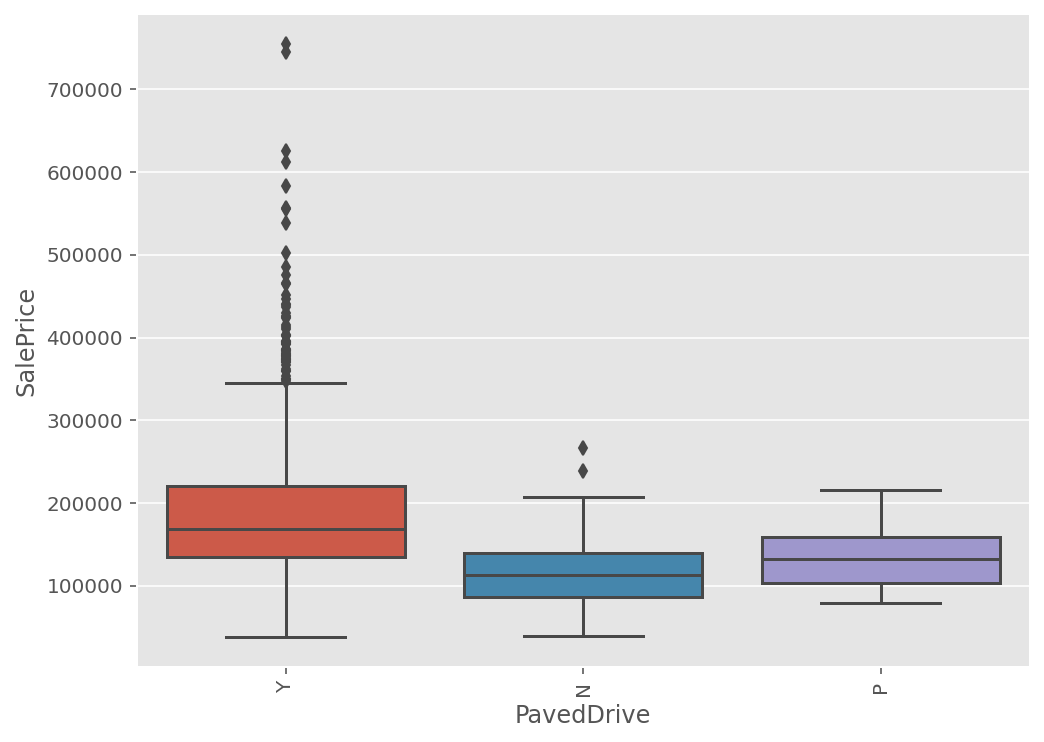

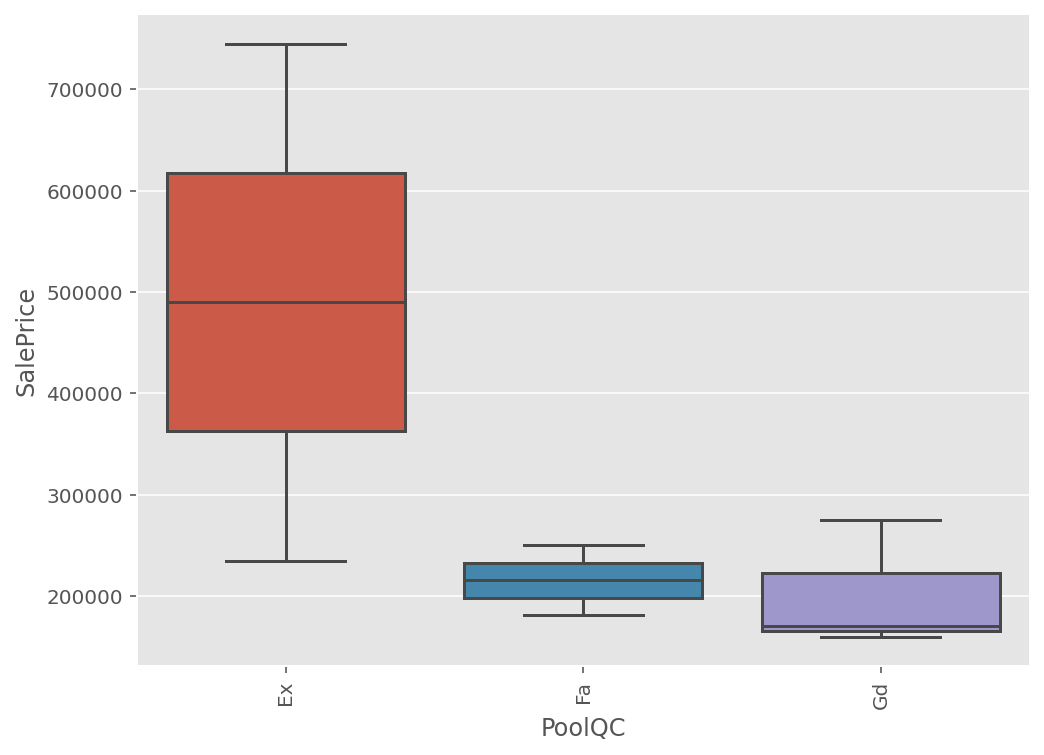

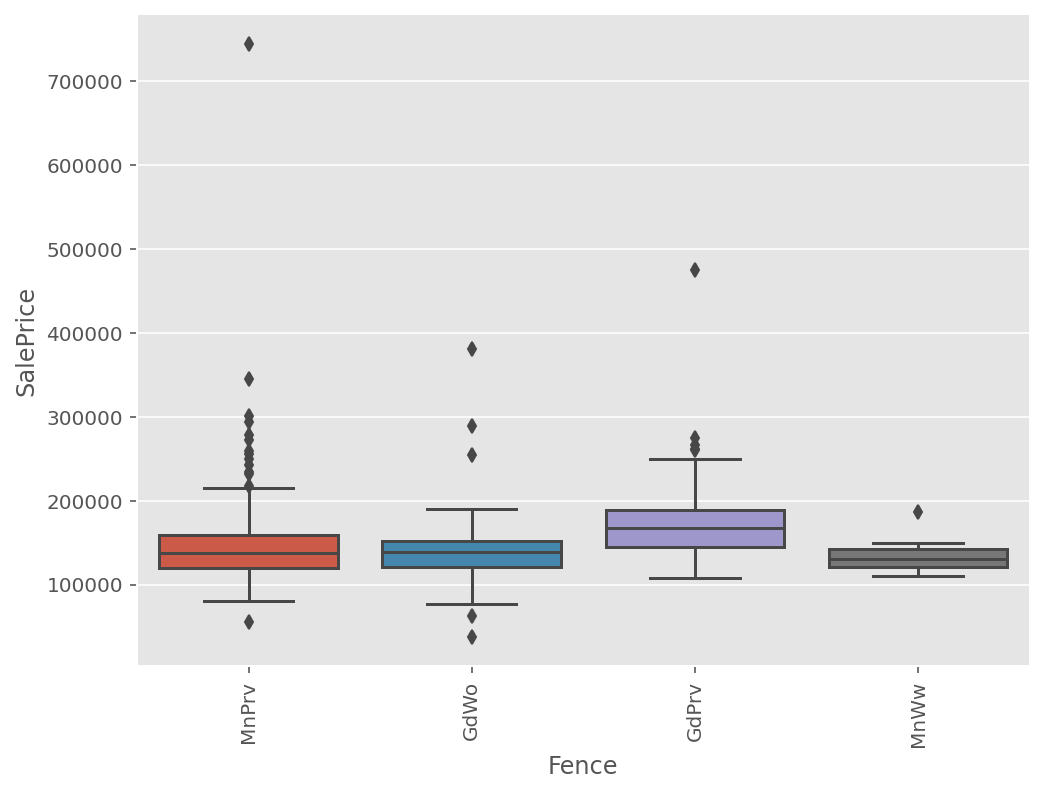

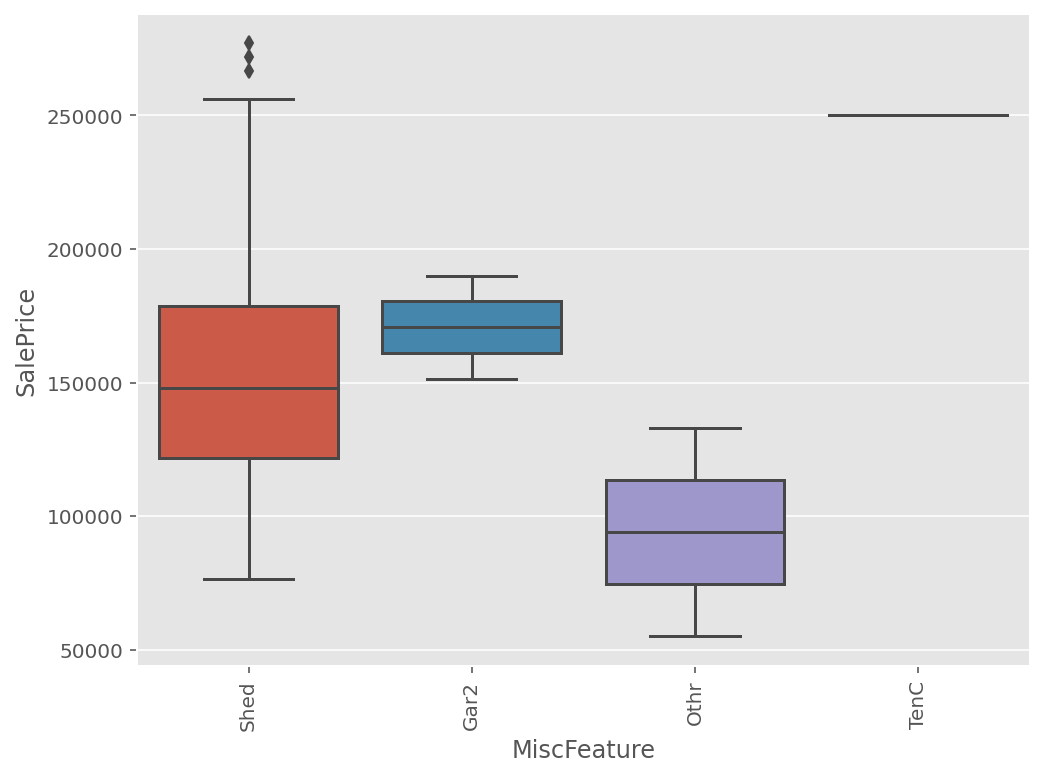

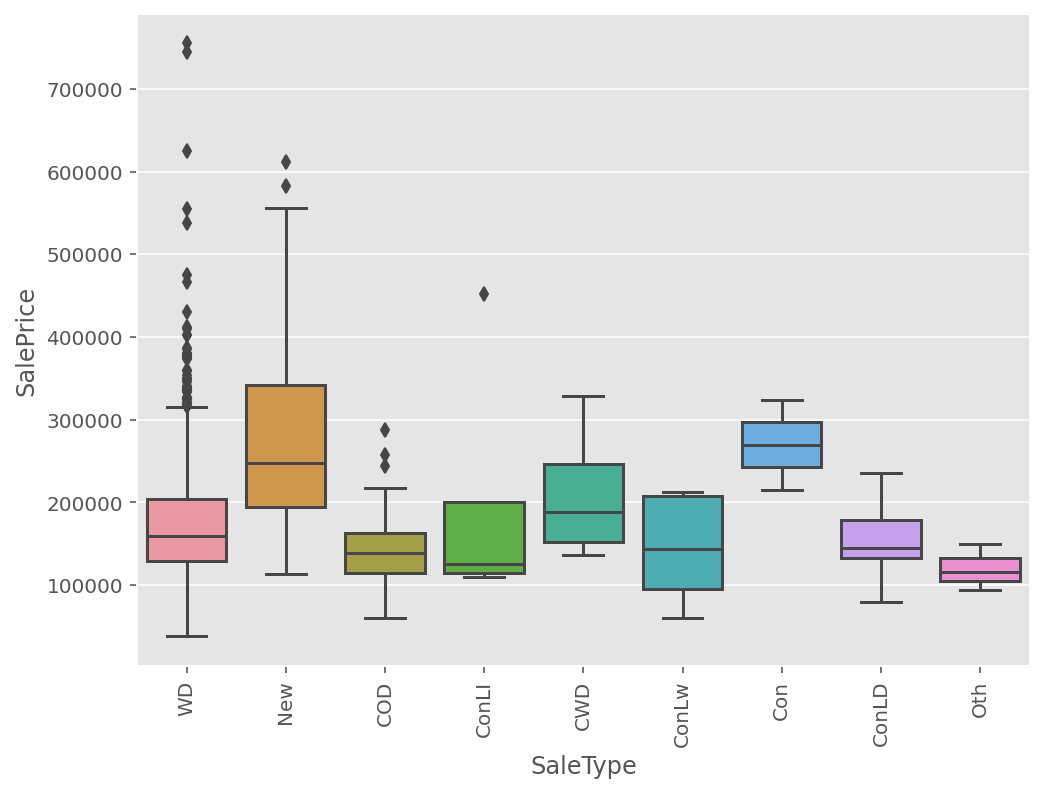

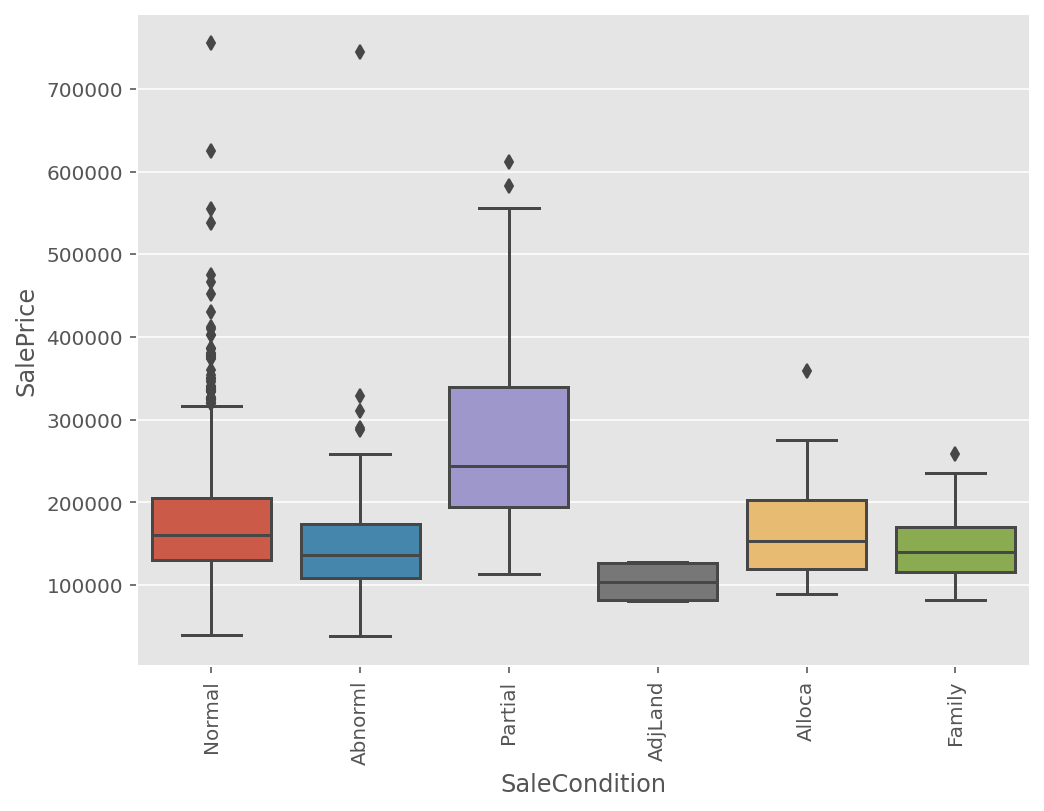

In [9]:
plot_categorical(categorical_columns, df['SalePrice'], df)

#### Checking price against numerical values:

In [10]:
def plot_numerical(numerical_column_names, y, df):
    for i in range(len(numerical_column_names)):
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.scatterplot(x = df[numerical_column_names[i]], y=y, data=df)
        plt.show()

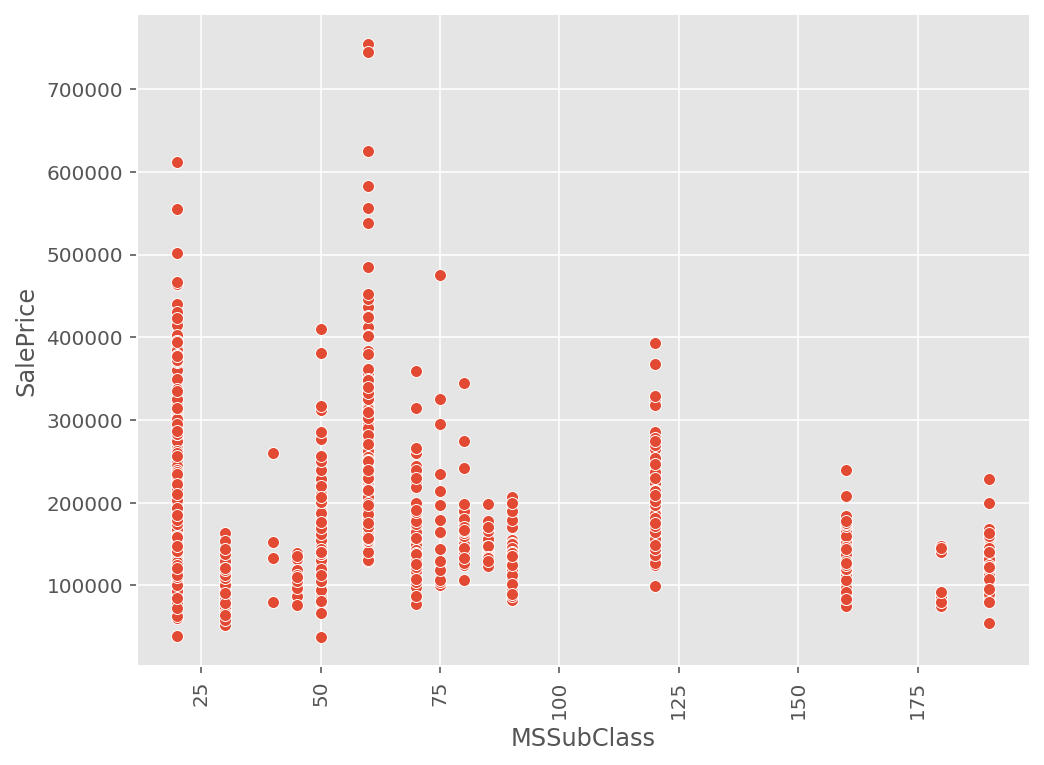

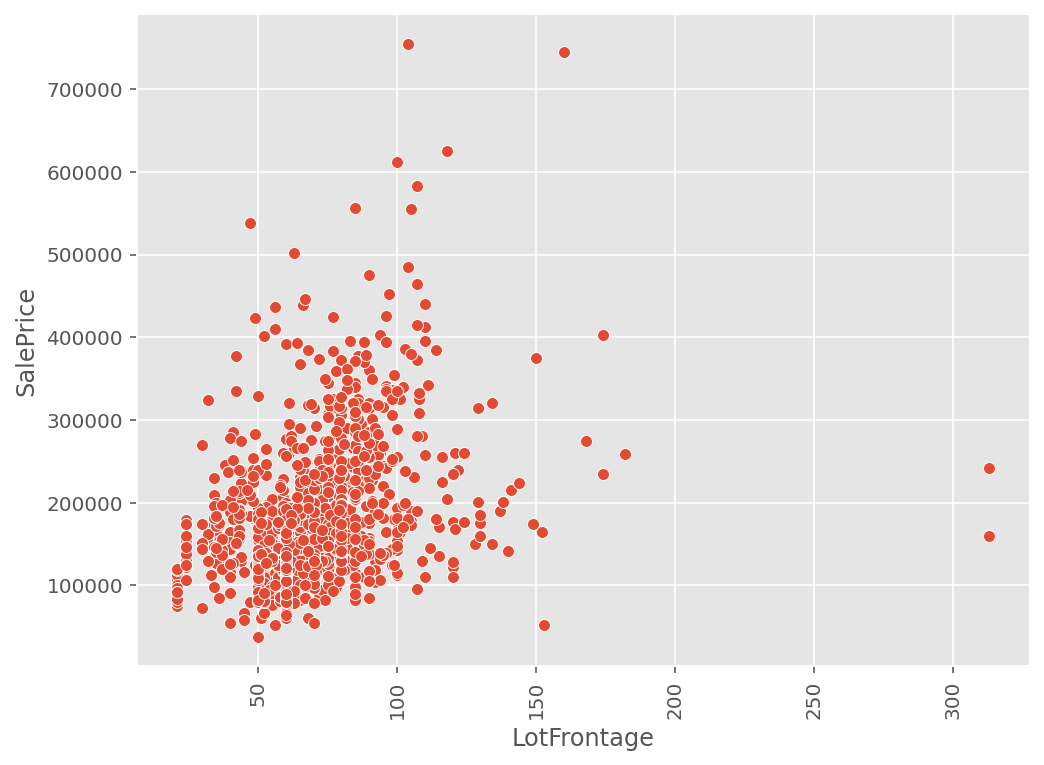

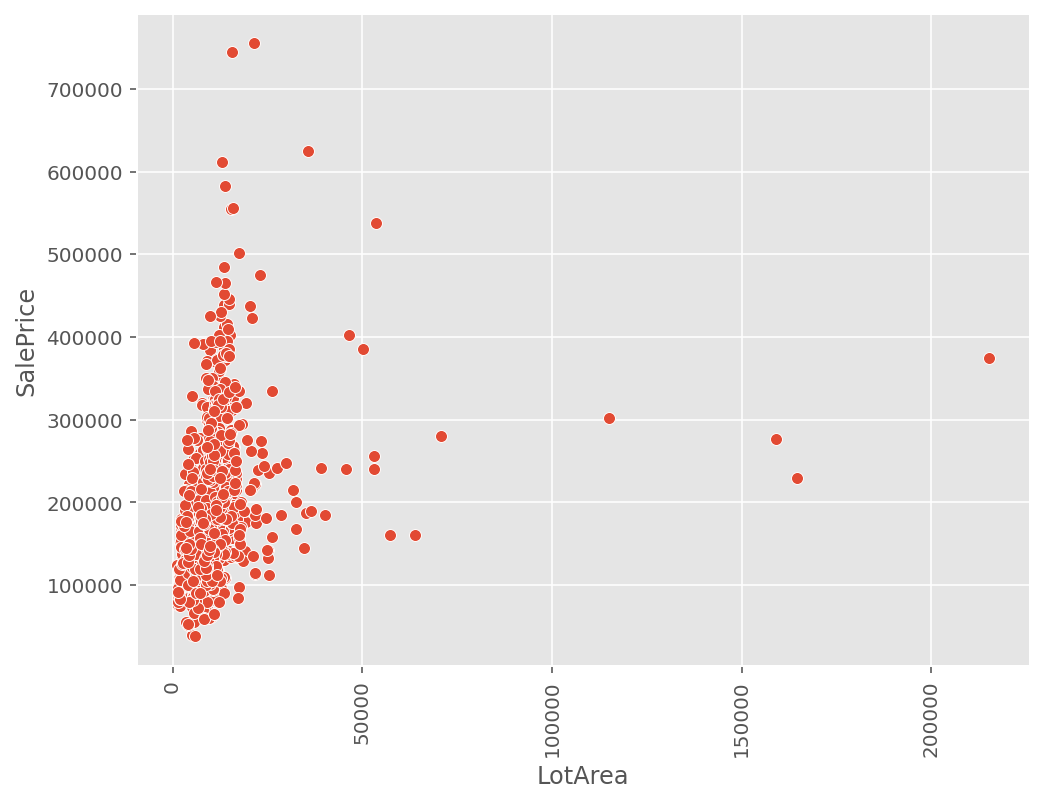

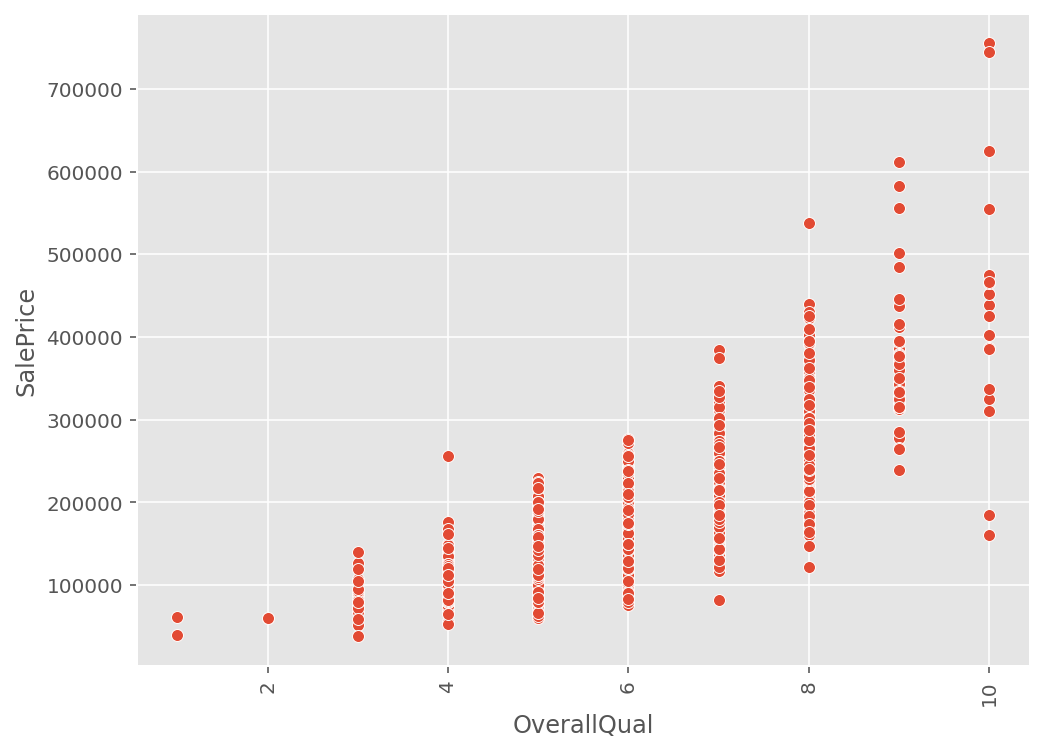

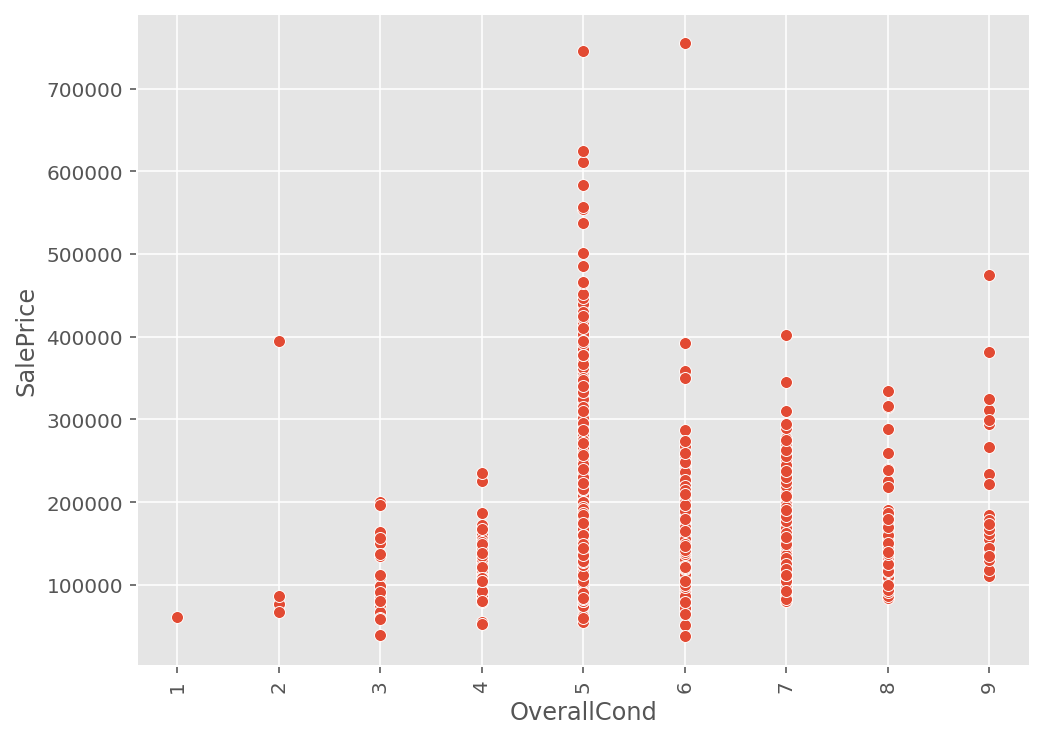

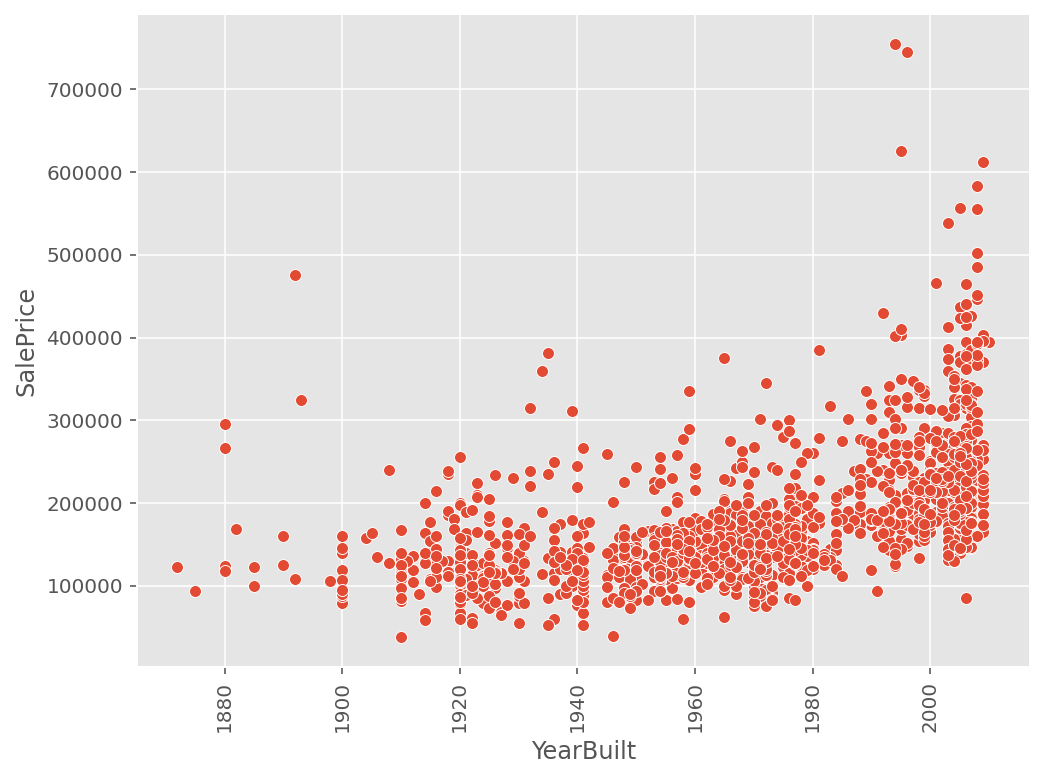

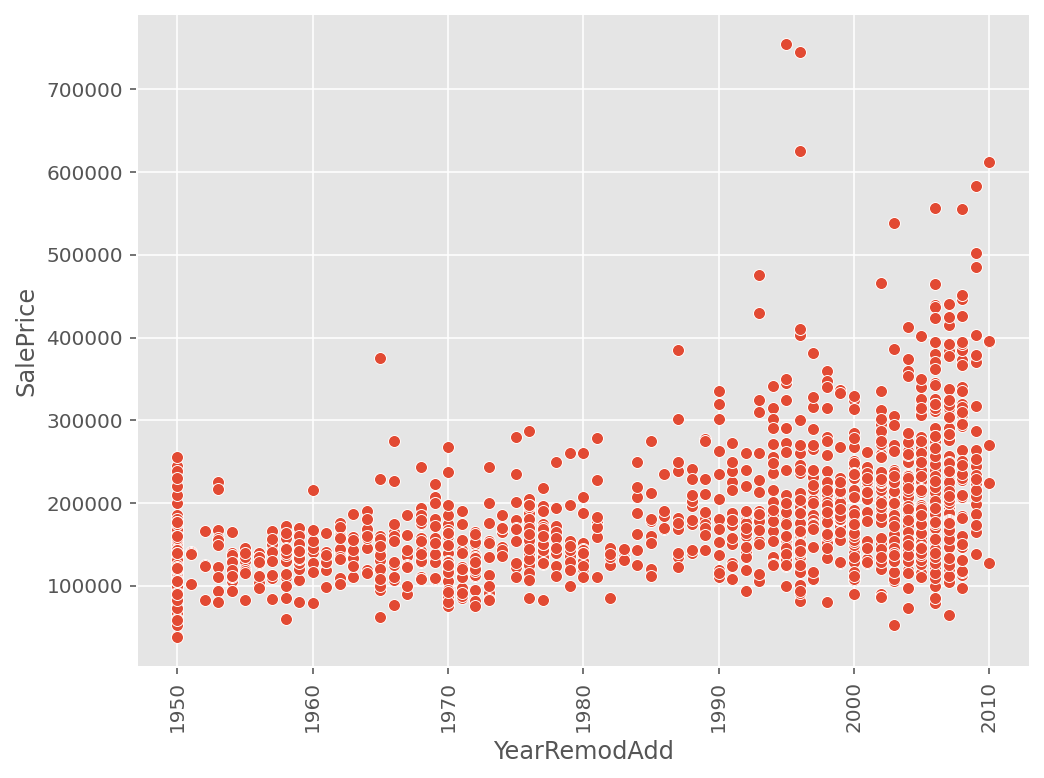

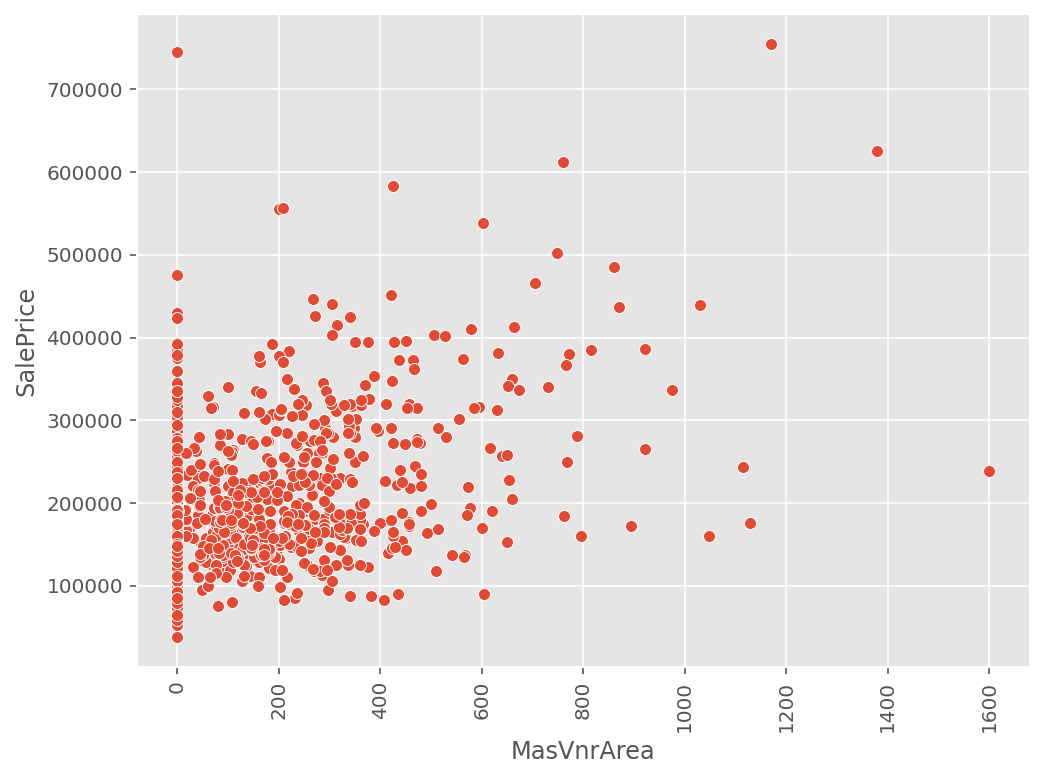

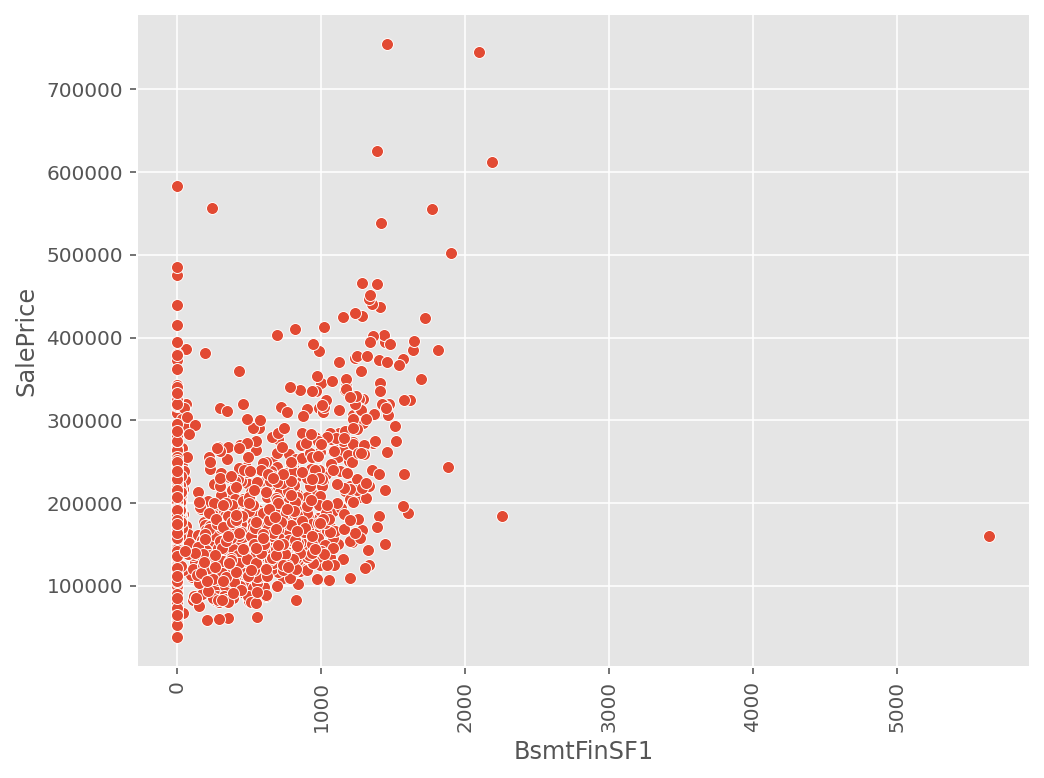

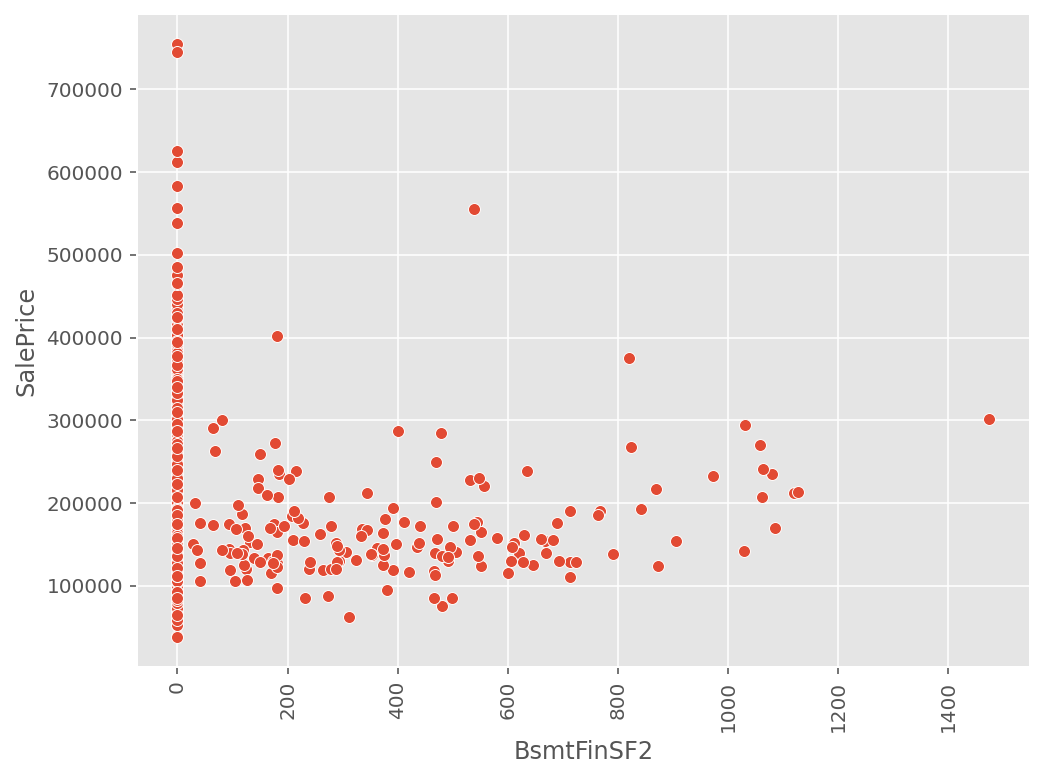

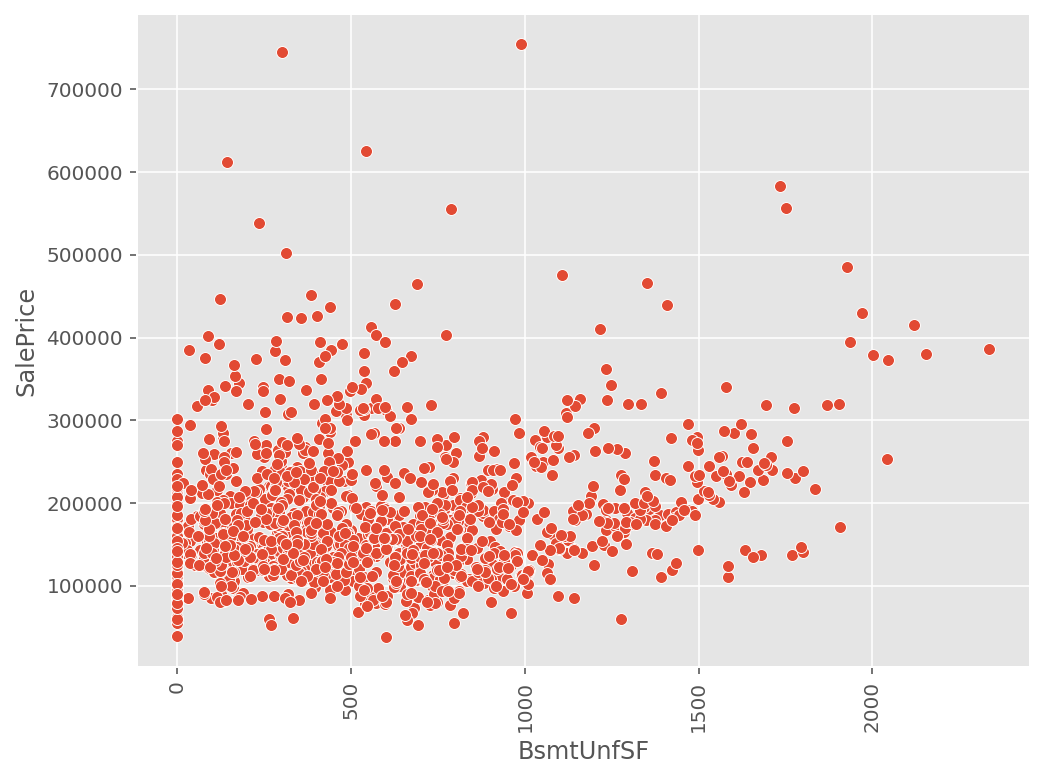

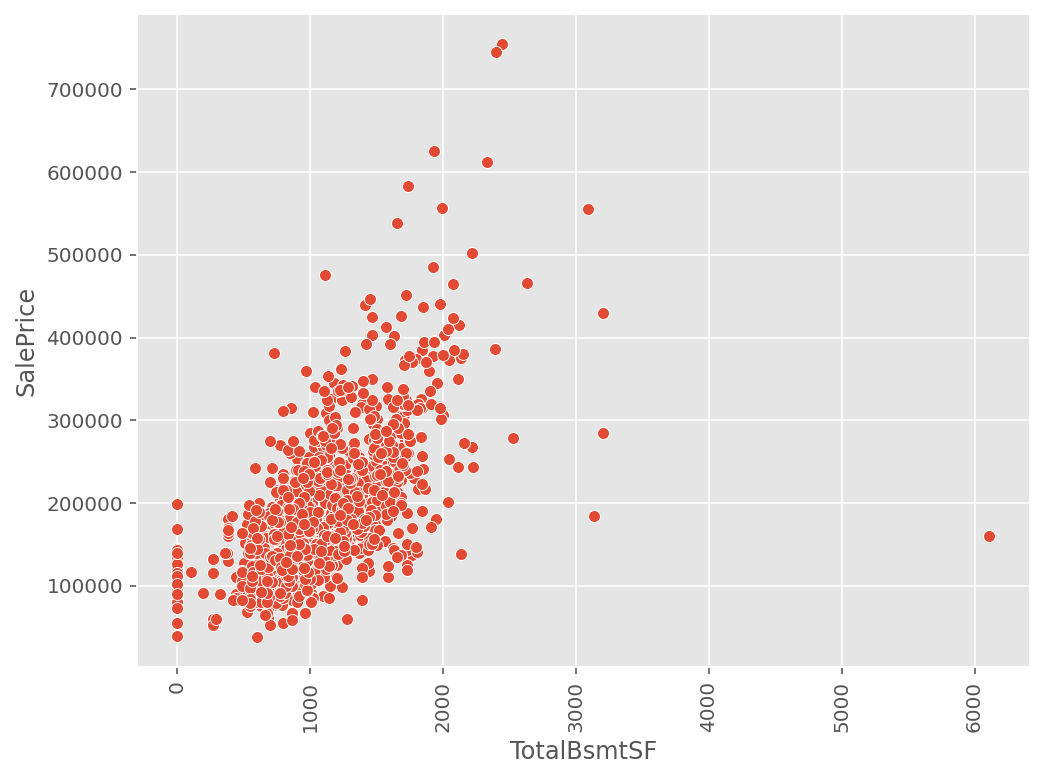

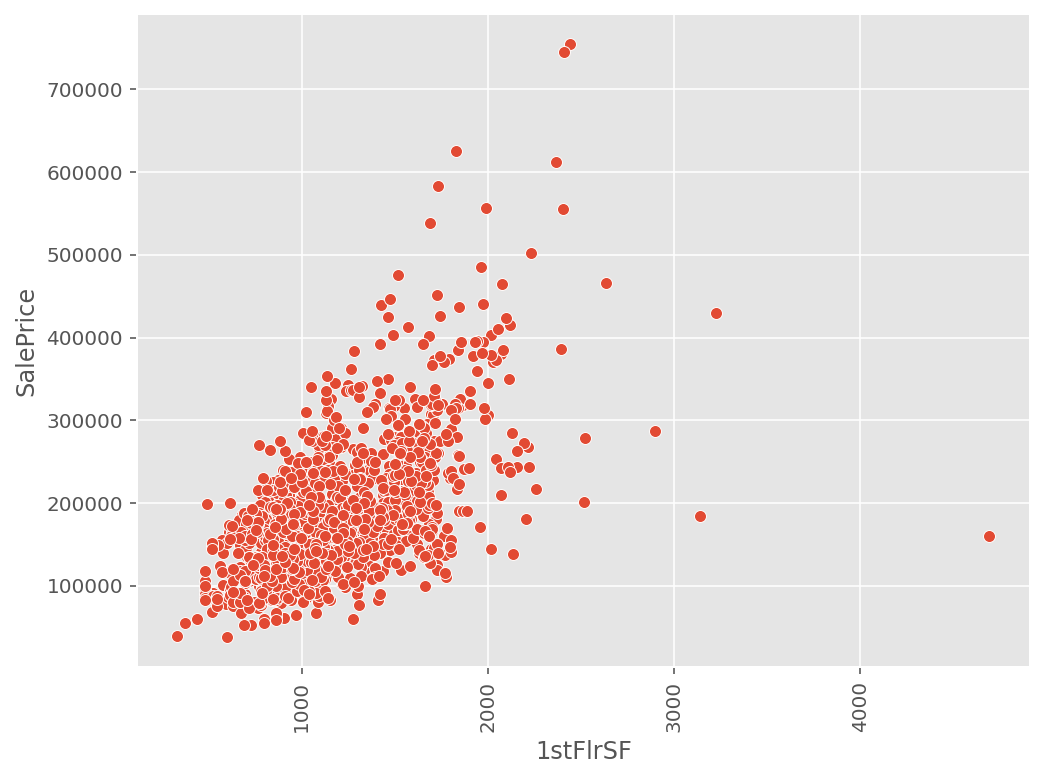

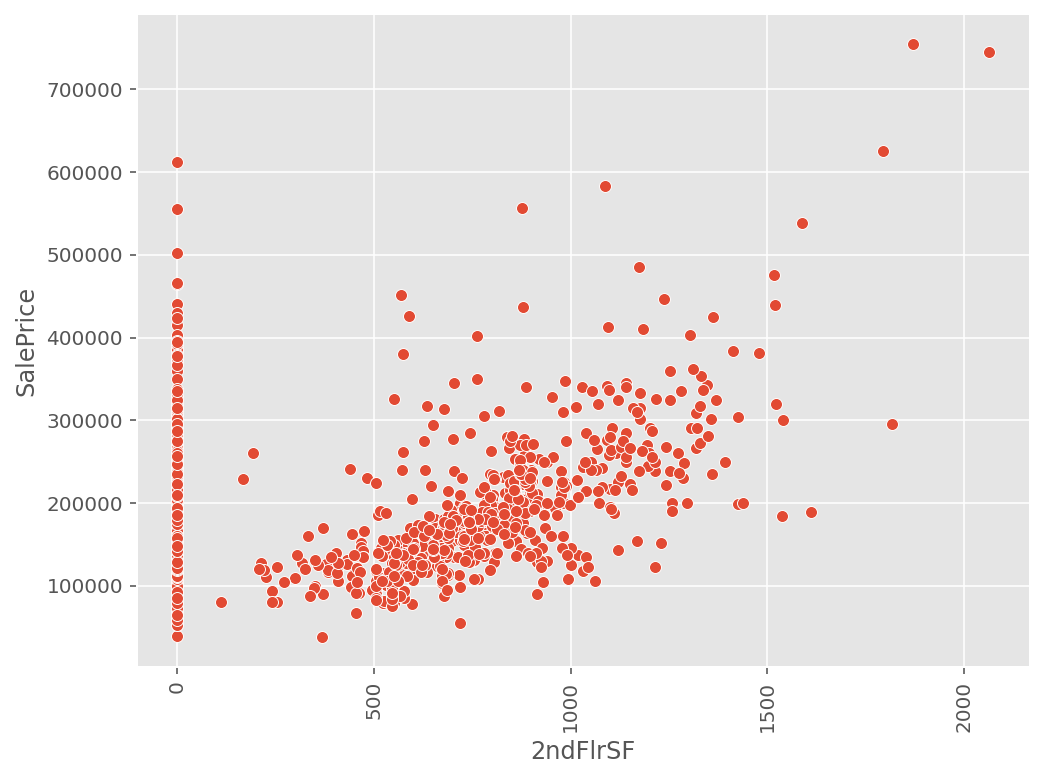

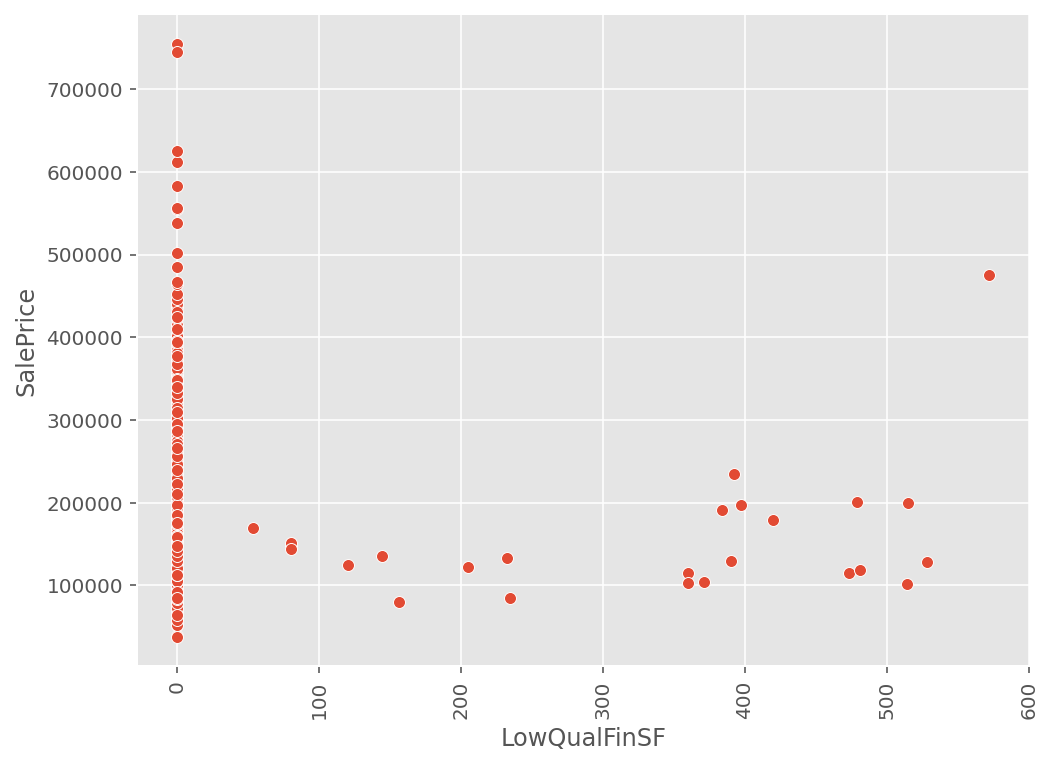

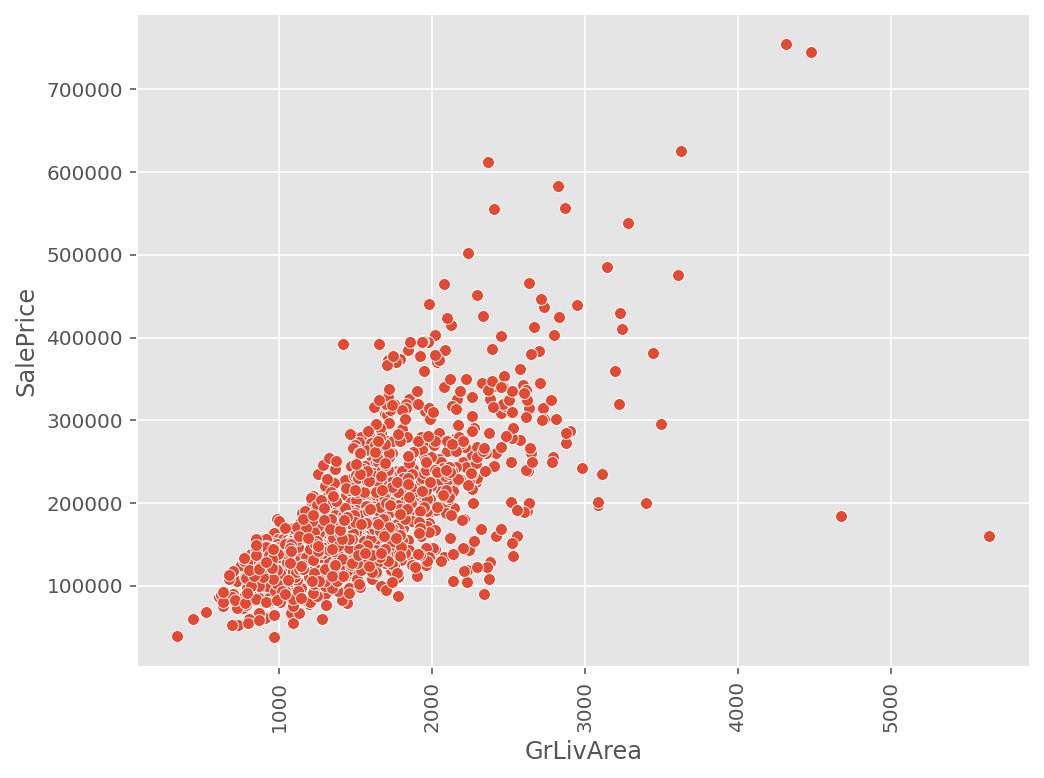

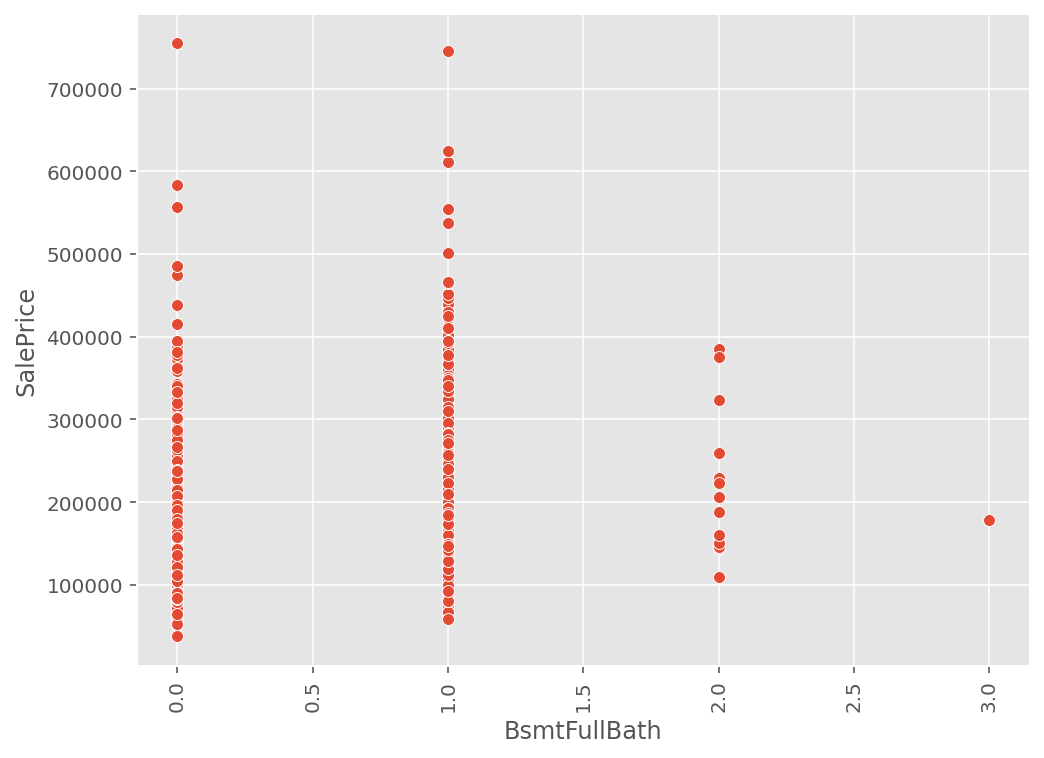

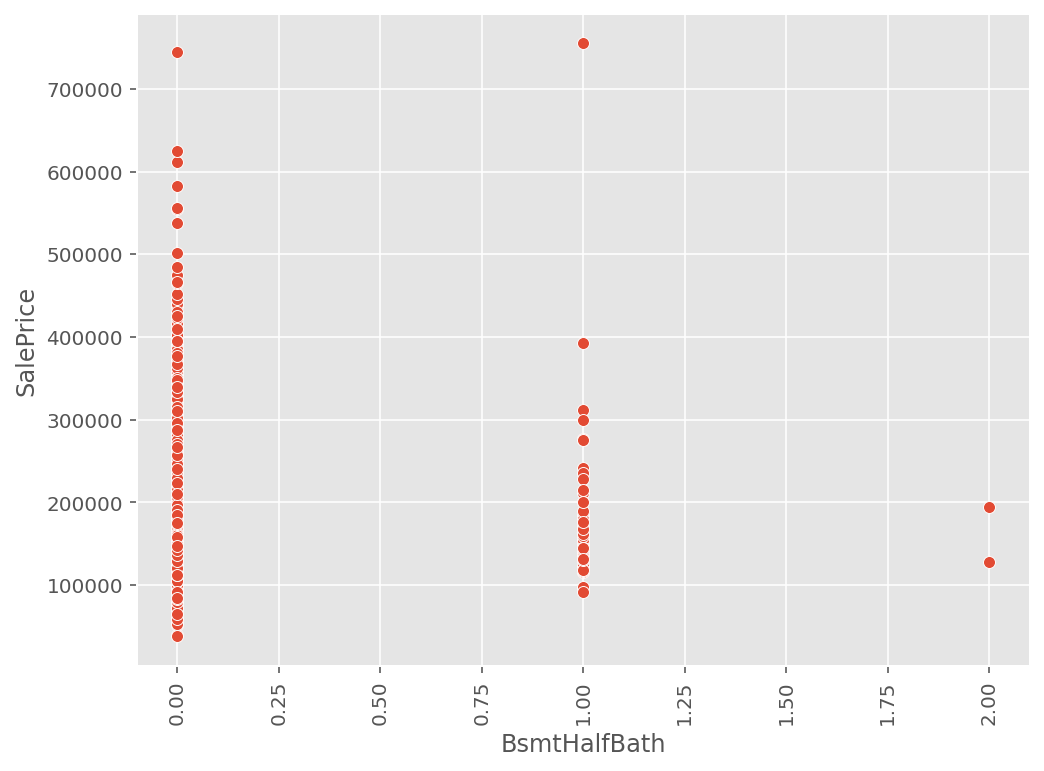

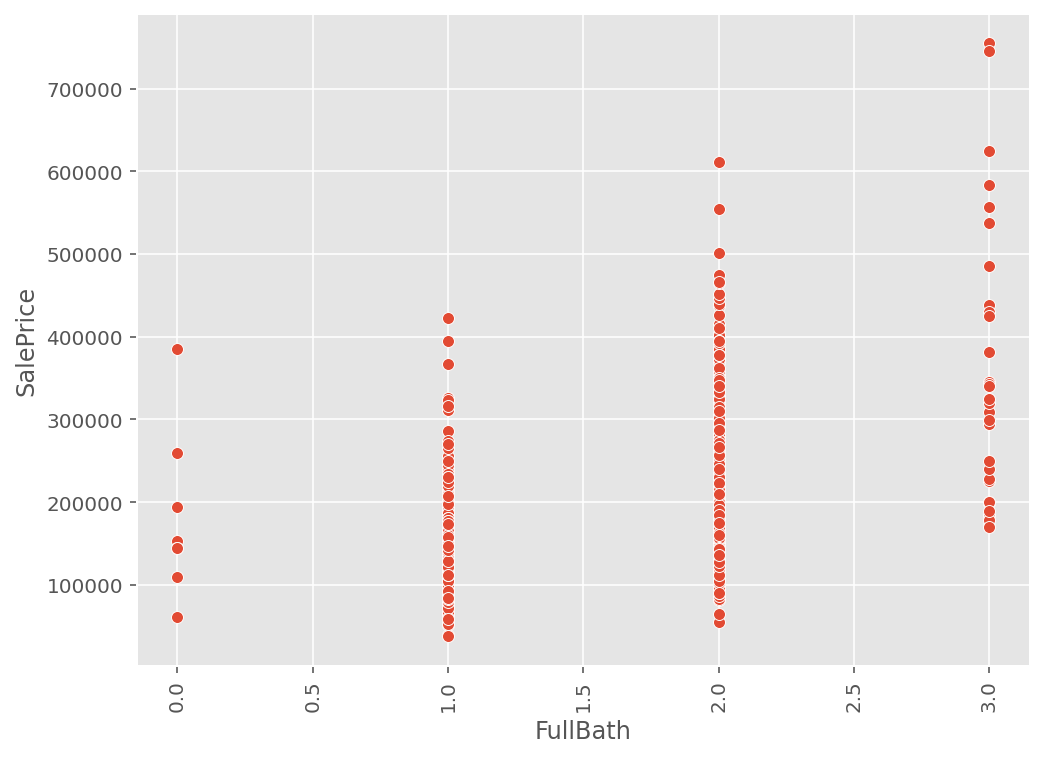

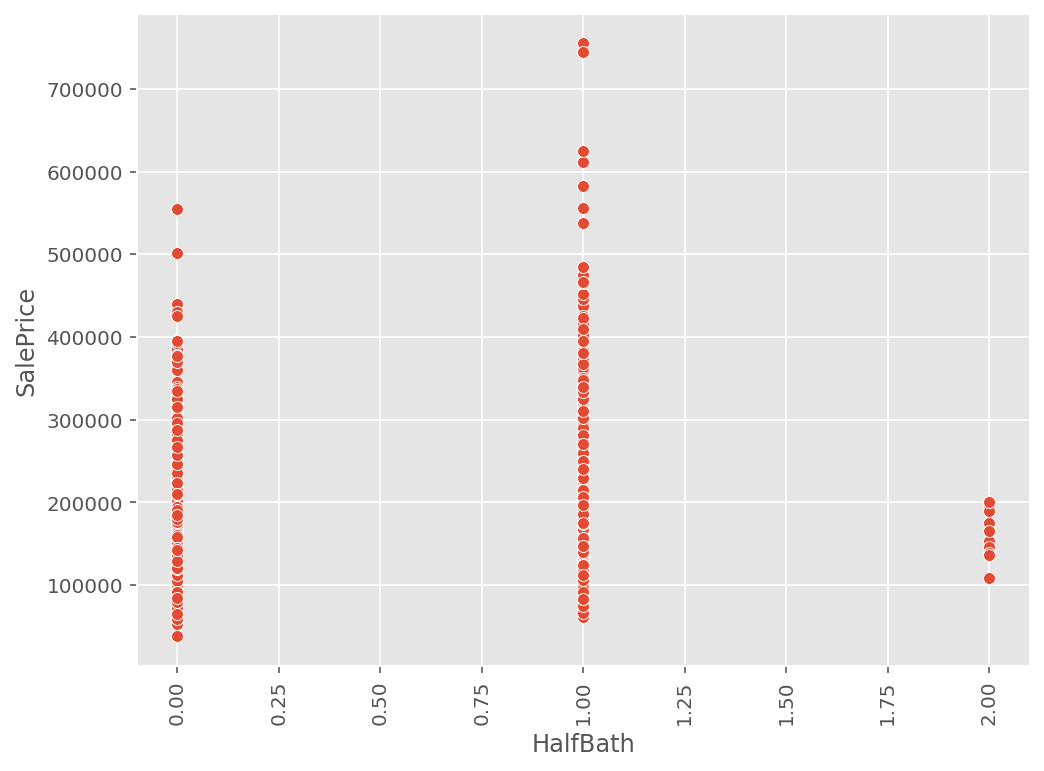

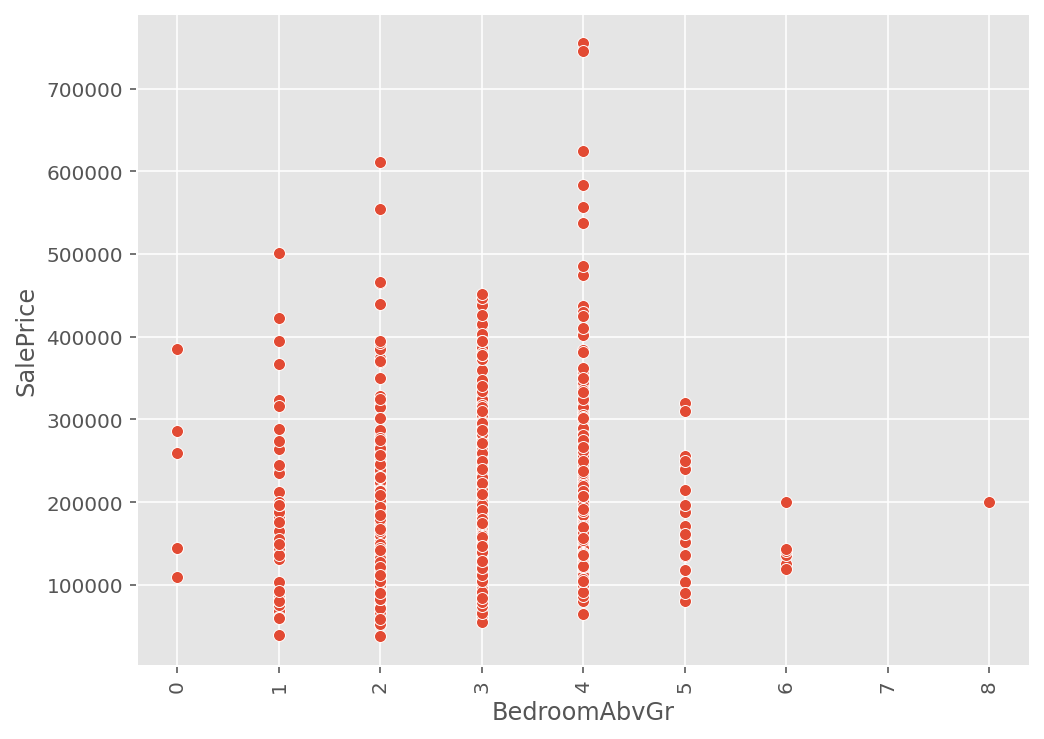

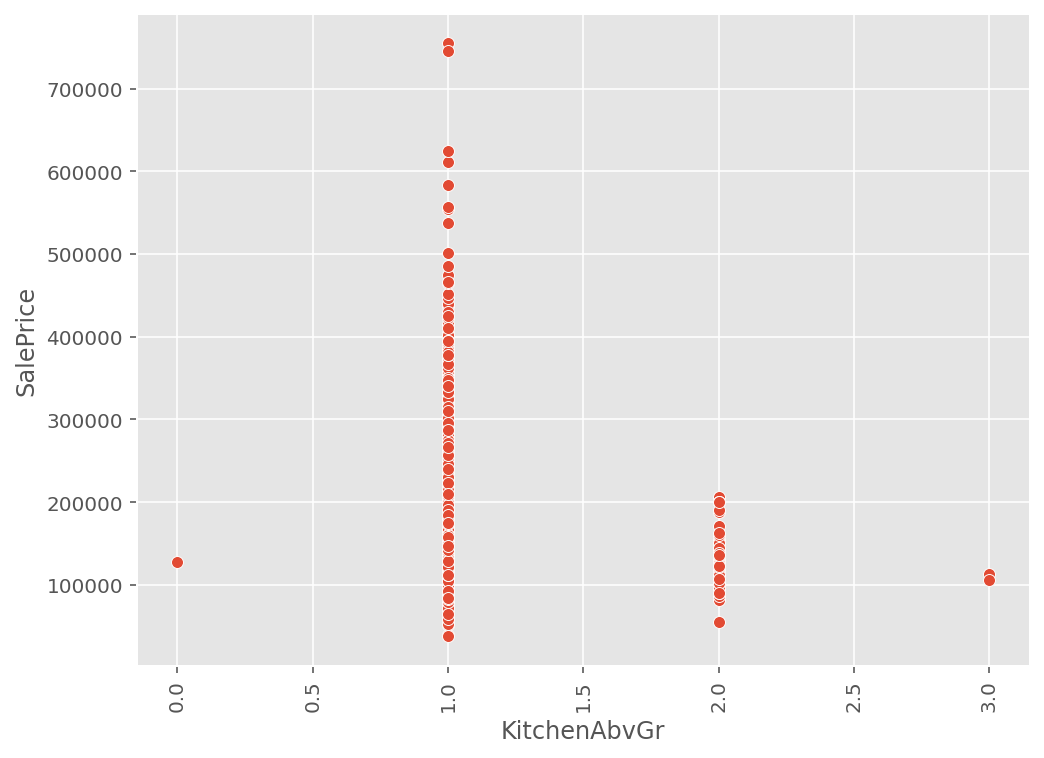

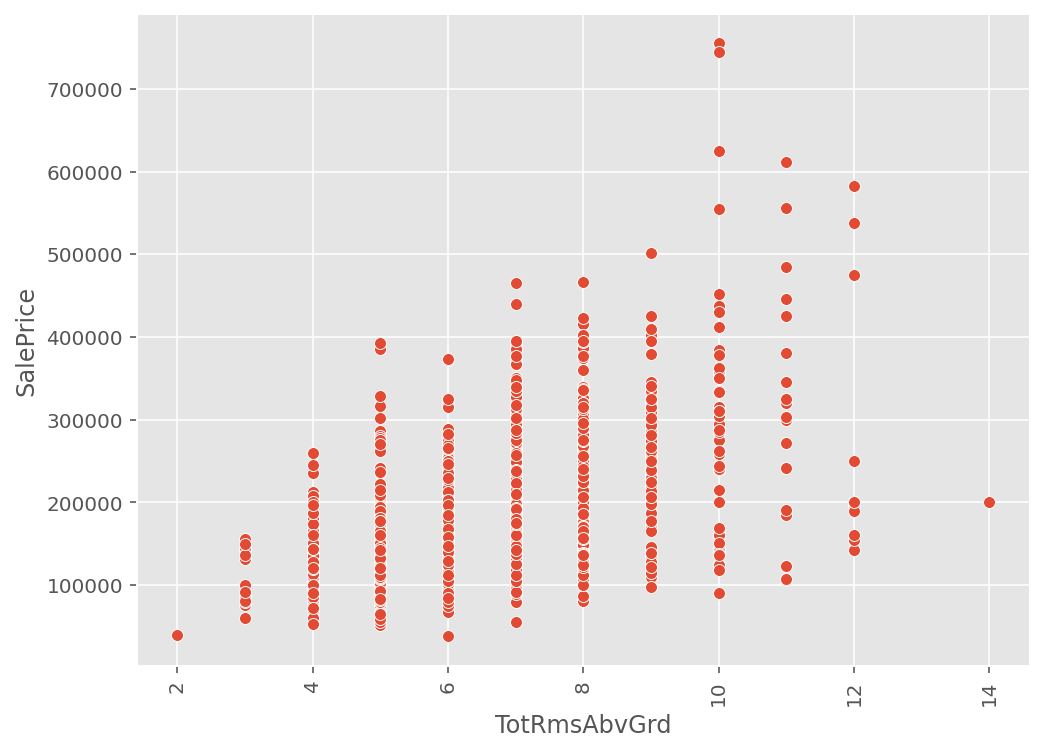

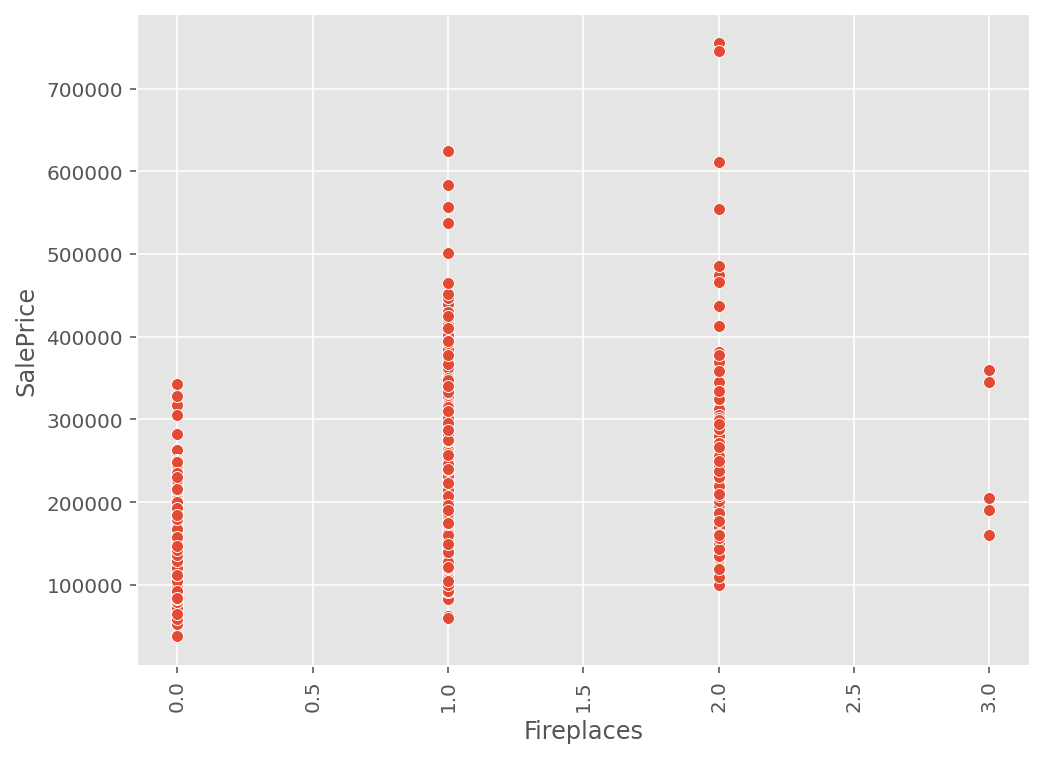

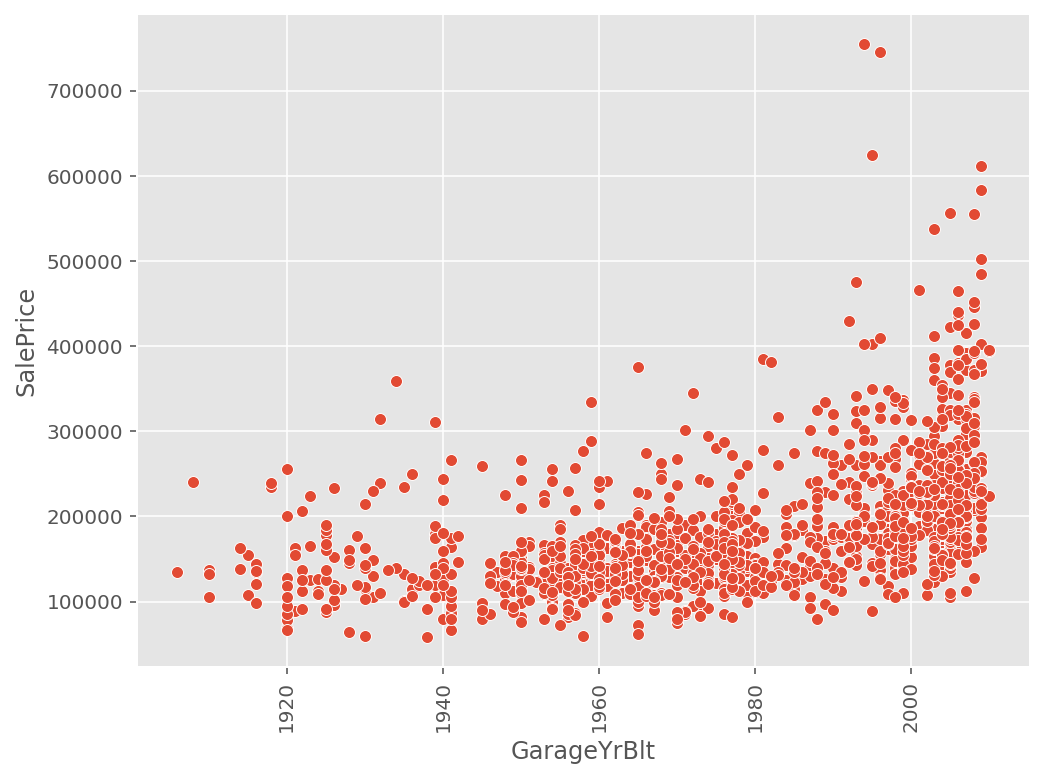

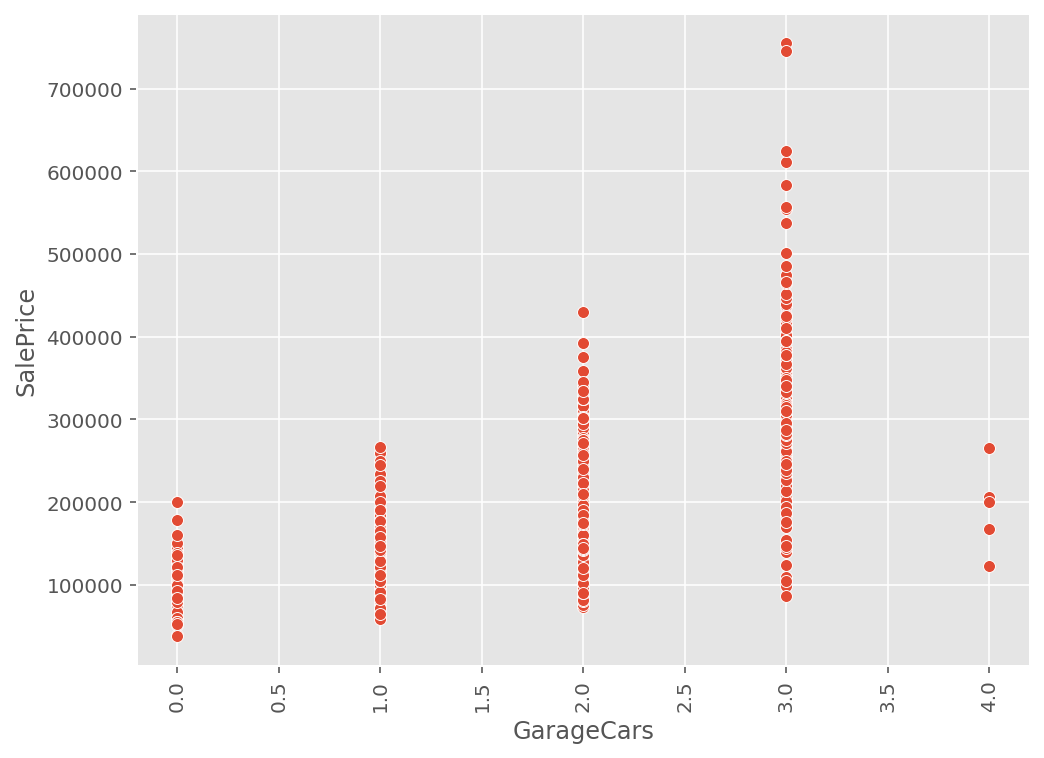

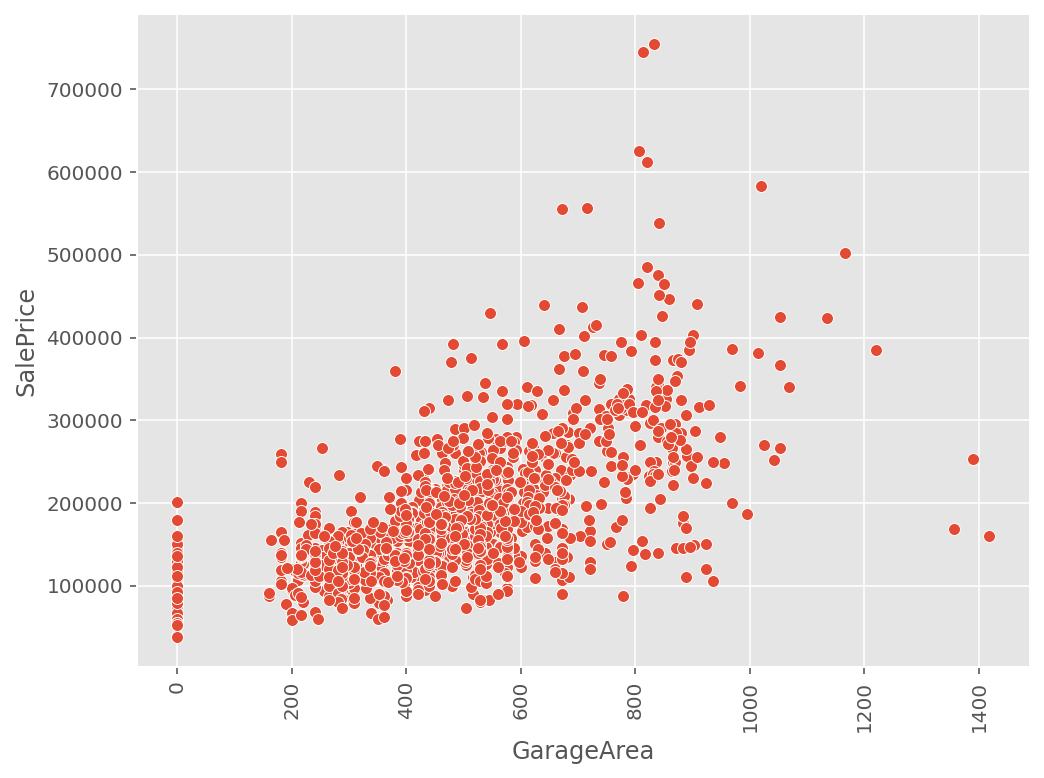

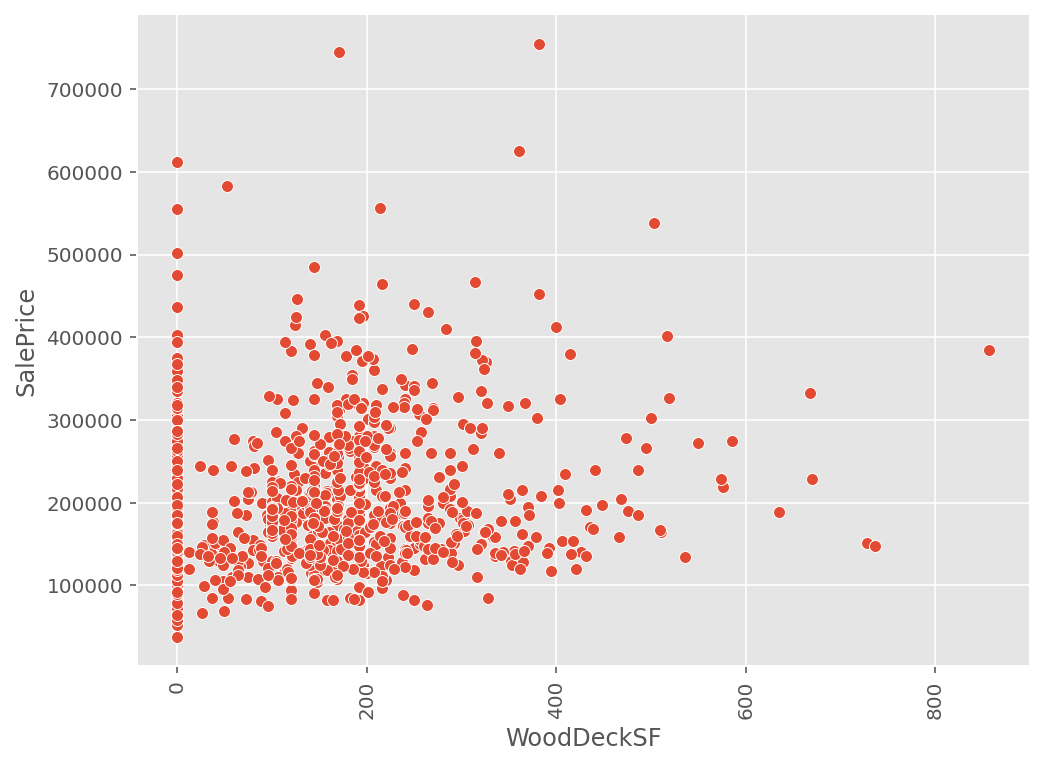

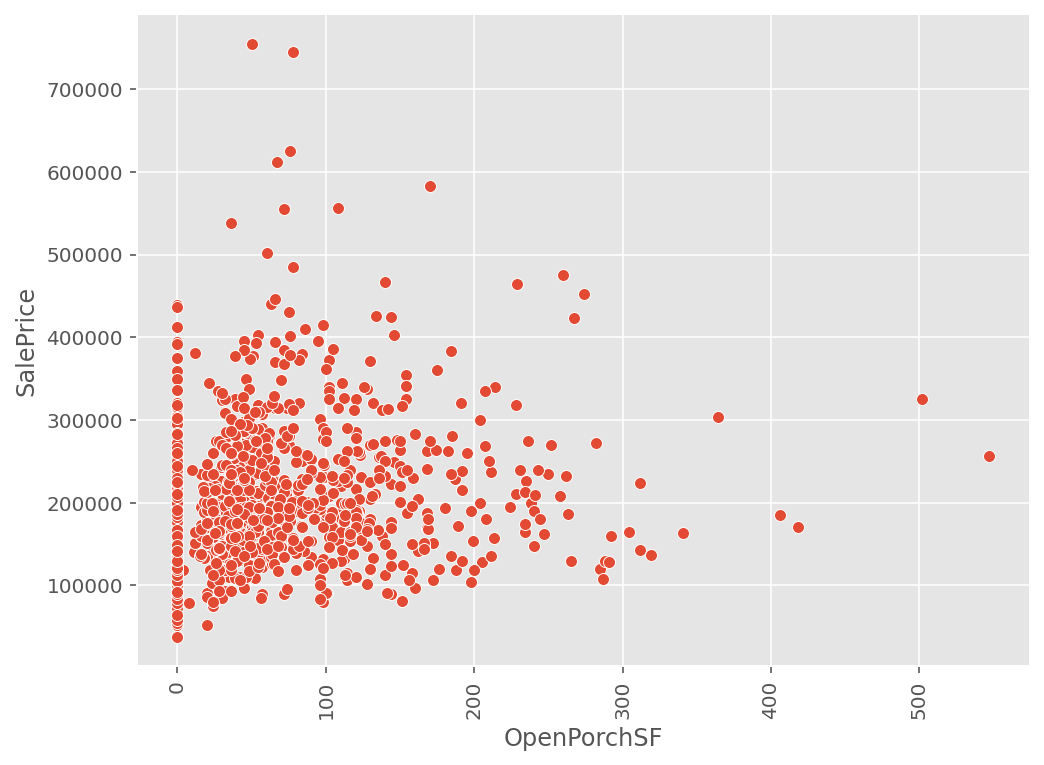

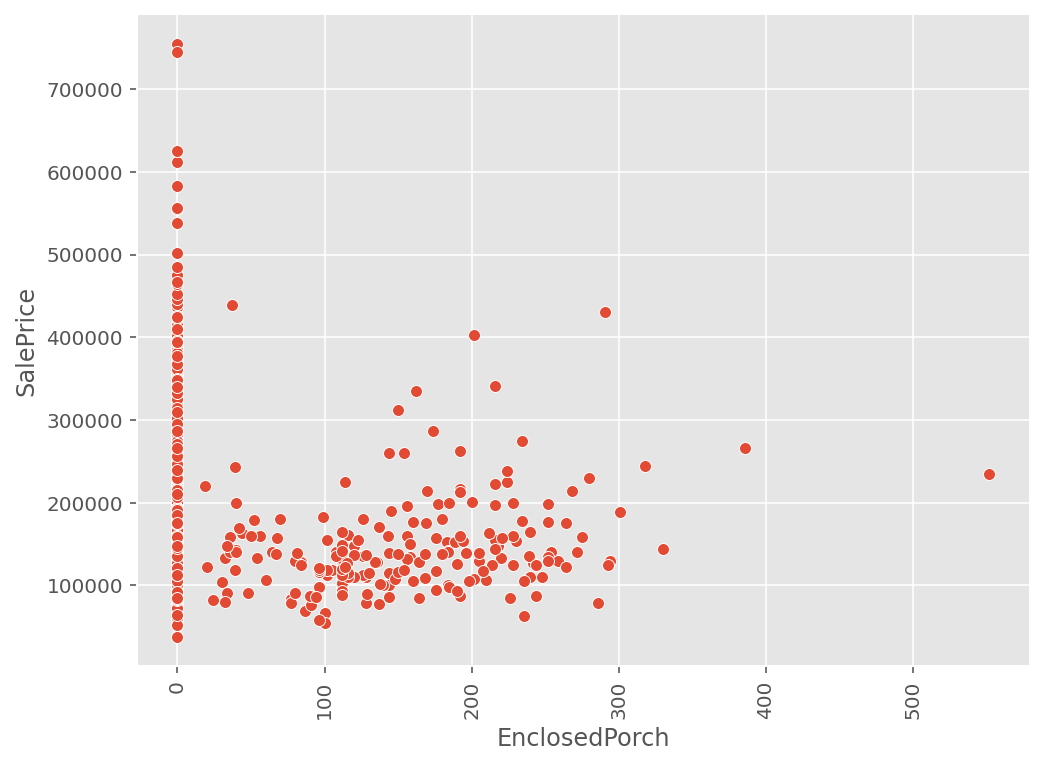

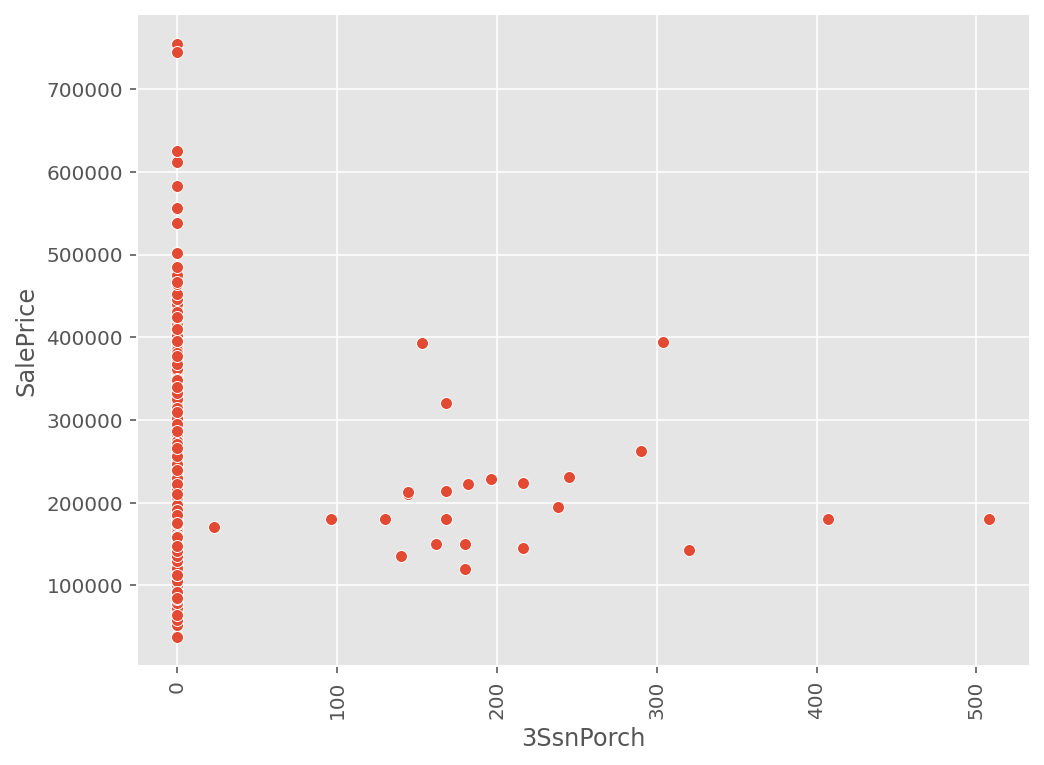

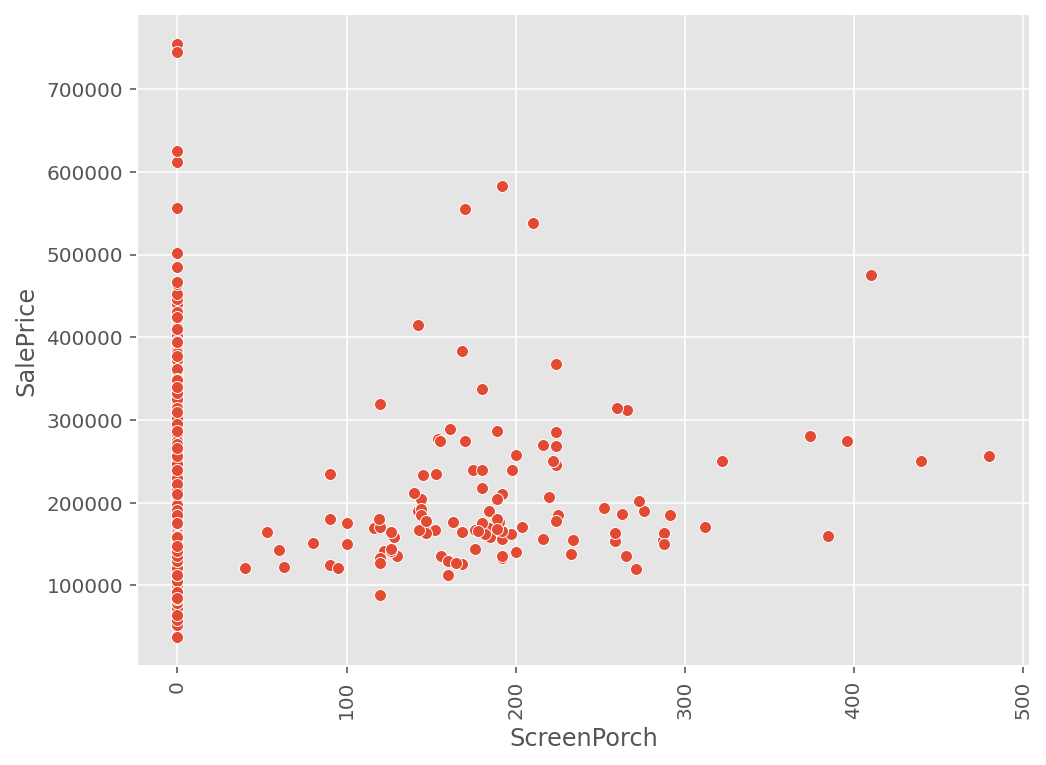

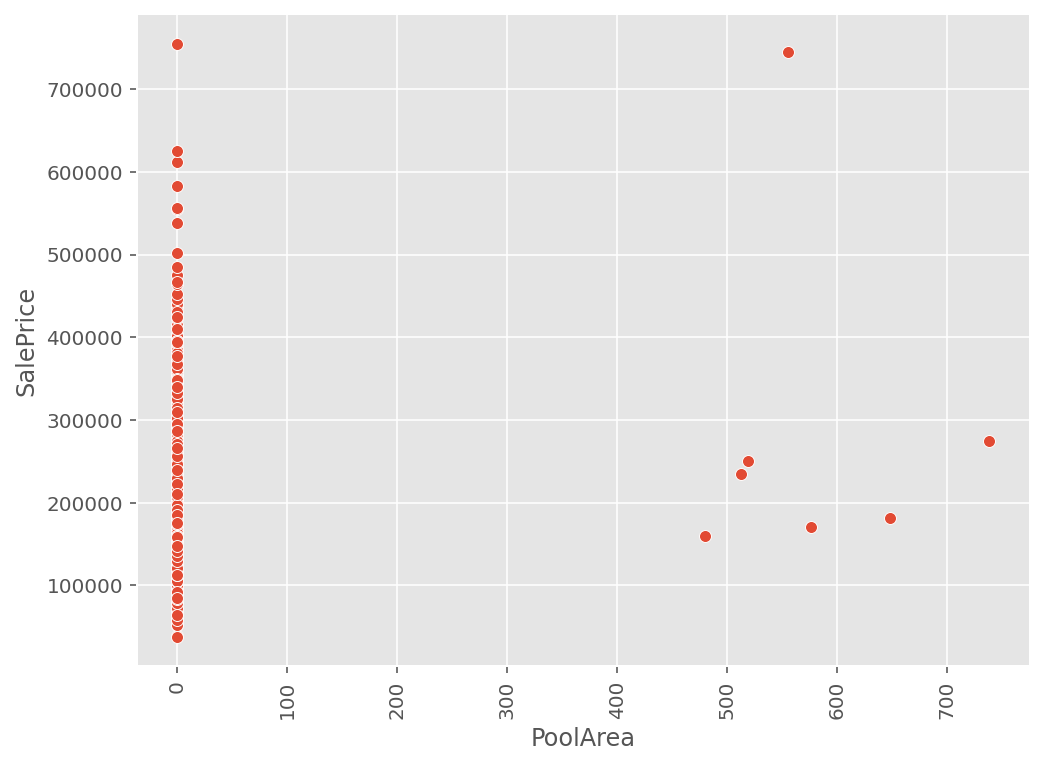

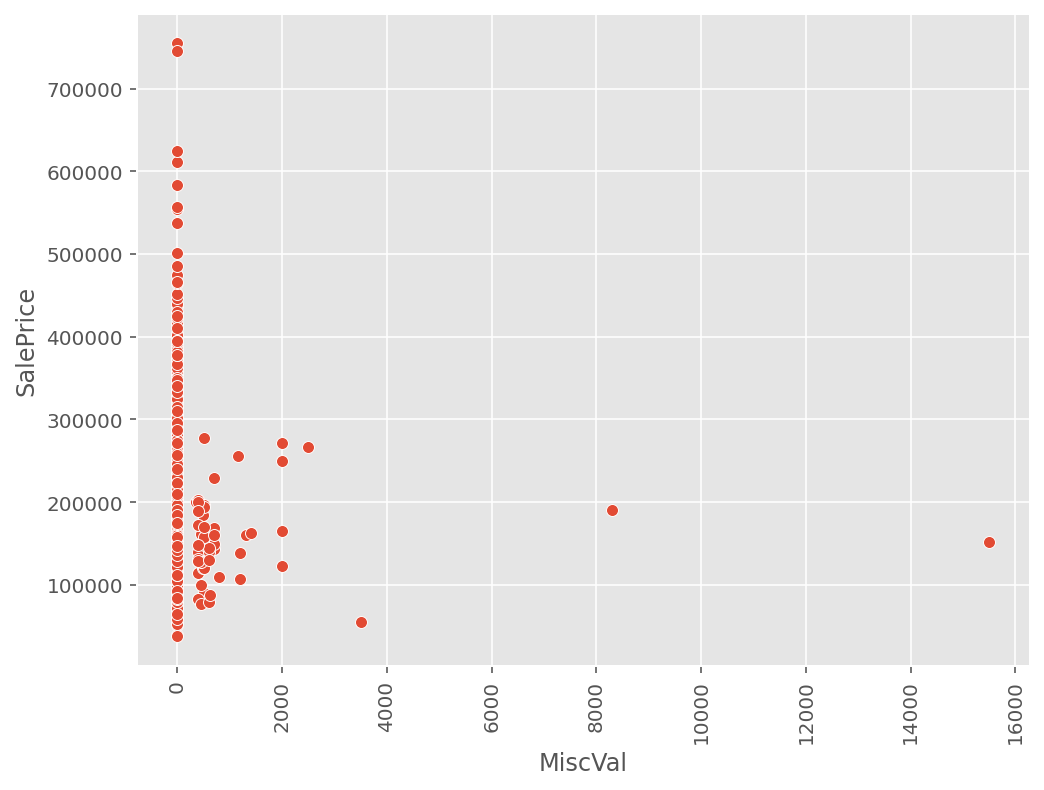

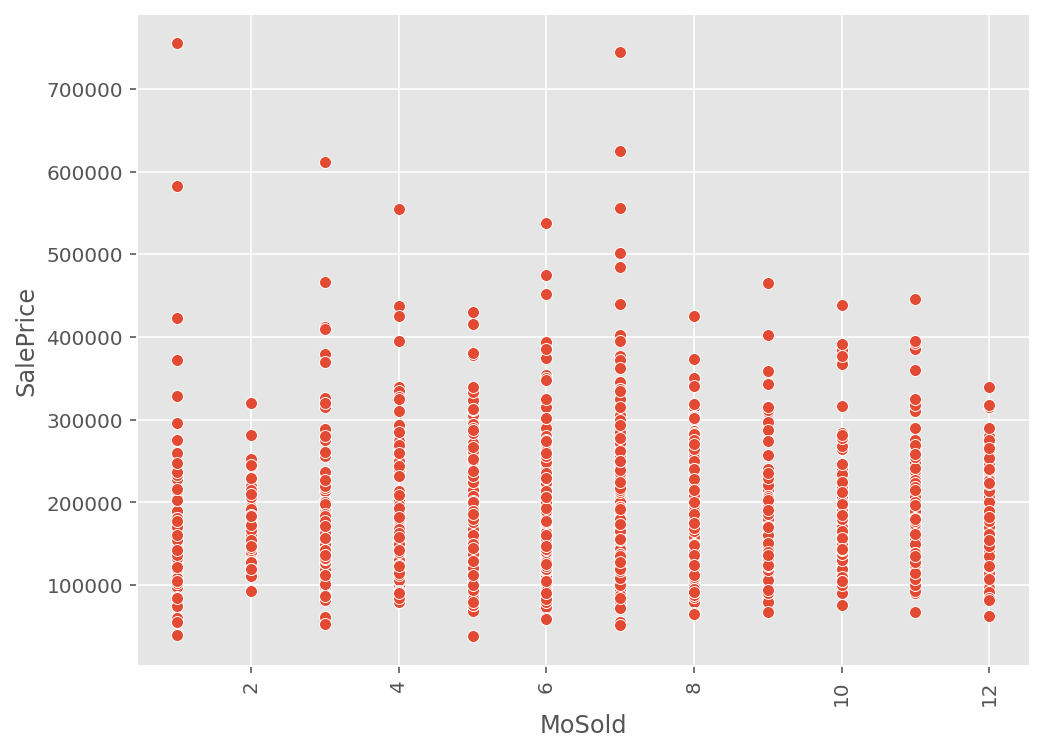

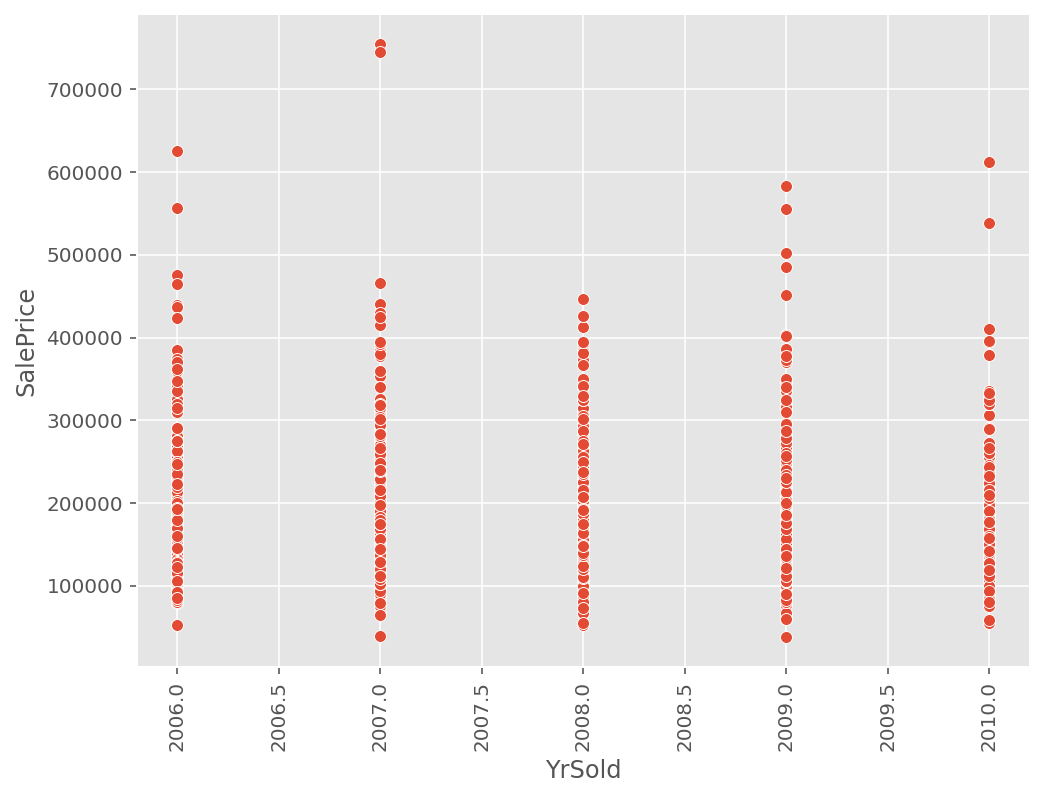

In [11]:
plot_numerical(numerical_columns, df['SalePrice'], df)

Comments:
Although MSSubclass is numerical it appears to have been numerically encoded (confirmed with data dictionary), we will have to modify it as it implies a linear replationship when none is present.

In [12]:
df['MSSubClass'] = df['MSSubClass'].apply(str)

/var/folders/0g/2n4dpfnj6xg2x7twpn7nk6nh0000gn/T/ipykernel_29239/1435658435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSSubClass'] = df['MSSubClass'].apply(str)


------

#### Further look into correlations and possible outleirs as seen above

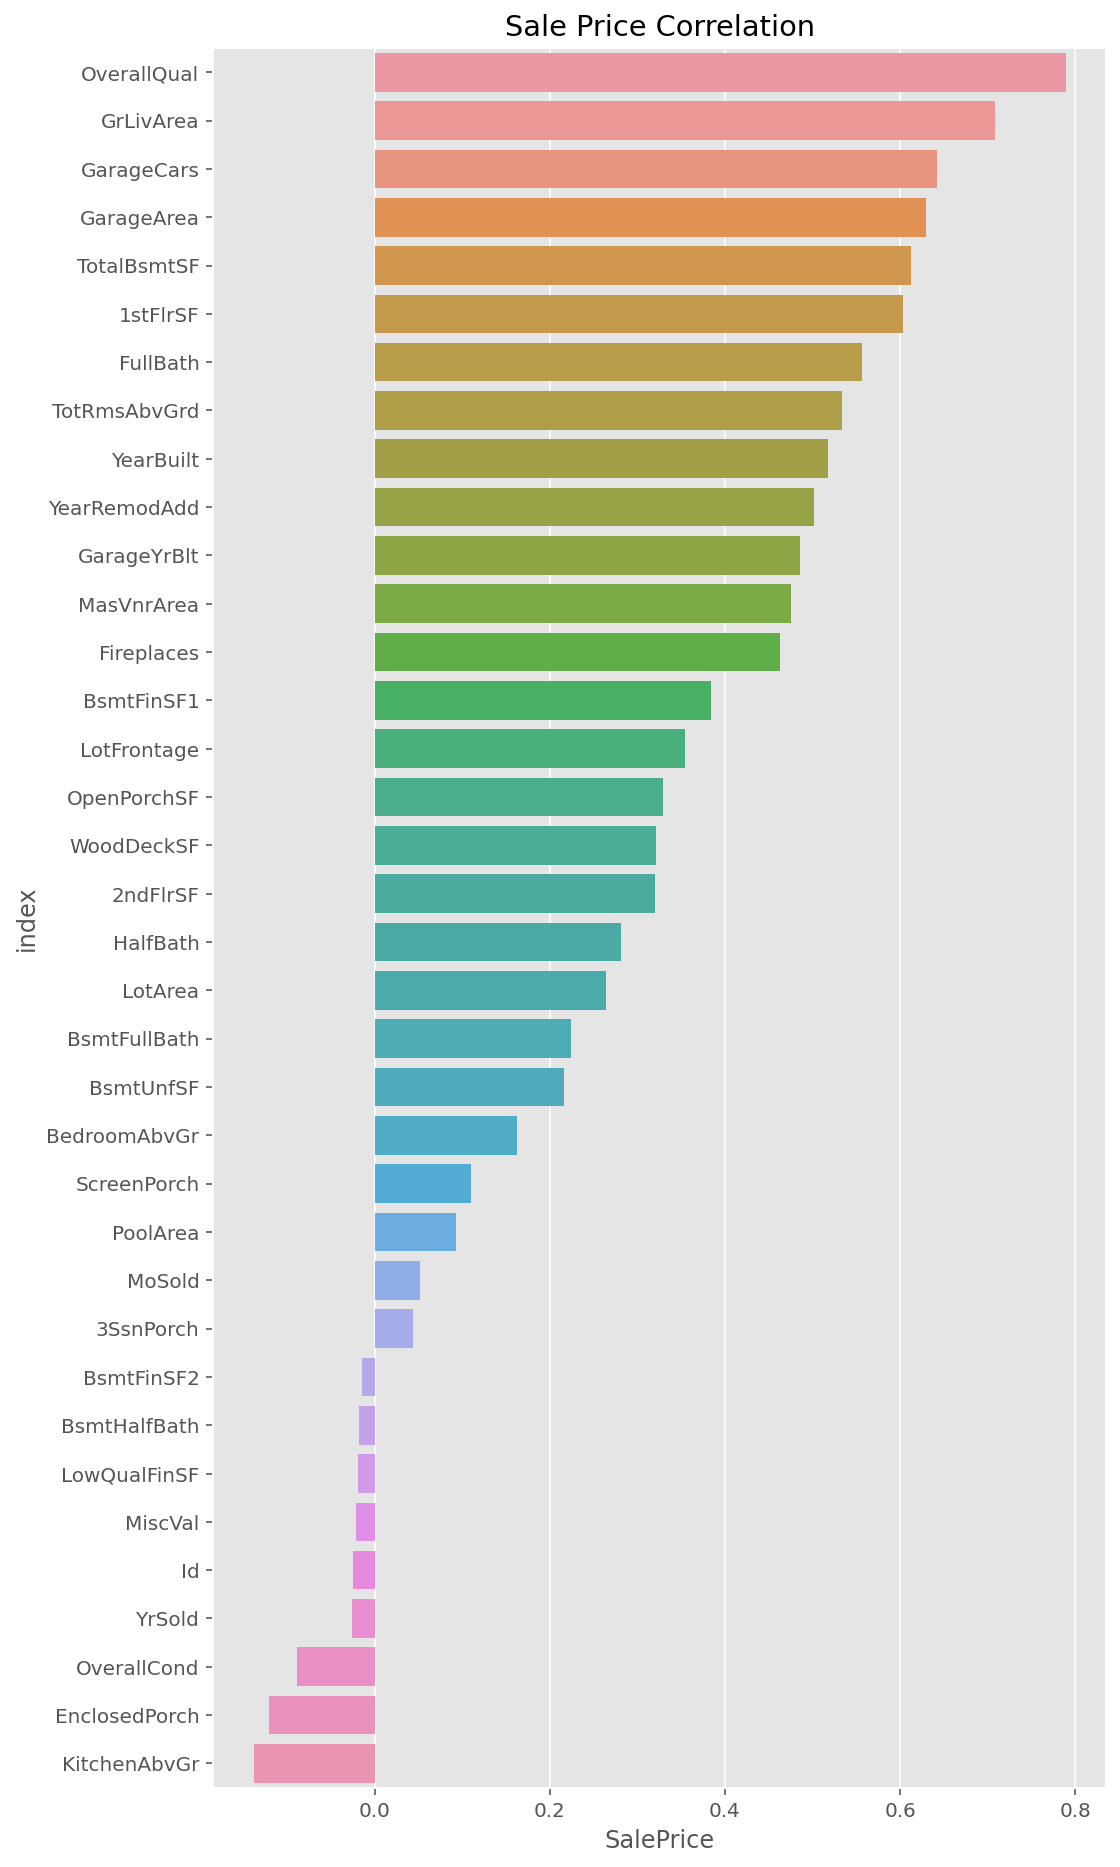

In [13]:
corr_price = df.corr()['SalePrice'].sort_values(ascending=False)
corr_price_df = pd.DataFrame(corr_price).reset_index().drop(0, axis=0)

plt.figure(figsize=(8,16))
plt.title('Sale Price Correlation')
sns.barplot(y='index', x='SalePrice', data=corr_price_df, orient='h');

#### Closer look at some of the most correlated features

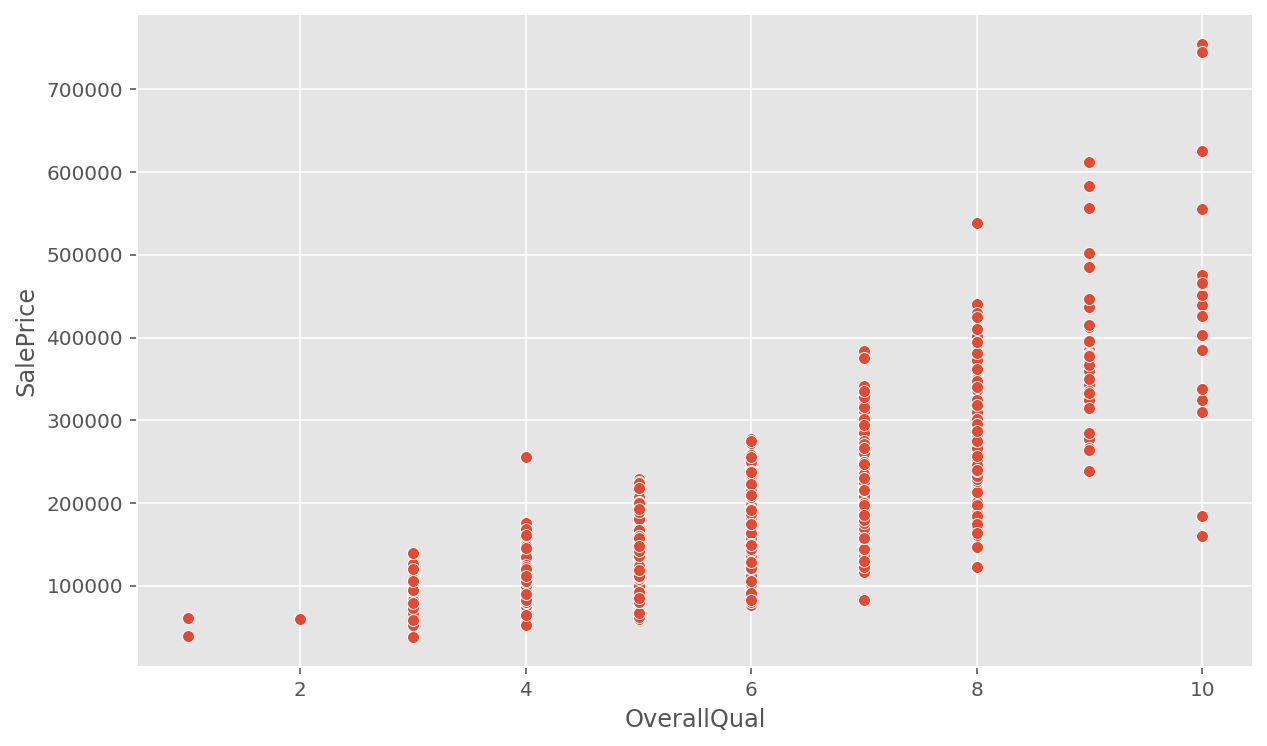

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(y='SalePrice', x='OverallQual', data=df);


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

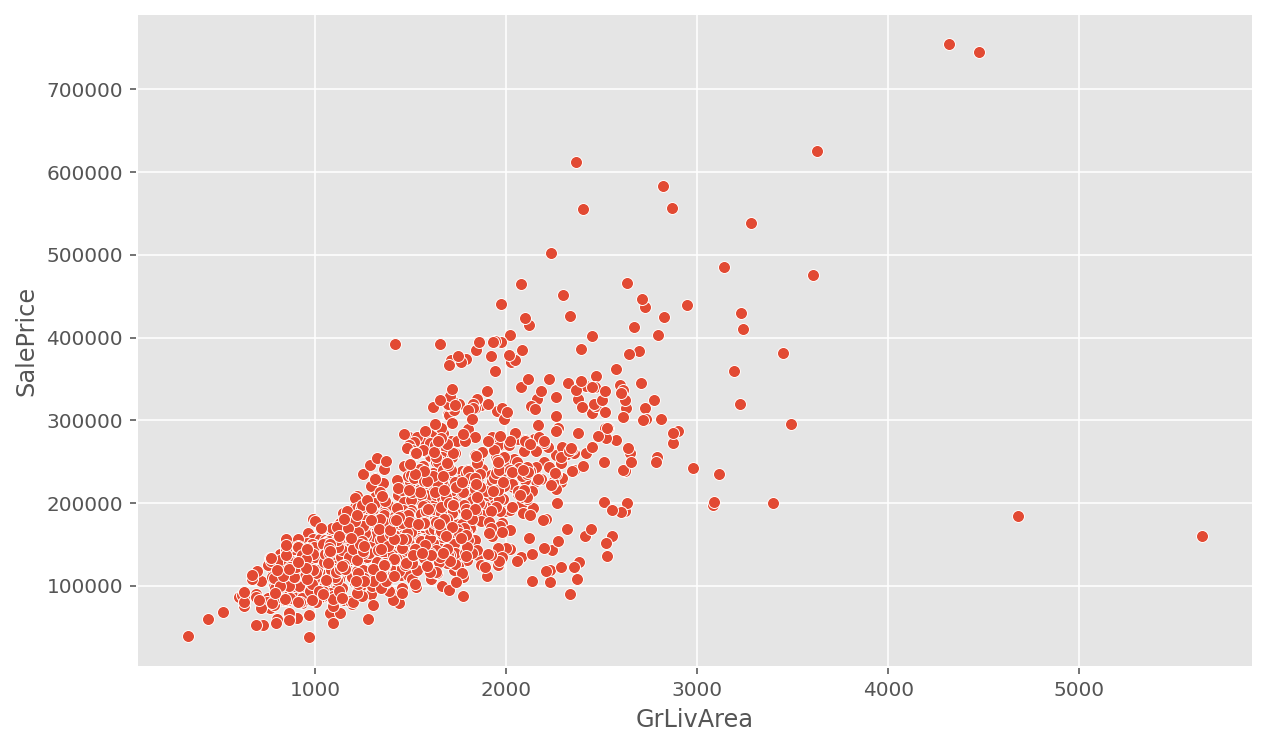

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)

#### Identifying outliers with high overall quality and living area but with very low prices 
I will remove these two rows as they can have a big impact with the model

In [16]:
df[(df['OverallQual']>8) & (df['SalePrice']<200000)]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523    524         60       RL        130.0    40094   Pave   NaN      IR1   
1298  1299         60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
523          Bnk    AllPub  ...        0    NaN   NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
523      10   2007       New        Partial     184750  
1298      1   2008       New        Partial     160000  

[2 rows x 81 columns]

In [17]:
df[(df['OverallQual']>8) & (df['SalePrice']<200000)].index

Int64Index([523, 1298], dtype='int64')

In [18]:
df = df.drop([523,1298], axis=0)

#### Checking scatterplot with outliers removed

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

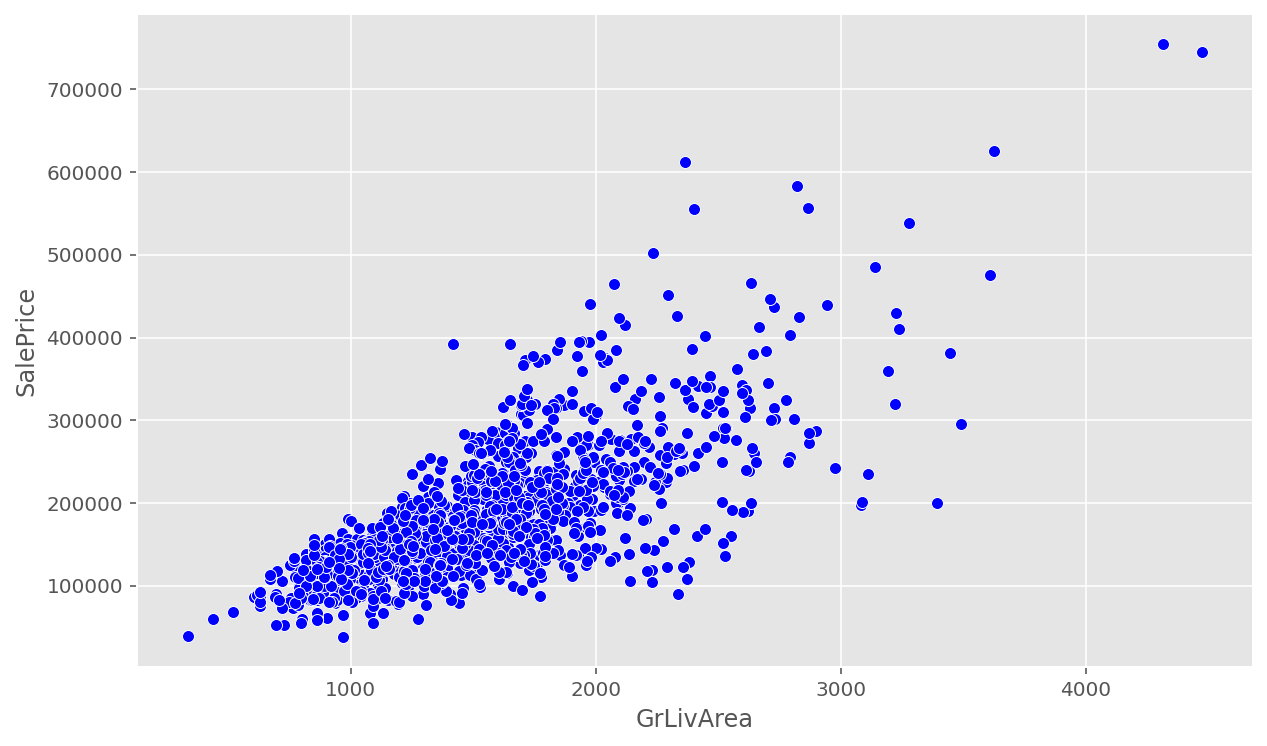

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, color='b')

#### 2. Dealing with missing Data

In [20]:
100 * df.isnull().sum() / len(df)

Id                0.00000
MSSubClass        0.00000
MSZoning          0.00000
LotFrontage      17.88674
LotArea           0.00000
                   ...   
MoSold            0.00000
YrSold            0.00000
SaleType          0.00000
SaleCondition     0.00000
SalePrice         0.00000
Length: 81, dtype: float64

In [21]:
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    
    return percent_nan


In [22]:
percent_nan = percent_missing(df)
percent_nan

Electrical       0.069061
MasVnrType       0.552486
MasVnrArea       0.552486
BsmtQual         2.555249
BsmtCond         2.555249
BsmtFinType1     2.555249
BsmtExposure     2.624309
BsmtFinType2     2.624309
GarageCond       5.455801
GarageQual       5.455801
GarageFinish     5.455801
GarageType       5.455801
GarageYrBlt      5.455801
LotFrontage     17.886740
FireplaceQu     47.030387
Fence           80.801105
Alley           93.853591
MiscFeature     96.408840
PoolQC          99.585635
dtype: float64

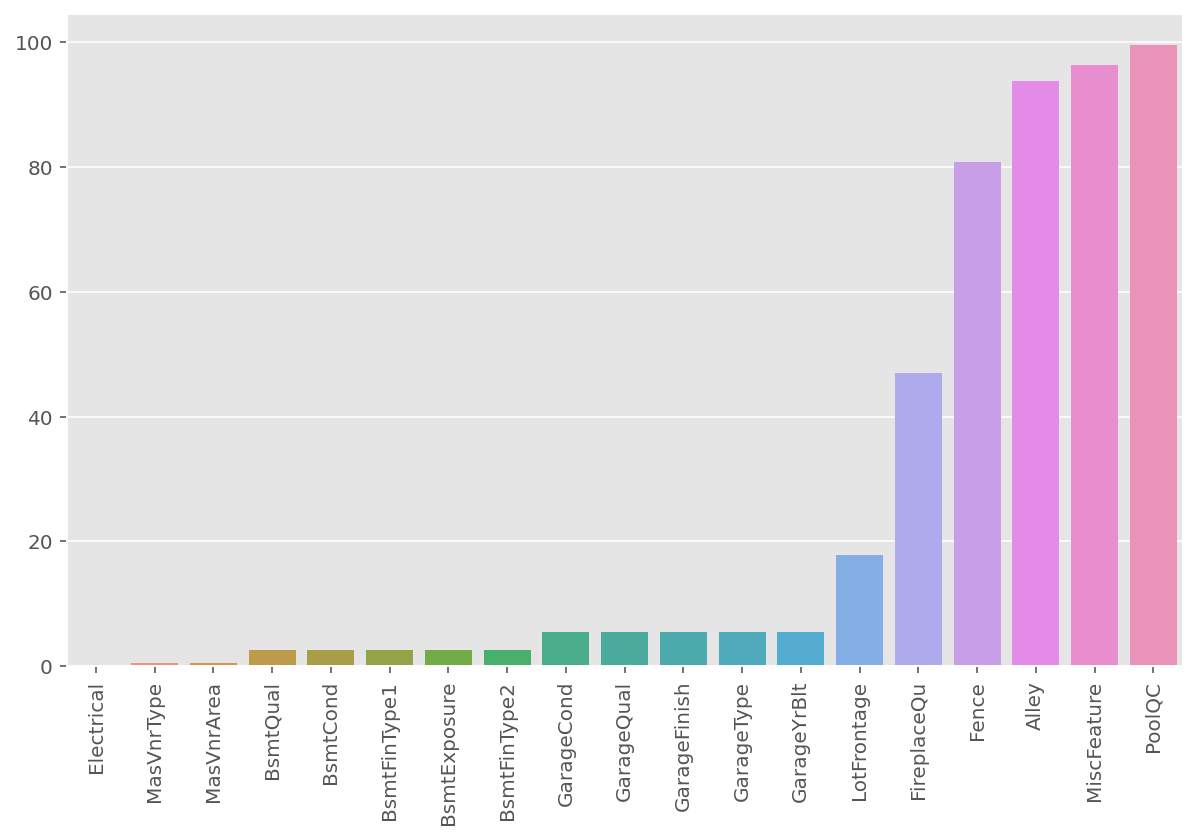

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90);

In [24]:
df[df['Electrical'].isnull()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1379  1380         80       RL         73.0     9735   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1379         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1379      5   2008        WD         Normal     167500  

[1 rows x 81 columns]

In [25]:
df = df.dropna(axis=0, subset=['Electrical'])

In [26]:
### Dealing with other percent nan under 1%


In [27]:
df['MasVnrType'].fillna('None', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

###### Dealing with BASEMENT missing values


In [28]:
percent_nan = percent_missing(df)
percent_nan

BsmtQual         2.557015
BsmtCond         2.557015
BsmtFinType1     2.557015
BsmtExposure     2.626123
BsmtFinType2     2.626123
GarageType       5.459572
GarageYrBlt      5.459572
GarageFinish     5.459572
GarageQual       5.459572
GarageCond       5.459572
LotFrontage     17.899102
FireplaceQu     46.993780
Fence           80.787837
Alley           93.849343
MiscFeature     96.406358
PoolQC          99.585349
dtype: float64

In [29]:
bsmnt_strings = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']

In [30]:
df[df['BsmtFinType2'].isnull() & df['BsmtFinType1'].notnull()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
332  333         20       RL         85.0    10655   Pave   NaN      IR1   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
332         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
332     10   2009        WD         Normal     284000  

[1 rows x 81 columns]

In [31]:
df[bsmnt_strings] = df[bsmnt_strings].fillna('None')

In [32]:
percent_nan = percent_missing(df)
percent_nan

GarageType       5.459572
GarageYrBlt      5.459572
GarageFinish     5.459572
GarageQual       5.459572
GarageCond       5.459572
LotFrontage     17.899102
FireplaceQu     46.993780
Fence           80.787837
Alley           93.849343
MiscFeature     96.406358
PoolQC          99.585349
dtype: float64

##### Dealing with GARAGE missing values


In [33]:
garage_numeric= ['GarageYrBlt']

garage_string= ['GarageType' , 'GarageFinish', 'GarageQual', 'GarageCond']

In [34]:
df[garage_string] = df[garage_string].fillna('None')

In [35]:
df['GarageYrBlt'].fillna(0, inplace=True)

In [36]:
percent_nan = percent_missing(df)
percent_nan

LotFrontage    17.899102
FireplaceQu    46.993780
Fence          80.787837
Alley          93.849343
MiscFeature    96.406358
PoolQC         99.585349
dtype: float64

Fireplace, Fence and alley are all categorical and have a value of Nan when there is no item in question. Therefore, like before i will replace the missing values with the string 'None'.
For poolQc and Miscfeature I will simply drop the columns as they are missing an incredible amount of the data.

In [37]:
df['FireplaceQu'].fillna('None', inplace=True)
df['Fence'].fillna('None', inplace=True)
df['Alley'].fillna('None', inplace=True)
df.drop(['PoolQC', 'MiscFeature'], axis=1, inplace=True)


---------

#### Fixing LotFrontage missing values

In [38]:
df['LotFrontage']

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1447, dtype: float64

<AxesSubplot:xlabel='LotFrontage', ylabel='Neighborhood'>

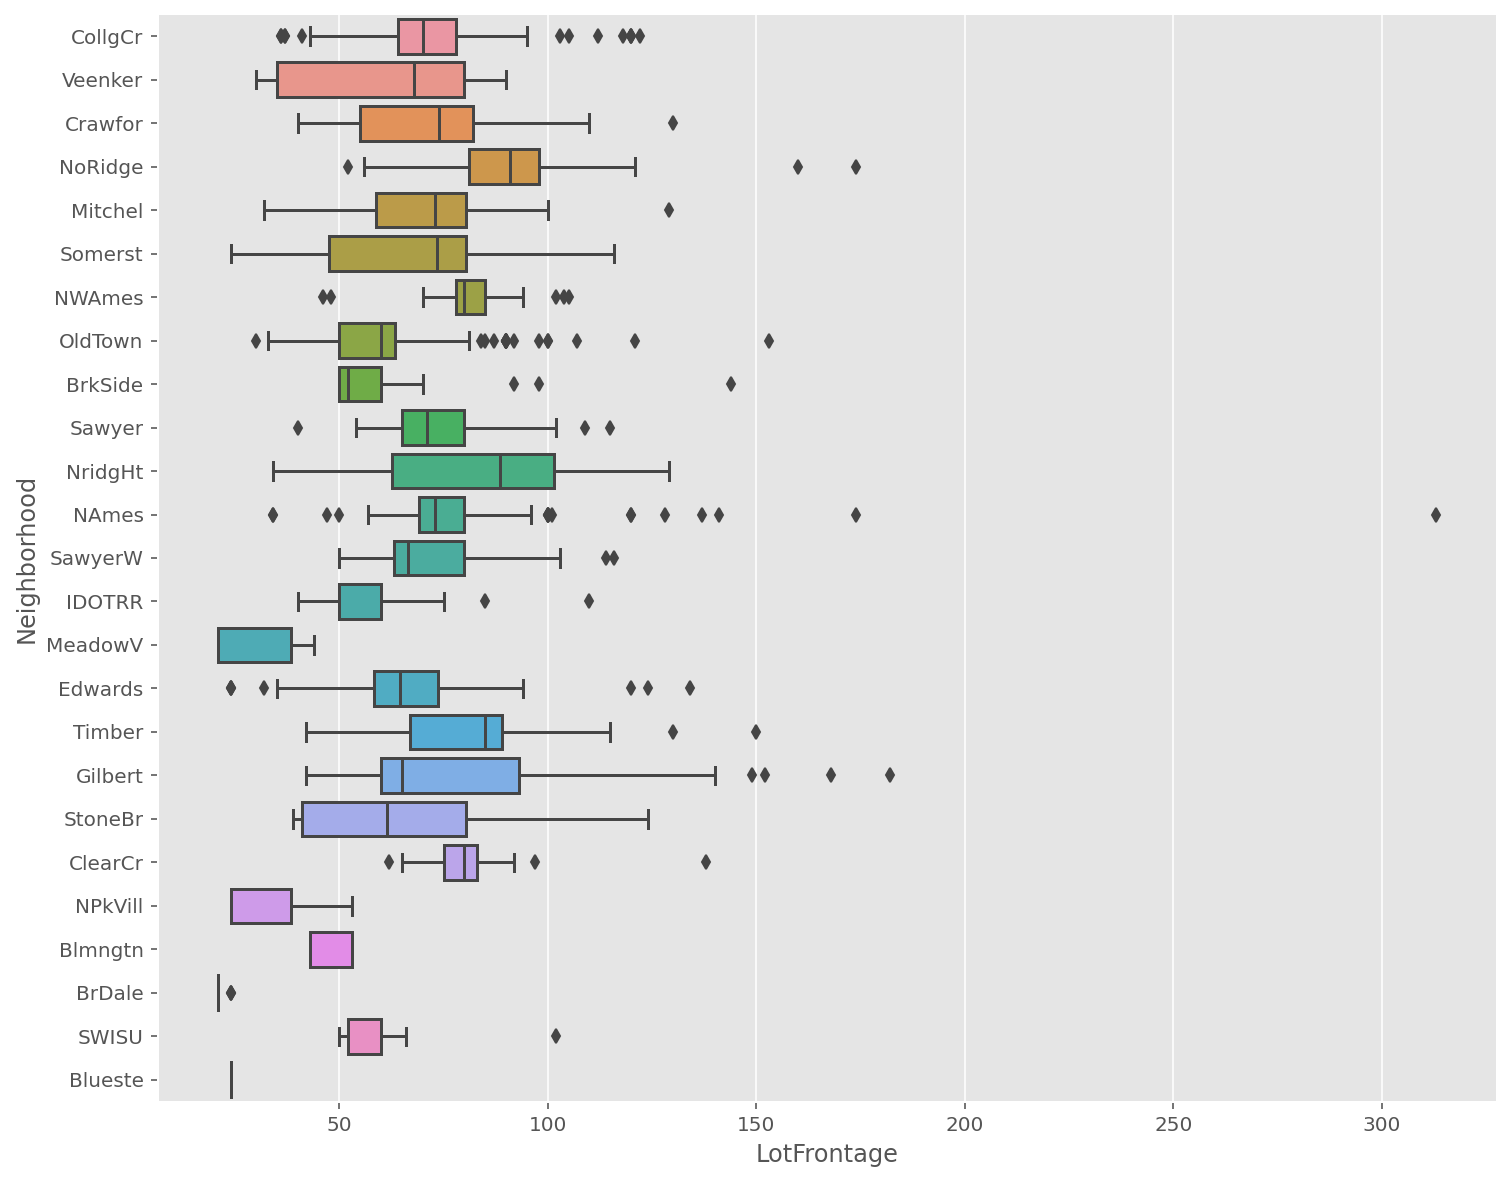

In [39]:
plt.figure(figsize=(12,10))
sns.boxplot(x='LotFrontage', y='Neighborhood', data=df, orient='h')


As the column is not missing enough data to consider dropping it yet there is still a considerable amount of missing values, I will replace the lot frontage missing for the average lot frontage for each neighborhood as it is a reasonable estimate to assume that neighborhoods could have very similar characteristics in that way.



In [40]:
df.groupby('Neighborhood')['LotFrontage'].mean()

Neighborhood
Blmngtn    47.142857
Blueste    24.000000
BrDale     21.562500
BrkSide    57.509804
ClearCr    83.461538
CollgCr    71.682540
Crawfor    71.804878
Edwards    64.811111
Gilbert    79.877551
IDOTRR     59.520000
MeadowV    27.800000
Mitchel    70.083333
NAmes      76.462366
NPkVill    32.285714
NWAmes     81.288889
NoRidge    91.878788
NridgHt    81.881579
OldTown    62.814815
SWISU      58.913043
Sawyer     74.437500
SawyerW    71.500000
Somerst    64.666667
StoneBr    62.700000
Timber     80.379310
Veenker    59.714286
Name: LotFrontage, dtype: float64

In [41]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))


In [42]:
percent_nan = percent_missing(df)
percent_nan


Series([], dtype: float64)

There are now no missing values in the dataset

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1447 non-null   int64  
 1   MSSubClass     1447 non-null   object 
 2   MSZoning       1447 non-null   object 
 3   LotFrontage    1447 non-null   float64
 4   LotArea        1447 non-null   int64  
 5   Street         1447 non-null   object 
 6   Alley          1447 non-null   object 
 7   LotShape       1447 non-null   object 
 8   LandContour    1447 non-null   object 
 9   Utilities      1447 non-null   object 
 10  LotConfig      1447 non-null   object 
 11  LandSlope      1447 non-null   object 
 12  Neighborhood   1447 non-null   object 
 13  Condition1     1447 non-null   object 
 14  Condition2     1447 non-null   object 
 15  BldgType       1447 non-null   object 
 16  HouseStyle     1447 non-null   object 
 17  OverallQual    1447 non-null   int64  
 18  OverallC

--------

## Separating the data into renovateable features and non

In [44]:
#df.drop('Id', axis=1, inplace=True)
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [45]:
renovateable_columns = ['RoofMatl', 'RoofStyle', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond',
                       'BsmtCond', 'GarageCond', 'Fence', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                           'ScreenPorch', 'FireplaceQu', 'KitchenQual', 'GarageQual', 'LowQualFinSF',
                        'BsmtQual', 'Electrical', 'Heating', 'HeatingQC', 'CentralAir','YrSold']

non_renovateable_columns = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
                            'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                            'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                            'HouseStyle',   'YearBuilt', 'YearRemodAdd',
                              'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                            'MasVnrArea',  'Foundation',  
                            'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2','BsmtFinSF2', 
                            'BsmtUnfSF', 'TotalBsmtSF', 
                             '1stFlrSF', '2ndFlrSF', 
                           'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                           'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                           'Functional', 'Fireplaces',  'GarageType', 'GarageYrBlt',
                           'GarageFinish', 'GarageCars', 'GarageArea',  
                           'PavedDrive',  'PoolArea', 'MiscVal',
                           'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

#### Checking all columns are included:

In [46]:
set(renovateable_columns + non_renovateable_columns) - set(df.columns) 

set()

-----

## Creating a Model with non renovateable features

In [47]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import RidgeCV, Ridge, ElasticNet, LassoCV
from sklearn.metrics import mean_squared_error

#### Creating dummy variables for categorical features

In [48]:
non_ren_df = df[non_renovateable_columns]

In [49]:
non_ren_objects_dummies = pd.get_dummies(non_ren_df.select_dtypes(include='object'), drop_first=True)
non_ren_numeric = non_ren_df.select_dtypes(exclude='object')
non_ren_df_final = pd.concat([non_ren_numeric, non_ren_objects_dummies], axis=1)

#### Train test Split with pre 2010 and 2010 data.

In [50]:
X_train = non_ren_df_final[non_ren_df_final['YrSold'] < 2010]
y_train = df[df['YrSold'] < 2010]['SalePrice']

In [51]:
X_test = non_ren_df_final[non_ren_df_final['YrSold'] == 2010]
y_test = df[df['YrSold'] == 2010]['SalePrice']

#### Standardizing the data

In [52]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

-----

Ridge

In [53]:
ridge_model = RidgeCV(alphas=np.logspace(-5, 5, 100), cv=10)
ridge_model.fit(X_train_scaled, y_train)

print(f' Best Alpha ---> {ridge_model.alpha_}')
print(f' Train Score ---> {ridge_model.score(X_train_scaled, y_train)}')
print(f' Test Score ---> {ridge_model.score(X_test_scaled, y_test)}')

 Best Alpha ---> 148.49682622544634
 Train Score ---> 0.9059565925123658
 Test Score ---> 0.8931221471169413


#### With cross Val Score

In [54]:
ridge = Ridge(alpha=93.26033468832199)
#148.49682622544634
ridge_scores_train = cross_val_score(ridge, X_train_scaled, y_train, cv=10)

print(f'Scores --> {ridge_scores_train}')
print(f'Mean Scores --> {ridge_scores_train.mean()}')

Scores --> [0.89282563 0.82764375 0.91487173 0.88041197 0.87863753 0.86894962
 0.86218985 0.86581494 0.83296295 0.86777489]
Mean Scores --> 0.8692082855519757


In [55]:
y_pred_train = ridge_model.predict(X_train_scaled)
y_pred_test = ridge_model.predict(X_test_scaled)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

In [56]:
np.sqrt(mean_squared_error(y_test, y_pred_test))

26066.55262906035

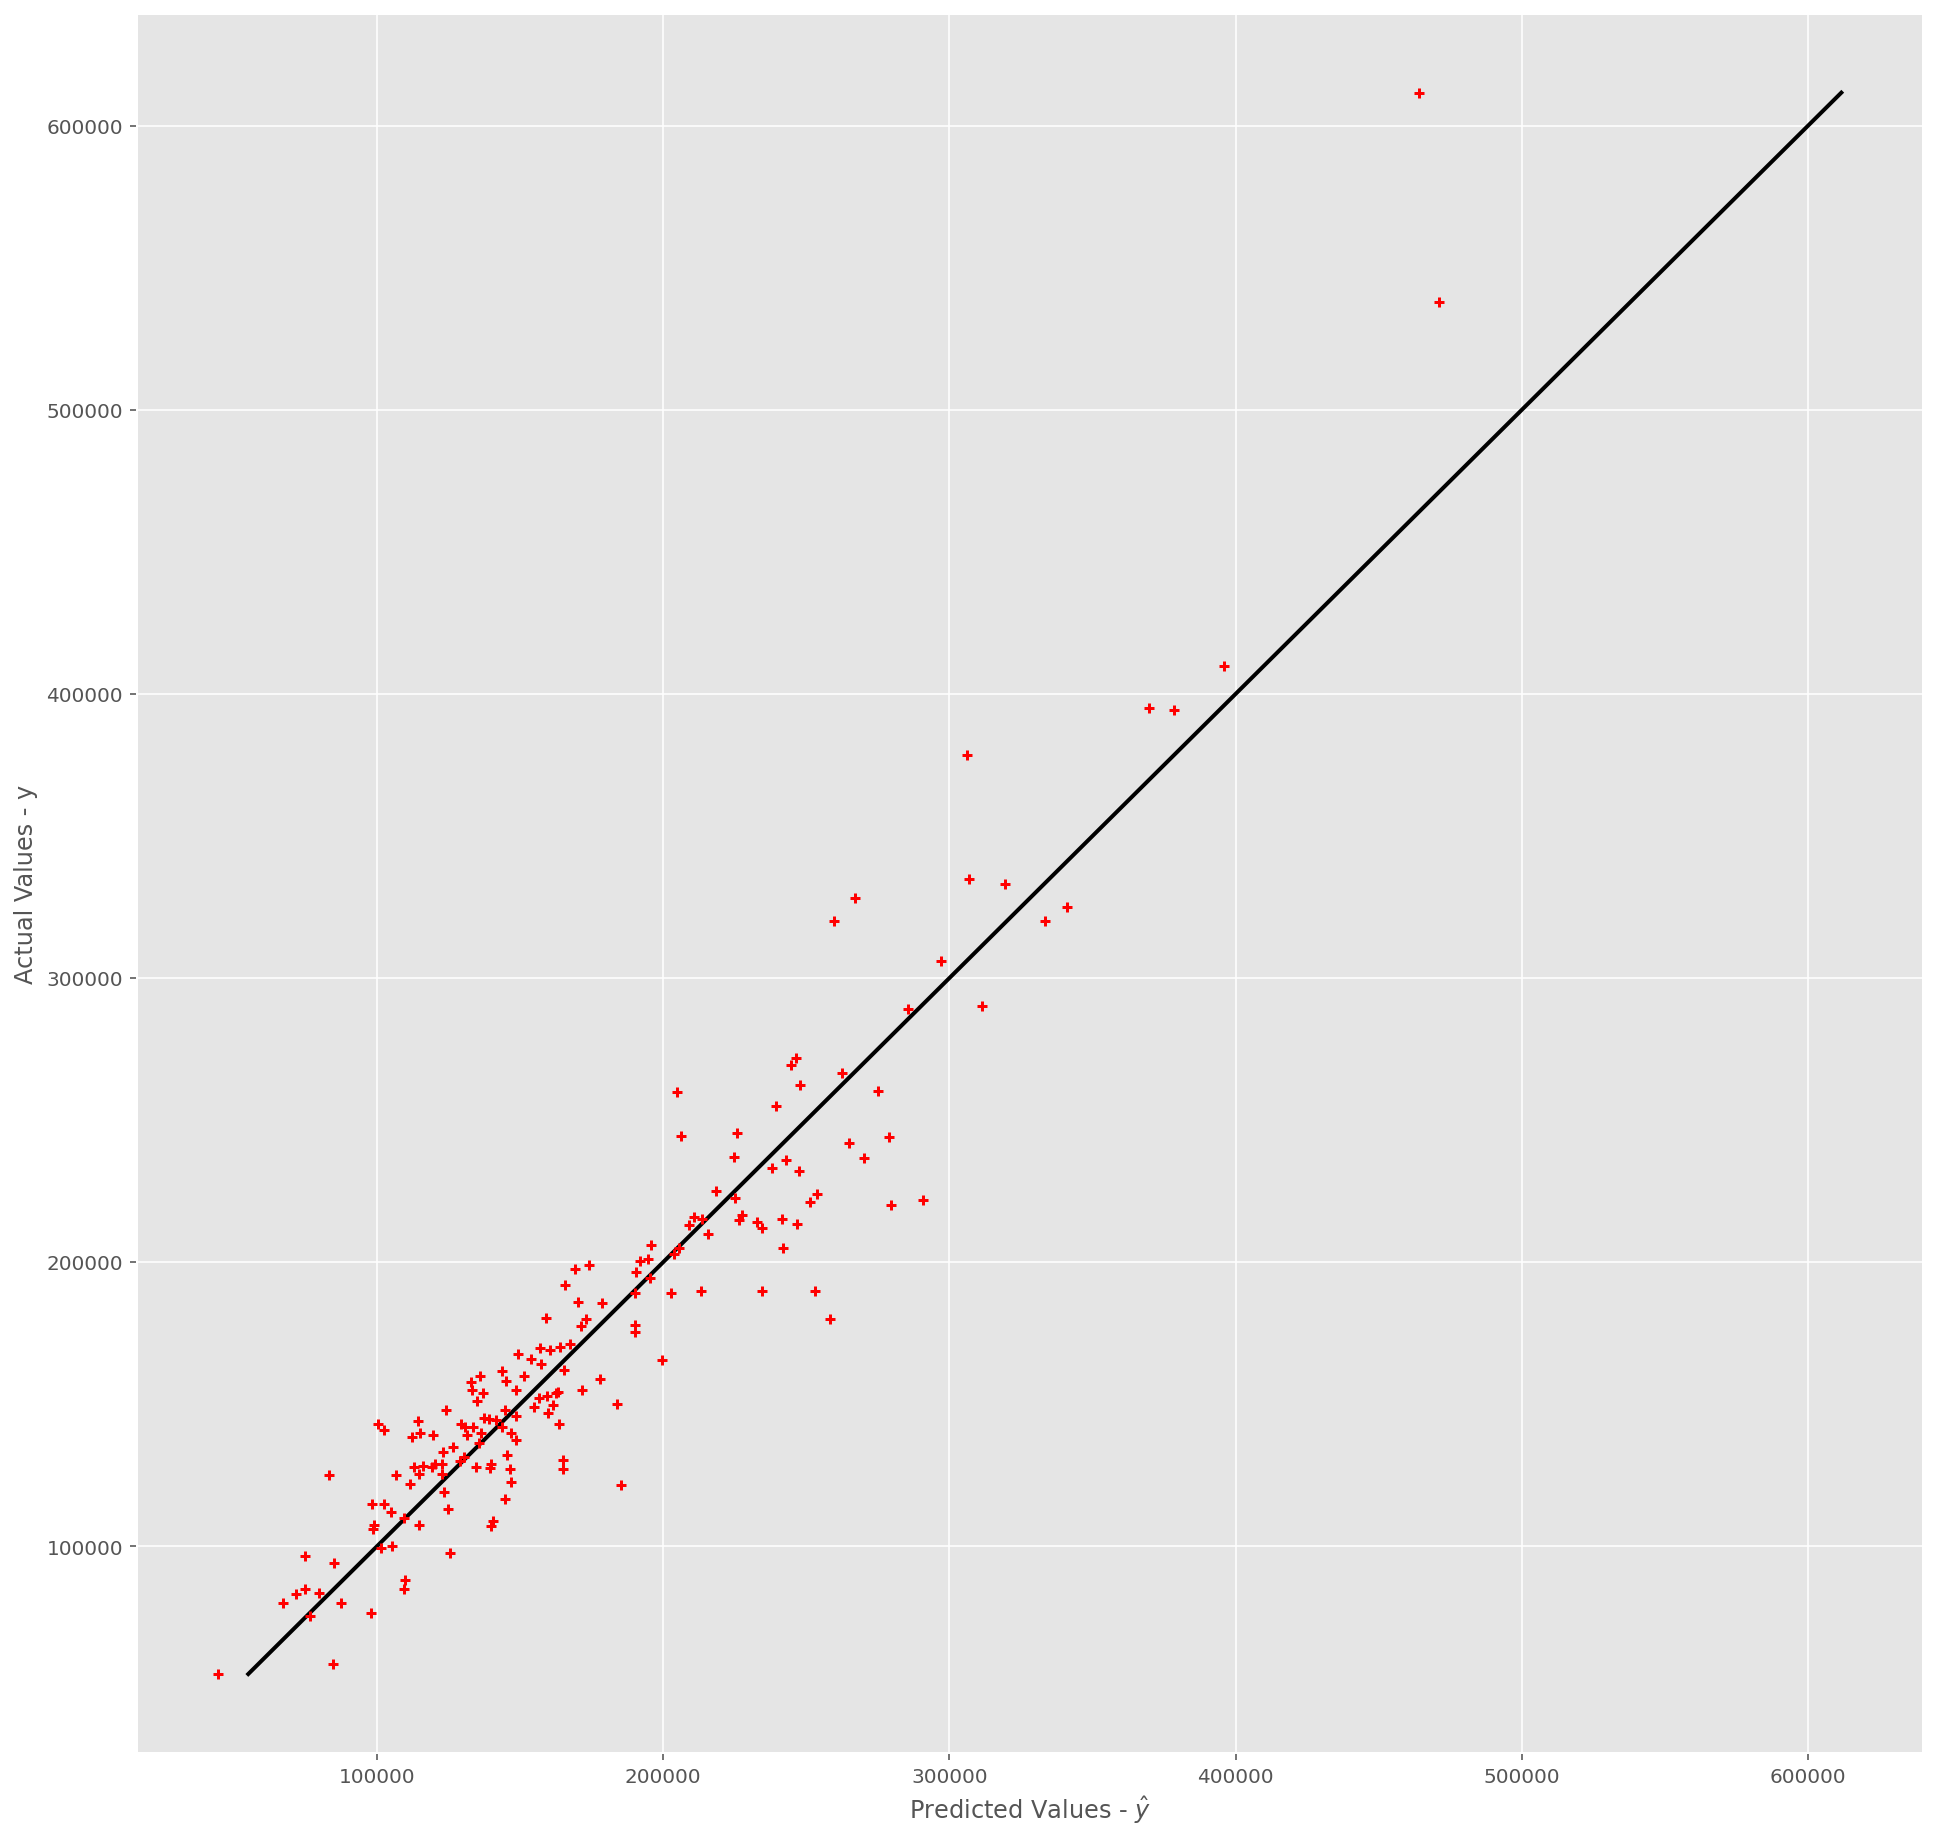

In [57]:
# Plot the model
plt.figure(figsize=(16, 16))
plt.scatter(y_pred_test, y_test, s=30, c='r', marker='+', zorder=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='k', lw=2)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - y")
plt.show()

-------

#### Lasso

In [58]:
lasso_model = LassoCV(alphas=np.logspace(-5, 5, 100), cv=5,  max_iter=100000, normalize=True, tol=1e-2)
lasso_model.fit(X_train_scaled, y_train)

print(f' Best Alpha ---> {lasso_model.alpha_}')
print(f' Train Score ---> {lasso_model.score(X_train_scaled, y_train)}')
print(f' Test Score ---> {lasso_model.score(X_test_scaled, y_test)}')

 Best Alpha ---> 23.10129700083158
 Train Score ---> 0.897755539117223
 Test Score ---> 0.8894660622654369


#### Creating grid model

base_elastic_model = ElasticNet(max_iter=1000000)

param_grid={'alpha':[100,125,150,175], 'l1_ratio': np.linspace(0,1,3)}

grid_model = GridSearchCV(estimator=base_elastic_model,
                         param_grid=param_grid,
                         cv=5, verbose=3)

grid_model.fit(X_train_scaled, y_train)

--------

-------

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

--------

#### Here the y will be the the residuals, ie y - y_pred

In [59]:
renovateable_df = df[renovateable_columns]

### Get dummies

In [60]:
renovateble_objects_dummies = pd.get_dummies(renovateable_df.select_dtypes(include='object'), drop_first=True)
renovateble_numeric = renovateable_df.select_dtypes(exclude='object')

In [61]:
renovateble_df_final = pd.concat([renovateble_numeric, renovateble_objects_dummies], axis=1)

In [62]:
renovateble_df_final

OverallQual  OverallCond  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0               7            5           0           61              0   
1               6            8         298            0              0   
2               7            5           0           42              0   
3               7            5           0           35            272   
4               8            5         192           84              0   
...           ...          ...         ...          ...            ...   
1455            6            5           0           40              0   
1456            6            6         349            0              0   
1457            7            9           0           60              0   
1458            5            6         366            0            112   
1459            5            6         736           68              0   

      3SsnPorch  ScreenPorch  LowQualFinSF  YrSold  RoofMatl_Membran  ...  \
0             0            0             0    2008                 0  ...   
1             0            0             0    2007                 0  ...   
2             0            0             0    2008                 0  ...   
3             0            0             0    2006                 0  ...   
4             0            0             0    2008                 0  ...   
...         ...          ...           ...     ...               ...  ...   
1455          0            0             0    2007                 0  ...   
1456          0            0             0    2010                 0  ...   
1457          0            0             0    2010                 0  ...   
1458          0            0             0    2010                 0  ...   
1459          0            0             0    2008                 0  ...   

      Heating_GasA  Heating_GasW  Heating_Grav  Heating_OthW  Heating_Wall  \
0                1             0             0             0             0   
1                1             0             0             0             0   
2                1             0             0             0             0   
3                1             0             0             0             0   
4                1             0             0             0             0   
...            ...           ...           ...           ...           ...   
1455             1             0             0             0             0   
1456             1             0             0             0             0   
1457             1             0             0             0             0   
1458             1             0             0             0             0   
1459             1             0             0             0             0   

      HeatingQC_Fa  HeatingQC_Gd  HeatingQC_Po  HeatingQC_TA  CentralAir_Y  
0                0             0             0             0             1  
1                0             0             0             0             1  
2                0             0             0             0             1  
3                0             1             0             0             1  
4                0             0             0             0             1  
...            ...           ...           ...           ...           ...  
1455             0             0             0             0             1  
1456             0             0             0             1             1  
1457             0             0             0             0             1  
1458             0             1             0             0             1  
1459             0             1             0             0             1  

[1447 rows x 71 columns]

Split the data

In [63]:
X_train = renovateble_df_final[renovateble_df_final['YrSold'] < 2010].drop(['YrSold'], axis=1)
y_train = residuals_train

X_test = renovateble_df_final[renovateble_df_final['YrSold'] == 2010].drop(['YrSold'], axis=1)
y_test = residuals_test

### Scale the data

In [64]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train the model

In [65]:
ridge_model = RidgeCV(alphas=np.logspace(-5, 5, 100), cv=10)
ridge_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400829e-04, 6.57933225e-04, 8.30217568e-04,
       1.04761575e-03, 1.32194115e-0...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
        cv=10)

In [66]:
alpha = ridge_model.alpha_
alpha

187.3817422860383

In [67]:
ridge_model.score(X_train_scaled, y_train)

0.22164872774401667

In [68]:
ridge_model.score(X_test_scaled, y_test)

0.15204035392830761

In [69]:
ridge = Ridge(alpha=alpha)
ridge_scores_train = cross_val_score(ridge, X_train_scaled, y_train, cv=10)

print(f'Scores --> {ridge_scores_train}')
print(f'Mean Scores --> {ridge_scores_train.mean()}')

Scores --> [ 0.08918775  0.22750543  0.19008262  0.10311466  0.26839298  0.09122592
 -0.05570431 -0.01098392  0.15772686  0.08966698]
Mean Scores --> 0.11502149664538877


In [70]:
print('Intercept:', ridge_model.intercept_)
pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_))).sort_values(1, ascending=False).head(30)

Intercept: 1.7868020148102217e-13


0            1
0         OverallQual  4941.027353
1         OverallCond  4438.252353
13   RoofMatl_WdShngl  4137.155572
41   FireplaceQu_None  1460.155666
8    RoofMatl_Membran  1354.887389
38         Fence_None  1121.793147
29        BsmtCond_TA  1091.203552
6         ScreenPorch  1026.076314
36        Fence_MnPrv  1001.858723
9      RoofMatl_Metal   906.392655
2          WoodDeckSF   759.665770
35         Fence_GdWo   655.602422
26        BsmtCond_Gd   633.935539
5           3SsnPorch   632.838310
3         OpenPorchSF   631.393965
27      BsmtCond_None   515.364389
54      BsmtQual_None   515.364389
28        BsmtCond_Po   490.546187
15  RoofStyle_Gambrel   400.746340
69       CentralAir_Y   390.595439
19       ExterQual_Fa   389.533169
22       ExterCond_Fa   360.754789
64       Heating_Wall   355.444010
25       ExterCond_TA   334.211340
17  RoofStyle_Mansard   249.763989
60       Heating_GasA   210.851518
61       Heating_GasW   171.910743
18     RoofStyle_Shed   147.226751
58     Electrical_Mix   146.544048
67       HeatingQC_Po   111.785628

--------

#### Evaluate the effect in dollars of the renovatable features:
- A one unit increase in the standard deviation in a feature would bring around a dollar increase equal to the number shown on the right column. For example:
    - A one unit increase in the standard deviation of Overalqual qould increase the remainder of the price by around 5000 dollars.




#### How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Using the first model which has quite a high level of accuracy, the company can decide which house to buy at face value. The model can identify the dollar cost of a house based on the fixed features and the company can then identify which houses are overpriced and underpriced to find the right opportunity. It can buy houses which are underpriced and discard those which are over.
- It can then use the second model to prioritize the features that will give the highest value added (respective tot he cost of increase that feature, which we do not have data on).


#### Investigate how much of the variance in price remaining is explained by these features.
- Based on how low the score of this second model is, both in testing and training we can realistically say that the remaining variance in price, ie, the residuals from question 1, is not well described by these features.

#### Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

- No the model is extremly suspect, the score is very very low and the featuers deemed renovateable can be questioned. For instance a quick search will tell you that installing central airconditioning or central heating can be very costly.
- Also the way we have used the residuals as our targets loosely implies that the model in question 1 was a perfect model, and that we are not missing any features.

-------

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [71]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE


In [72]:
df

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1         60       RL         65.0     8450   Pave  None      Reg   
1        2         20       RL         80.0     9600   Pave  None      Reg   
2        3         60       RL         68.0    11250   Pave  None      IR1   
3        4         70       RL         60.0     9550   Pave  None      IR1   
4        5         60       RL         84.0    14260   Pave  None      IR1   
...    ...        ...      ...          ...      ...    ...   ...      ...   
1455  1456         60       RL         62.0     7917   Pave  None      Reg   
1456  1457         20       RL         85.0    13175   Pave  None      Reg   
1457  1458         70       RL         66.0     9042   Pave  None      Reg   
1458  1459         20       RL         68.0     9717   Pave  None      Reg   
1459  1460         20       RL         75.0     9937   Pave  None      Reg   

     LandContour Utilities  ... 3SsnPorch ScreenPorch PoolArea  Fence MiscVal  \
0            Lvl    AllPub  ...         0           0        0   None       0   
1            Lvl    AllPub  ...         0           0        0   None       0   
2            Lvl    AllPub  ...         0           0        0   None       0   
3            Lvl    AllPub  ...         0           0        0   None       0   
4            Lvl    AllPub  ...         0           0        0   None       0   
...          ...       ...  ...       ...         ...      ...    ...     ...   
1455         Lvl    AllPub  ...         0           0        0   None       0   
1456         Lvl    AllPub  ...         0           0        0  MnPrv       0   
1457         Lvl    AllPub  ...         0           0        0  GdPrv    2500   
1458         Lvl    AllPub  ...         0           0        0   None       0   
1459         Lvl    AllPub  ...         0           0        0   None       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1447 rows x 79 columns]

In [73]:
df.drop('Id', axis=1, inplace=True) 


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SaleCondition', ylabel='count'>

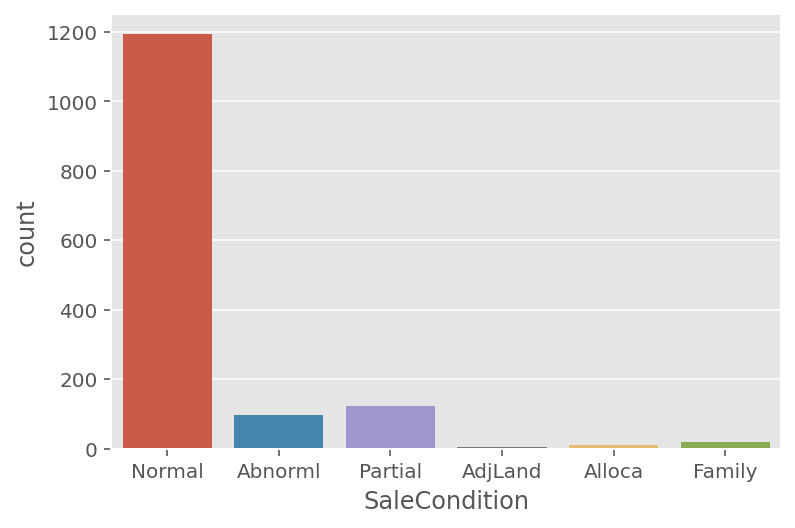

In [74]:
sns.countplot(df['SaleCondition'])

In [75]:
df['SaleCondition'].value_counts(normalize=True)

Normal     0.824464
Partial    0.085003
Abnorml    0.066344
Family     0.013822
Alloca     0.007602
AdjLand    0.002764
Name: SaleCondition, dtype: float64

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1447 non-null   object 
 1   MSZoning       1447 non-null   object 
 2   LotFrontage    1447 non-null   float64
 3   LotArea        1447 non-null   int64  
 4   Street         1447 non-null   object 
 5   Alley          1447 non-null   object 
 6   LotShape       1447 non-null   object 
 7   LandContour    1447 non-null   object 
 8   Utilities      1447 non-null   object 
 9   LotConfig      1447 non-null   object 
 10  LandSlope      1447 non-null   object 
 11  Neighborhood   1447 non-null   object 
 12  Condition1     1447 non-null   object 
 13  Condition2     1447 non-null   object 
 14  BldgType       1447 non-null   object 
 15  HouseStyle     1447 non-null   object 
 16  OverallQual    1447 non-null   int64  
 17  OverallCond    1447 non-null   int64  
 18  YearBuil

Dropped AdjLand & Alloca as too small to do Cross validation above 3

In [77]:
df = df[(df['SaleCondition'] != 'AdjLand') & (df['SaleCondition'] != 'Alloca')]

In [78]:
X = df.drop(['SaleCondition'], axis=1)
y = df['SaleCondition']

In [79]:
X = pd.get_dummies(X, drop_first=True)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [81]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SaleCondition', ylabel='count'>

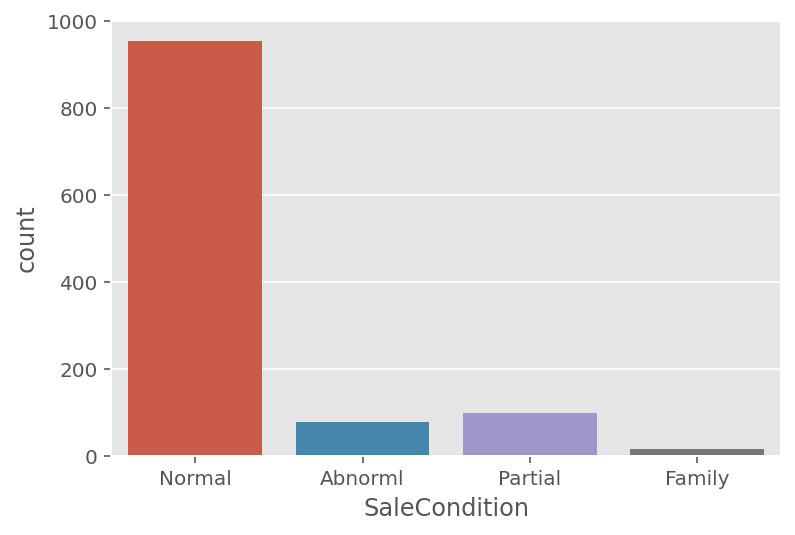

In [82]:
sns.countplot(y_train)

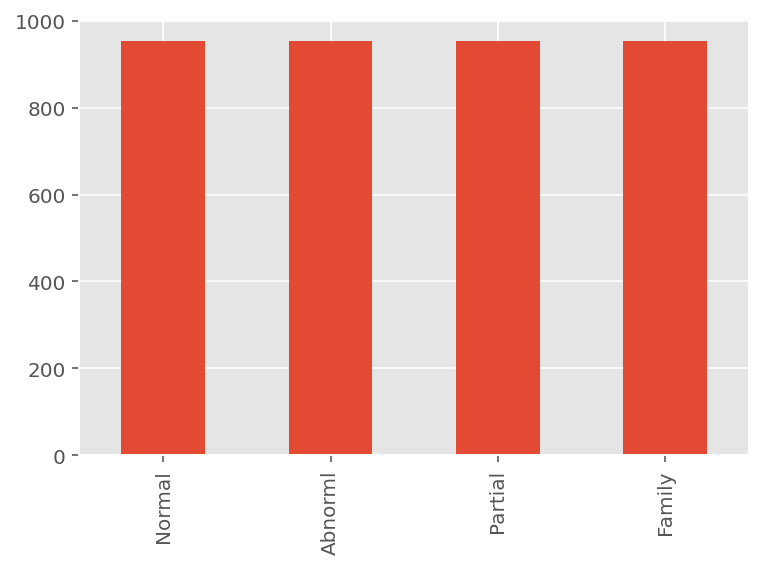

In [83]:
pd.Series(y_res).value_counts().plot.bar();

In [84]:
y_train.value_counts(normalize=True)

Normal     0.833188
Partial    0.085590
Abnorml    0.067249
Family     0.013974
Name: SaleCondition, dtype: float64

In [85]:
y_res.value_counts(normalize=True)

Normal     0.25
Abnorml    0.25
Partial    0.25
Family     0.25
Name: SaleCondition, dtype: float64

In [86]:
scaler = StandardScaler()

In [87]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_res), columns=X.columns)
                  
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### Normal Logistic Regression

In [88]:
log_reg = LogisticRegression(max_iter=10000, random_state=1, multi_class='ovr')

log_reg.fit(X_train_scaled, y_res)
print(log_reg.score(X_train_scaled, y_res))
print(log_reg.score(X_test_scaled, y_test))
print(cross_val_score(log_reg, X_train_scaled, y_res, cv=5).mean())
print(cross_val_score(log_reg, X_train_scaled, y_res, cv=5))

0.9853249475890985
0.8885017421602788
0.9546835651499661
[0.88219895 0.97378768 0.97378768 0.97640891 0.9672346 ]


In [89]:
y_pred = log_reg.predict(X_train_scaled)

In [90]:
y_pred = log_reg.predict(X_train_scaled)
confusion_matrix(y_res, y_pred, labels=['Abnorml', 'Family', 'Normal', 'Partial'])

array([[912,   4,  38,   0],
       [  0, 950,   4,   0],
       [  8,   0, 946,   0],
       [  2,   0,   0, 952]])

In [91]:
print(classification_report(y_res, y_pred))

              precision    recall  f1-score   support

     Abnorml       0.99      0.96      0.97       954
      Family       1.00      1.00      1.00       954
      Normal       0.96      0.99      0.97       954
     Partial       1.00      1.00      1.00       954

    accuracy                           0.99      3816
   macro avg       0.99      0.99      0.99      3816
weighted avg       0.99      0.99      0.99      3816



In [92]:
log_reg.coef_[0]

array([ 1.70736341e-01, -3.91034531e-01,  1.08710963e+00,  3.83457881e-01,
        3.32443877e-01, -1.19991017e+00,  1.14968369e-01,  1.88607616e-01,
        1.54285951e-01, -9.39298294e-01, -7.91586884e-01,  1.31400528e+00,
        6.15281600e-01,  4.46636487e-01,  1.58008087e+00, -3.67963410e-01,
       -4.47583802e-03, -4.64734082e-01, -3.94078761e-01,  3.71999080e-02,
       -6.23198466e-01, -1.54613131e+00, -4.71147468e-01, -7.50124404e-01,
        1.07192492e+00, -8.26676217e-01,  3.83487492e-01,  3.46011805e-01,
        2.84146579e-01,  2.65643632e-01,  2.52287463e-01,  8.32551012e-01,
       -8.73855040e-01,  3.39056484e-01, -1.14073183e-03, -3.67759345e+00,
       -3.18713514e-02,  4.75499947e-01,  2.08604705e-01,  6.17279469e-01,
       -8.55792584e-03, -2.36707679e-01, -1.29474847e-01, -2.03693798e-01,
        3.27400441e-02, -2.68574212e-01, -4.33246695e-01,  3.20379831e-01,
       -1.77778226e-02,  4.17511663e-01,  3.33714038e-01,  5.55215011e-01,
       -8.42386819e-01,  

In [155]:
coef_df = pd.DataFrame(list(zip(X_train_scaled.columns, log_reg.coef_[0])), columns=['feature', 'Abnormal Sale coef']
            ).sort_values(by='Abnormal Sale coef'
                         )
coef_df.tail(20)

feature  Abnormal Sale coef
131  Exterior1st_BrkComm            0.468796
37        MSSubClass_180            0.475500
141  Exterior1st_VinylSd            0.478401
155   Exterior2nd_Stucco            0.494000
175          BsmtQual_Gd            0.499788
51           MSZoning_RL            0.555215
12              2ndFlrSF            0.615282
39         MSSubClass_20            0.617279
60       LandContour_Low            0.657486
163         ExterQual_Gd            0.760079
220       Functional_Typ            0.805401
31              PoolArea            0.832551
177          BsmtQual_TA            0.866845
94       Condition1_Norm            0.889535
149  Exterior2nd_HdBoard            0.932139
24            GarageCars            1.071925
2            OverallQual            1.087110
170     Foundation_PConc            1.270142
11              1stFlrSF            1.314005
14             GrLivArea            1.580081

<AxesSubplot:>

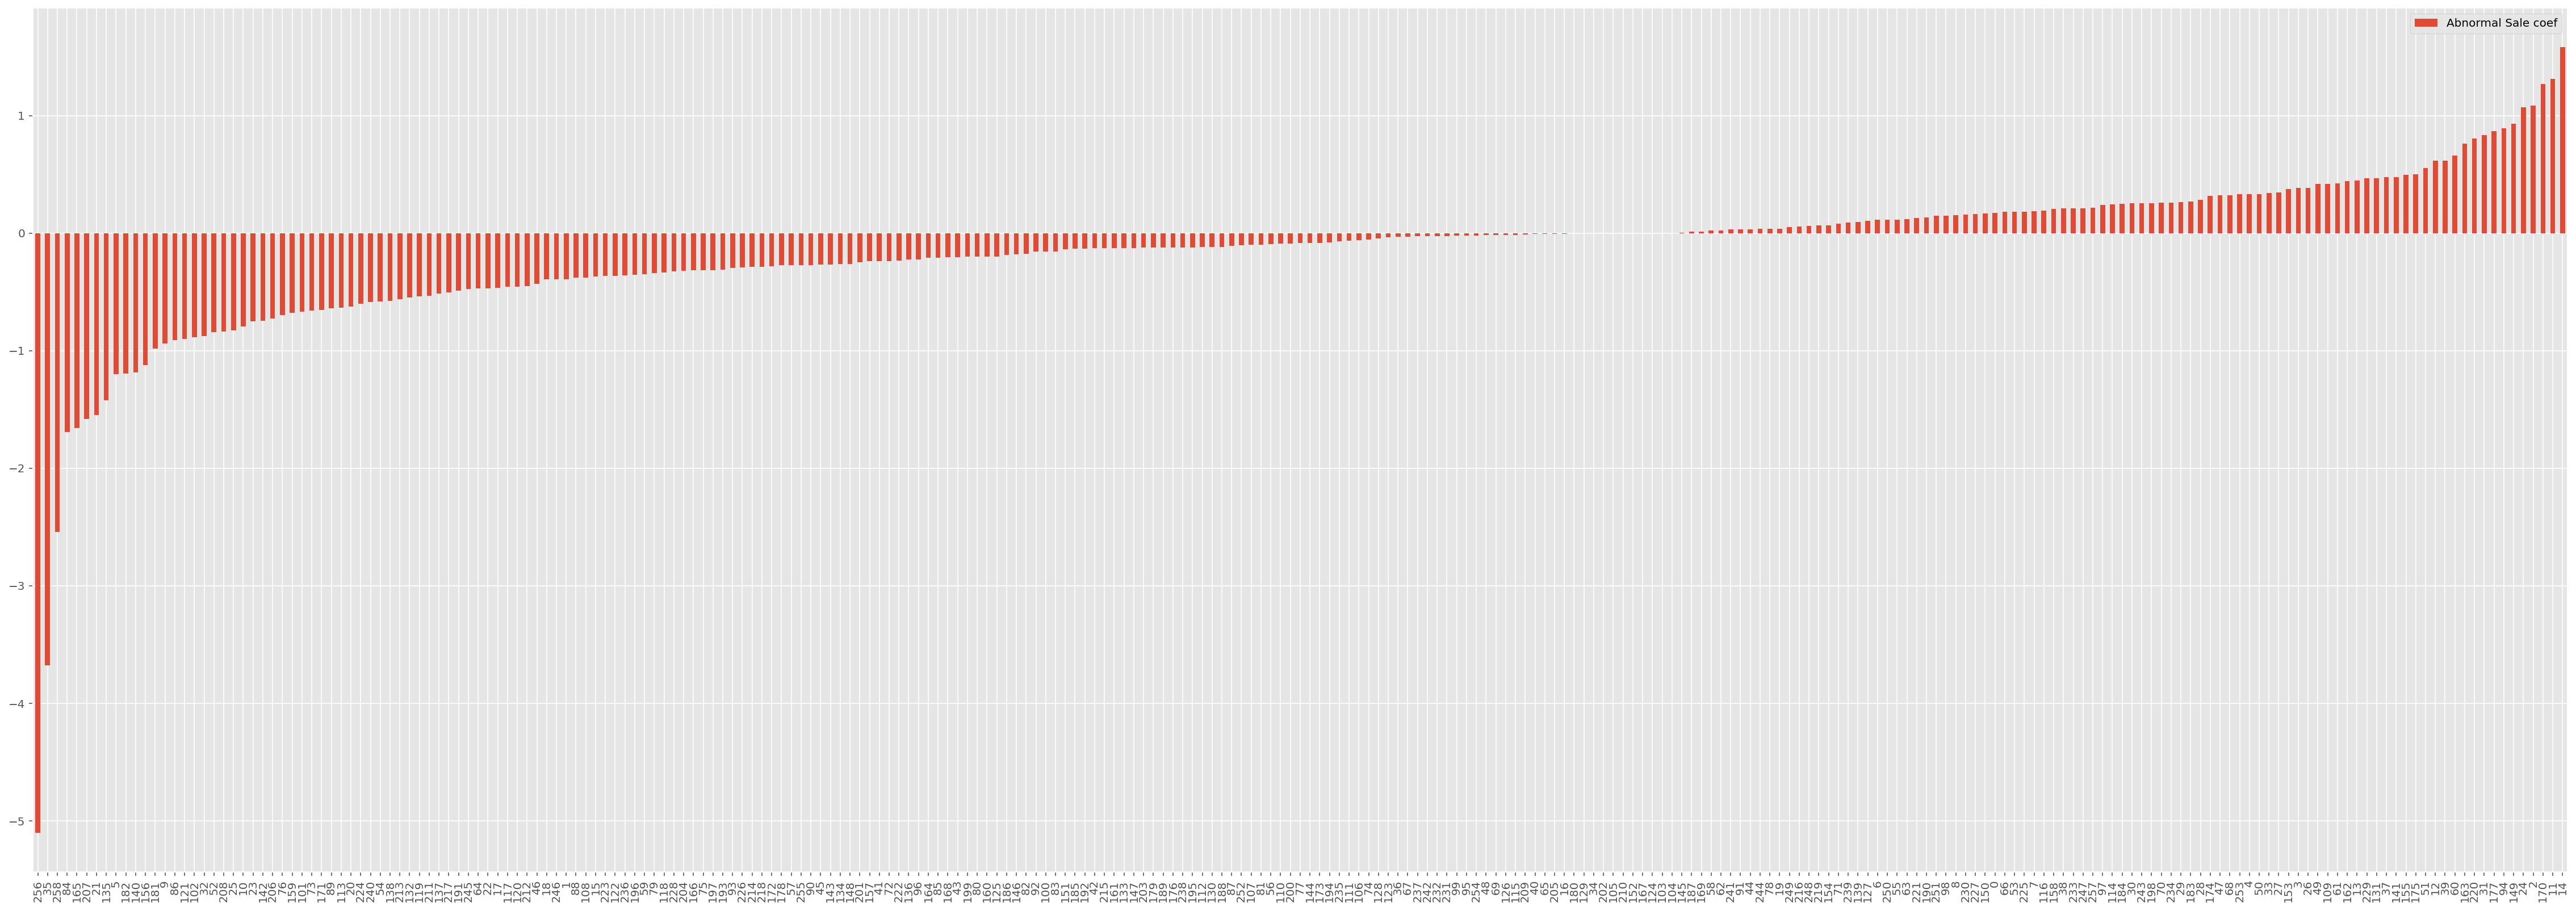

In [153]:
fig, ax = plt.subplots(figsize=(40,14))
coef_df.plot(kind='bar', ax=ax)

-------

In [94]:
log_model = LogisticRegression()

In [95]:
param_grid = {'solver':['saga'], 'C':np.logspace(-1.5,1,10),
              'penalty':['l1','l2'], 'max_iter':[10000], 'multi_class':['ovr']}

In [96]:
grid_model = GridSearchCV(log_model, param_grid, 
                            n_jobs=3, 
                            cv=5, 
                            verbose=1)

In [97]:
grid_model.fit(X_train_scaled, y_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]),
                         'max_iter': [10000], 'multi_class': ['ovr'],
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             verbose=1)

In [98]:
grid_model.best_params_

{'C': 0.05994842503189409,
 'max_iter': 10000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'saga'}

In [99]:
grid_model.best_estimator_

LogisticRegression(C=0.05994842503189409, max_iter=10000, multi_class='ovr',
                   solver='saga')

In [100]:
grid_model.best_score_

0.9578311020839481

In [101]:
best_model = grid_model.best_estimator_

In [102]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

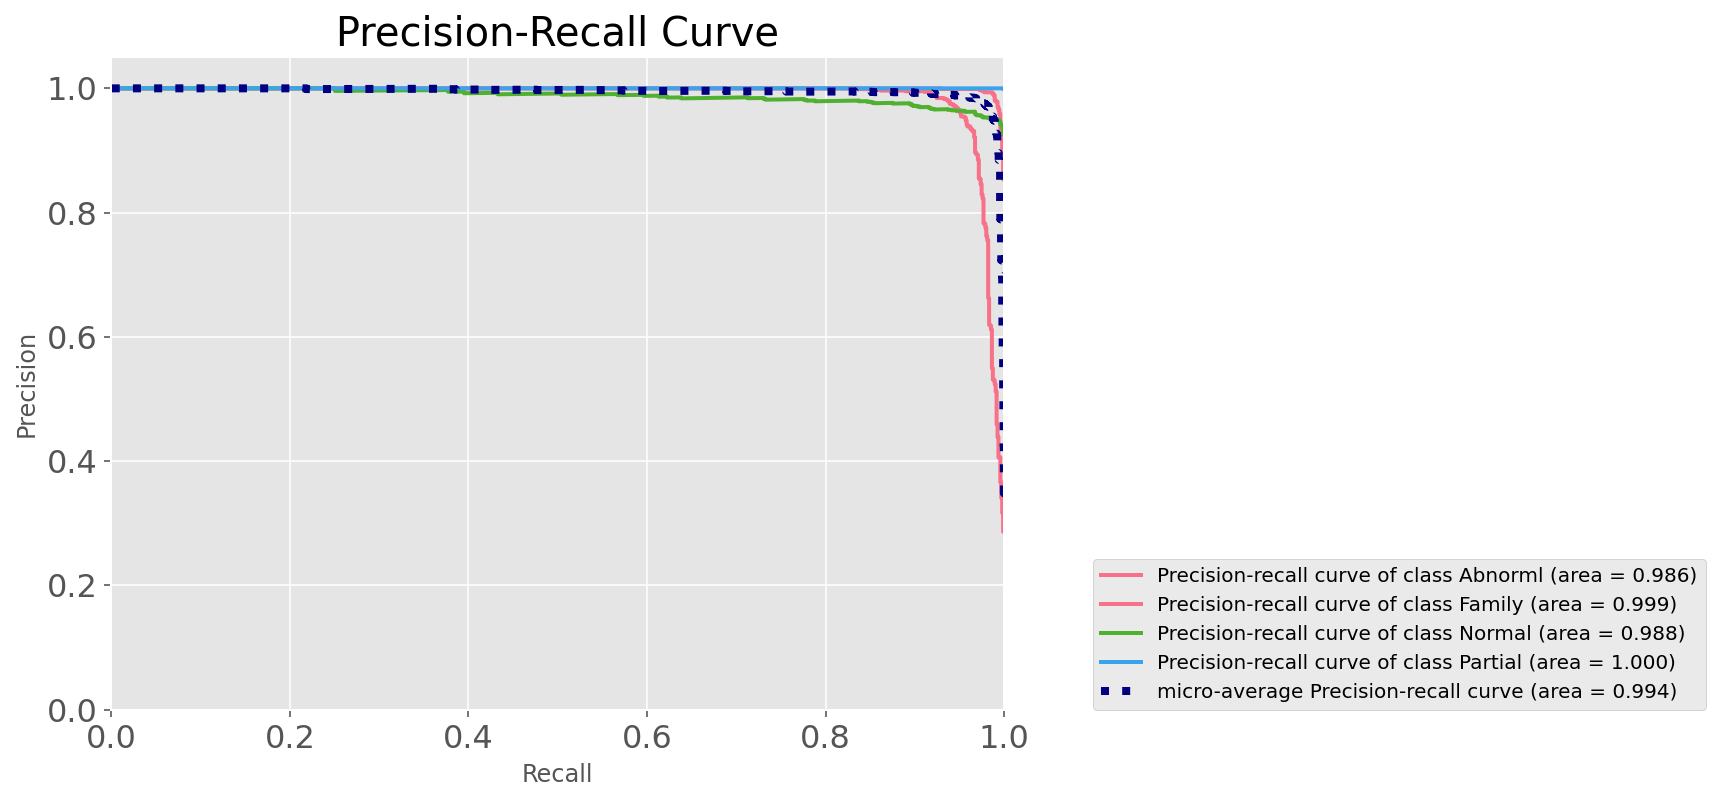

In [103]:
fig, ax = plt.subplots(figsize=(8,6))
skplt.metrics.plot_precision_recall(y_res, best_model.predict_proba(X_train_scaled), 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

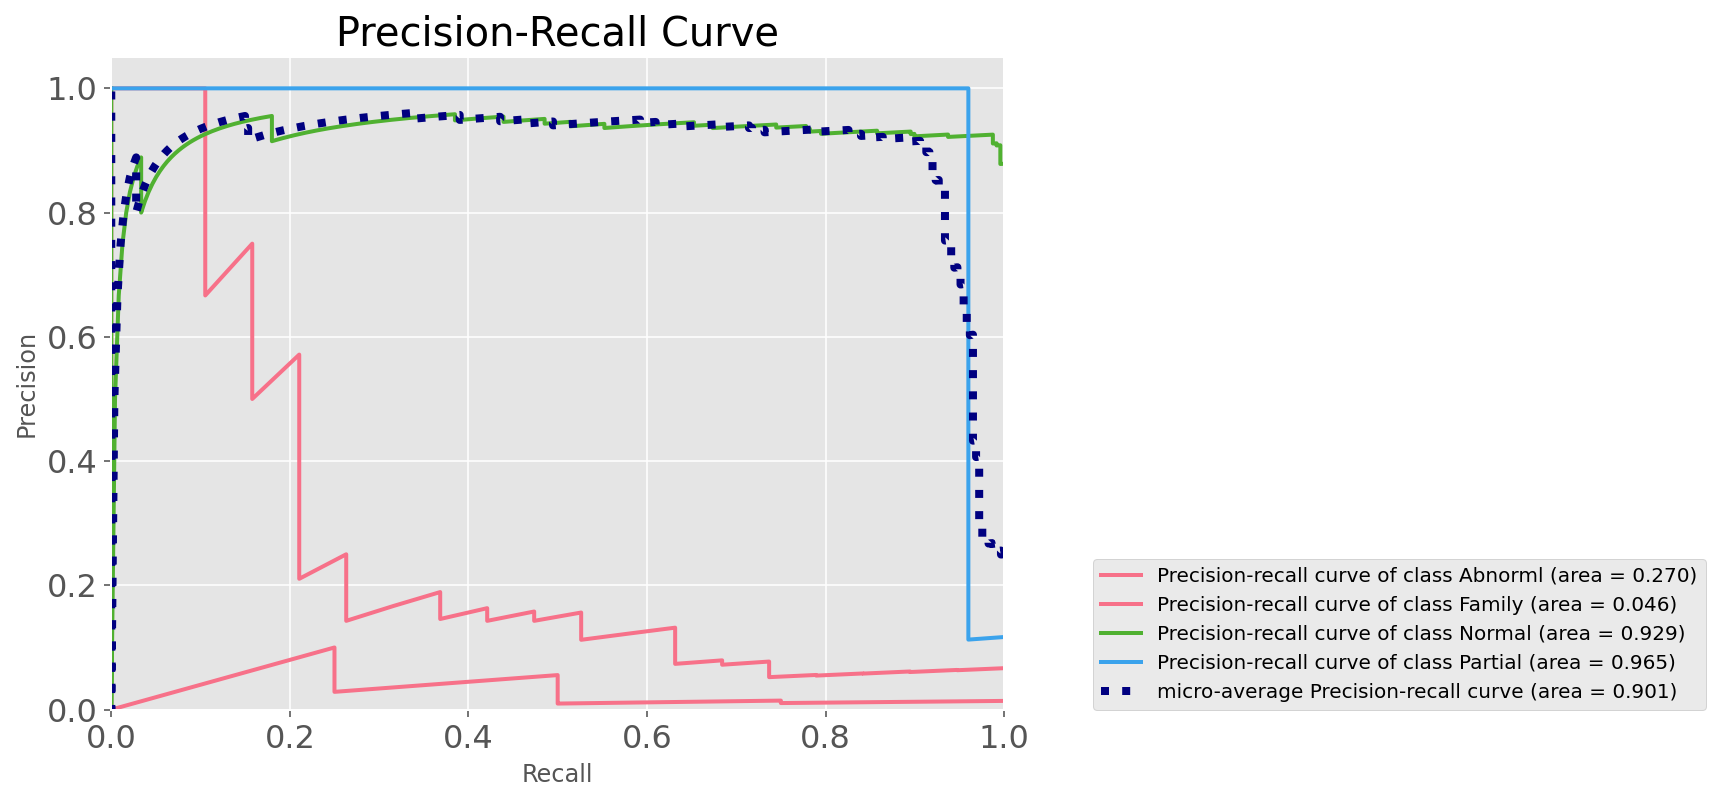

In [104]:
fig, ax = plt.subplots(figsize=(8,6))
skplt.metrics.plot_precision_recall(y_test, best_model.predict_proba(X_test_scaled), 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

-------

--------

KNN

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [134]:
knn = KNeighborsClassifier(n_neighbors=3)

In [135]:
knn.fit(X_train_scaled, y_res)
predictions = knn.predict(X_train_scaled)
print(np.unique(predictions, return_counts=True))

(array(['Abnorml', 'Family', 'Normal', 'Partial'], dtype=object), array([974, 960, 929, 953]))


In [136]:
print(knn.score(X_train_scaled, y_res))
print(knn.score(X_test_scaled, y_test))

0.9656708595387841
0.7630662020905923


In [137]:
scores = cross_val_score(knn, X_train_scaled, y_res, cv=5)
print(scores)
print(np.mean(scores))

[0.85732984 0.94364351 0.94364351 0.94626474 0.94626474]
0.927429271338681


Print out highest score with different neighbours

In [138]:
scores = []
max_k = 20
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(np.mean(cross_val_score(knn, X_train_scaled, y_res, cv=5)))

In [139]:
np.argmax(scores)+1, max(scores)

(1, 0.9305761220862812)

In [140]:
knn = KNeighborsClassifier(n_neighbors=3)

In [141]:
knn.fit(X_train_scaled, y_res)
predictions = knn.predict(X_train_scaled)
print(np.unique(predictions, return_counts=True))

(array(['Abnorml', 'Family', 'Normal', 'Partial'], dtype=object), array([974, 960, 929, 953]))


In [142]:
print(knn.score(X_train_scaled, y_res))
print(knn.score(X_test_scaled, y_test))

0.9656708595387841
0.7630662020905923


In [143]:
scores = cross_val_score(knn, X_train_scaled, y_res, cv=5)
print(scores)
print(np.mean(scores))

[0.85732984 0.94364351 0.94364351 0.94626474 0.94626474]
0.927429271338681


In [116]:
print(classification_report(y_res, knn.predict(X_train_scaled)))

              precision    recall  f1-score   support

     Abnorml       0.94      0.96      0.95       954
      Family       0.99      0.99      0.99       954
      Normal       0.95      0.92      0.94       954
     Partial       0.98      0.98      0.98       954

    accuracy                           0.97      3816
   macro avg       0.97      0.97      0.97      3816
weighted avg       0.97      0.97      0.97      3816



In [144]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

     Abnorml       0.06      0.89      0.11        19
      Family       0.00      0.00      0.00         4
      Normal       0.60      0.03      0.05       239
     Partial       0.00      0.00      0.00        25

    accuracy                           0.08       287
   macro avg       0.17      0.23      0.04       287
weighted avg       0.50      0.08      0.05       287



/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
